In [1]:
import similaritymeasures as sm
import skmob
import pandas as pd
import skmob.measures.individual as ind_measure
import torch
import gpytorch
from gpytorch.kernels import RQKernel as RQ, RBFKernel as SE, PeriodicKernel as PER, ScaleKernel
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import json
import os
import socket
#import statistics as stats
from itertools import product

# Import intra-package scripts
import utils.helper_func as helper_func
import utils.GP as GP
from utils.helper_func import dec_floor
import mobileDataToolkit.analysis as analysis
import mobileDataToolkit.preprocessing_v2 as preprocessing
import mobileDataToolkit.methods as methods
import mobileDataToolkit.metrics as metrics

# Import benchmarks
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')


def evaluate_similarity(lat_tc, pred_mean, y_test_scaled):
    preds_lat = np.hstack((pd.Series(lat_tc.index).values.reshape(-1,1), pred_mean[:,0].reshape(-1,1)))
    test_lat = np.hstack((pd.Series(lat_tc.index).values.reshape(-1,1), y_test_scaled[:,0].reshape(-1,1)))

    preds_lon = np.hstack((pd.Series(lat_tc.index).values.reshape(-1,1), pred_mean[:,1].reshape(-1,1)))
    test_lon = np.hstack((pd.Series(lat_tc.index).values.reshape(-1,1), y_test_scaled[:,1].reshape(-1,1)))

    # quantify the difference between the two curves using PCM
    pcm_lat = sm.pcm(preds_lat, test_lat)
    pcm_lon = sm.pcm(preds_lon, test_lon)

    # quantify the difference between the two curves using
    # Discrete Frechet distance
    df_lat = sm.frechet_dist(preds_lat, test_lat)
    df_lon = sm.frechet_dist(preds_lon, test_lon)

    # quantify the difference between the two curves using
    # area between two curves
    area_lat = sm.area_between_two_curves(preds_lat, test_lat)
    area_lon = sm.area_between_two_curves(preds_lon, test_lon)

    # quantify the difference between the two curves using
    # Curve Length based similarity measure
    cl_lat = sm.curve_length_measure(preds_lat, test_lat)
    cl_lon = sm.curve_length_measure(preds_lon, test_lon)

    # quantify the difference between the two curves using
    # Dynamic Time Warping distance
    dtw_lat, d_lat = sm.dtw(preds_lat, test_lat)
    dtw_lon, d_lon = sm.dtw(preds_lon, test_lon)

    # mean absolute error
    mae_lat = sm.mae(preds_lat, test_lat)
    mae_lon = sm.mae(preds_lon, test_lon)

    # mean squared error
    mse_lat = sm.mse(preds_lat, test_lat)
    mse_lon = sm.mse(preds_lon, test_lon)

    # Take the average of the metrics
    return {
        'PCM': (pcm_lat + pcm_lon) / 2,
        'DF': (df_lat + df_lon) / 2,
        'AREA': (area_lat + area_lon) / 2,
        'CL': (cl_lat + cl_lon) / 2,
        'DTW': (dtw_lat + dtw_lon) / 2,
        'MAE': (mae_lat + mae_lon) / 2,
        'MSE': (mse_lat + mse_lon) / 2
    }

In [2]:
def trainingLossPlot(ls):
    iters = range(0, len(ls))
    fig4, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(iters, ls, 'g')
    ax.set_title('Training Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    return fig4

def predictionsVsActualPlot(y_test_scaled, mean):
    plt.rcParams.update({'font.size': 9})
            # Make the font nicer
    plt.rcParams.update({'font.family': 'serif'})
    fig3, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Predictions')
    try:
        pd.DataFrame(mean.detach().numpy()).plot(x=1, y=0, kind='scatter',ax=ax, color='red', alpha=0.5, s=0.4, label='Predictions')
    except AttributeError: 
        pd.DataFrame(mean).plot(x=1, y=0, kind='scatter',ax=ax, color='red', alpha=0.5, s=0.4, label='Predictions')
    pd.DataFrame(y_test_scaled.detach().numpy()).plot(x=1, y=0, kind='scatter',ax=ax, color='blue', alpha=0.5, s=0.4, label='Actual')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return fig3

def trainTestPlot(gapped_user_data, curr_mt, lat_col='orig_lat', long_col='orig_long'):
    plt.rcParams.update({'font.size': 9})
    plt.rcParams.update({'font.family': 'serif'})
    fig1, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ax[0].scatter(curr_mt.data[curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))]['unix_min'],
                            curr_mt.data[curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))][lat_col],
                            color='blue', label='Training data', s=1)
    ax[0].scatter(curr_mt.data[~curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))]['unix_min'],
                            curr_mt.data[~curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))][lat_col],
                            color='red', label='Test data', s=1)
    ax[0].set_ylabel('Latitude')
    ax[1].scatter(curr_mt.data[curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))]['unix_min'],
                            curr_mt.data[curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))][long_col],
                            color='blue', label='Training data', s=1)
    ax[1].scatter(curr_mt.data[~curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))]['unix_min'],
                            curr_mt.data[~curr_mt.data['unix_min'].isin(set(gapped_user_data['unix_min']))][long_col],
                            color='red', label='Test data', s=1)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Longitude')
    ax[1].legend()
    return fig1

def makeSeries(y_train_scaled, y_test_scaled, unix_min_tr, unix_min_te):
    lat = pd.Series(y_train_scaled[:,0].tolist(), unix_min_tr)
    lat_t = pd.Series(y_test_scaled[:,0].tolist(), unix_min_te)
            # Replace duplicates (in time) with the mean of the two values
    lat = lat.groupby(lat.index).mean().reset_index()
    lat = pd.Series(lat[0].tolist(), lat['index'].tolist())
    lat_tc = lat_t.groupby(lat_t.index).mean().reset_index()
    lat_tc = pd.Series(lat_tc[0].tolist(), lat_tc['index'].tolist())
            # Replace zeroes with positives close to zero
    lat.replace(0, 0.000000001, inplace=True)

    lon = pd.Series(y_train_scaled[:,1].tolist(), unix_min_tr)
    lon_t = pd.Series(y_test_scaled[:,1].tolist(),unix_min_te)
            # Replace duplicates (in time) with the mean of the two values
    lon = lon.groupby(lon.index).mean().reset_index()
    lon = pd.Series(lon[0].tolist(), lon['index'].tolist())
    lon_tc = lon_t.groupby(lon_t.index).mean().reset_index()
    lon_tc = pd.Series(lon_tc[0].tolist(), lon_tc['index'].tolist())
            # Replace zeroes with positives close to zero
    lon.replace(0, 0.000000001, inplace=True)
    return lat,lat_tc,lon,lon_tc

Path already exists. Skipping to next user.
Starting test on user ID = 017bb1f45ee11018b1cca82711c729999f08ac159c9ffc506eb4c6eb2fa46dbb
Number of rows before filtering: 22936
Number of rows after filtering: 22114
Number of rows after compression: 8435
Number of rows after uncertainty filtering: 8415
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1817
Number of points in test set: 0
Number of input dimensions: 13
No points in test set. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 0452bae748165058705f67f1c888782e049ba21e9141301c9342c46aa7f5fb97
Number of rows before filtering: 22744
Number of rows after filtering: 22335
N

100%|██████████| 150/150 [00:16<00:00,  9.23it/s, Loss=-0.205, noise=0.000126]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 476
Number of points in test set: 204
Number of input dimensions: 13


 79%|███████▉  | 119/150 [00:07<00:02, 15.32it/s, Loss=-0.640, noise=0.000121]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 612
Number of points in test set: 7
Number of input dimensions: 13


100%|██████████| 150/150 [00:15<00:00,  9.82it/s, Loss=-0.135, noise=0.000122]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 073025002fce6507d4c69699e542b33b2e598292c1b17b0292f5cf7b79dc10f0
Number of rows before filtering: 22145
Number of rows after filtering: 21771
Number of rows after compression: 2732
Number of rows after uncertainty filtering: 2725
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 728
Number of points in test set: 20
Number of input dimensions: 13


100%|██████████| 150/150 [00:21<00:00,  6.90it/s, Loss=0.437, noise=0.000113] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1039
Number of points in test set: 446
Number of input dimensions: 13


100%|██████████| 150/150 [00:47<00:00,  3.14it/s, Loss=-0.440, noise=0.000135]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 738
Number of points in test set: 10
Number of input dimensions: 13


100%|██████████| 150/150 [00:22<00:00,  6.69it/s, Loss=-0.213, noise=0.000117]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 0fcb1970acbb34a8b0d72b25ad8126aeff5b7b12954f5590b67e5f96467beaba
Number of rows before filtering: 9986
Number of rows after filtering: 9733
Number of rows after compression: 1921
Number of rows after uncertainty filtering: 1920
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 532
Number of points in test set: 0
Number of input dimensions: 13
No points in test set. Skipping to next user.
Starting test on user ID = 1b78570172ae3f8d44b9483111ad265051fe747cf5c5c27d7b5f15e125b081ca
Number of rows before filtering: 7065
Number of rows after filtering: 6914
Number of rows after compression: 1346
Number of rows after uncerta

 97%|█████████▋| 146/150 [00:07<00:00, 18.83it/s, Loss=-0.056, noise=0.000181]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 366
Number of points in test set: 158
Number of input dimensions: 13


100%|██████████| 150/150 [00:08<00:00, 18.33it/s, Loss=-0.237, noise=0.000154]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 439
Number of points in test set: 69
Number of input dimensions: 13


 61%|██████▏   | 92/150 [00:05<00:03, 17.32it/s, Loss=-0.048, noise=0.000214]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 3849d359e67f03722c122cf520048611e36d54f10644772f9d8c7ab3b0c75865
Number of rows before filtering: 15863
Number of rows after filtering: 15709
Number of rows after compression: 879
Number of rows after uncertainty filtering: 878
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 245
Number of points in test set: 17
Number of input dimensions: 13


 63%|██████▎   | 94/150 [00:02<00:01, 32.27it/s, Loss=-0.944, noise=0.000128]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 322
Number of points in test set: 139
Number of input dimensions: 13


 79%|███████▊  | 118/150 [00:05<00:01, 23.28it/s, Loss=-0.958, noise=0.000122]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 253
Number of points in test set: 9
Number of input dimensions: 13


 77%|███████▋  | 116/150 [00:03<00:01, 33.70it/s, Loss=-0.979, noise=0.000122]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 499a6ae04ce6f8aace1168973e6d21ff761e53ce335719b3531090d294429a34
Number of rows before filtering: 21494
Number of rows after filtering: 20709
Number of rows after compression: 7952
Number of rows after uncertainty filtering: 7934
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 3148
Number of points in test set: 16
Number of input dimensions: 13


100%|██████████| 150/150 [18:09<00:00,  7.27s/it, Loss=-0.199, noise=0.000136]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 2306
Number of points in test set: 989
Number of input dimensions: 13


100%|██████████| 150/150 [06:44<00:00,  2.70s/it, Loss=-0.337, noise=0.000123]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 3156
Number of points in test set: 8
Number of input dimensions: 13


100%|██████████| 150/150 [18:41<00:00,  7.48s/it, Loss=-0.191, noise=0.00013] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 66be6d7718cf2649538b4cca573231704d4f0fd5e6078e9875957d96999a66e2
Number of rows before filtering: 12178
Number of rows after filtering: 12032
Number of rows after compression: 1333
Number of rows after uncertainty filtering: 1327
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 305
Number of points in test set: 0
Number of input dimensions: 13
No points in test set. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 66d0f36e023abfcc6937bc3e743335b0b869fc6eef976d7992c1111f452ddc85
Number o

100%|██████████| 150/150 [00:46<00:00,  3.21it/s, Loss=0.077, noise=0.000143]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1043
Number of points in test set: 448
Number of input dimensions: 13


100%|██████████| 150/150 [00:50<00:00,  2.98it/s, Loss=0.365, noise=0.000214]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1045
Number of points in test set: 46
Number of input dimensions: 13


 97%|█████████▋| 145/150 [00:49<00:01,  2.93it/s, Loss=0.079, noise=0.000143]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 66dd34fd075efc6c6eced42c2df6a0f44a3d6e64e37c6abfcf41133b48caebe3
Number of rows before filtering: 7682
Number of rows after filtering: 7464
Number of rows after compression: 1235
Number of rows after uncertainty filtering: 1226
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 397
Number of points in test set: 12
Number of input dimensions: 13


 65%|██████▌   | 98/150 [00:05<00:03, 16.54it/s, Loss=-0.287, noise=0.000151]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 445
Number of points in test set: 191
Number of input dimensions: 13


 71%|███████   | 106/150 [00:06<00:02, 15.97it/s, Loss=-0.693, noise=0.000121]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 403
Number of points in test set: 6
Number of input dimensions: 13


 63%|██████▎   | 95/150 [00:04<00:02, 19.97it/s, Loss=-0.303, noise=0.000149]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 66e303fdc62eaf58f7081b855a35727bb021f8b5eec907d05590404d5e583767
Number of rows before filtering: 11584
Number of rows after filtering: 11439
Number of rows after compression: 240
Number of rows after uncertainty filtering: 240
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_2', 'day_3', 'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 128
Number of points in test set: 0
Number of input dimensions: 11
No points in test set. Skipping to next user.
Starting test on user ID = 69c2c03fade63c8a849e55016919953873260f698366882b9fa57725159ae41c
Number of rows before filtering: 18832
Number of rows after filtering: 18363
Number of rows after compression: 2436
Number of rows after uncertainty filtering: 2426
In

 68%|██████▊   | 102/150 [00:24<00:11,  4.11it/s, Loss=-0.351, noise=0.000127]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 745
Number of points in test set: 320
Number of input dimensions: 13


 85%|████████▌ | 128/150 [00:19<00:03,  6.40it/s, Loss=-1.010, noise=0.000108]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 940
Number of points in test set: 4
Number of input dimensions: 13


 50%|█████     | 75/150 [00:19<00:19,  3.89it/s, Loss=-0.344, noise=0.000153]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 69c3e7f9bada0ce6da349e4c544958268c6bb50ddb8a61959102a21d0482104d
Number of rows before filtering: 12295
Number of rows after filtering: 11747
Number of rows after compression: 4085
Number of rows after uncertainty filtering: 4077
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1581
Number of points in test set: 2
Number of input dimensions: 13


100%|██████████| 150/150 [02:19<00:00,  1.08it/s, Loss=-0.510, noise=0.000118]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1296
Number of points in test set: 556
Number of input dimensions: 13


100%|██████████| 150/150 [01:19<00:00,  1.90it/s, Loss=-0.631, noise=0.000112]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No points in test set. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = 6c9ebcbdba36aad58b32d795a636bcf8e9d980524433430488cd00bbd59f602d
Number of rows before filtering: 13006
Number of rows after filtering: 12914
Number of rows after compression: 3930
Number of rows after uncertainty filtering: 3789
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 878
Number of points in test set: 358
Number of input dimensions: 13


100%|██████████| 150/150 [00:33<00:00,  4.51it/s, Loss=-0.458, noise=0.000116]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1576
Number of points in test set: 676
Number of input dimensions: 13


100%|██████████| 150/150 [02:07<00:00,  1.18it/s, Loss=-0.374, noise=0.000111]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1057
Number of points in test set: 179
Number of input dimensions: 13


100%|██████████| 150/150 [00:50<00:00,  2.96it/s, Loss=-0.329, noise=0.000122]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Starting test on user ID = 7b22c28093008e6218a0b3faad746425cf3c8b4f237fe53b0b37b8a92e0f5e7e
Number of rows before filtering: 17254
Number of rows after filtering: 16759
Number of rows after compression: 4916
Number of rows after uncertainty filtering: 4876
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1645
Number of points in test set: 370
Number of input dimensions: 13


100%|██████████| 150/150 [02:32<00:00,  1.02s/it, Loss=0.135, noise=0.00015] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1666
Number of points in test set: 715
Number of input dimensions: 13


100%|██████████| 150/150 [02:34<00:00,  1.03s/it, Loss=0.265, noise=0.000387]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1830
Number of points in test set: 185
Number of input dimensions: 13


100%|██████████| 150/150 [03:13<00:00,  1.29s/it, Loss=0.225, noise=0.000193]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = 83c7fda9b9d54ecd0f0f4ac2f86f4832cbff17182929df8f0d8ade30506c31d4
Number of rows before filtering: 56570
Number of rows after filtering: 54584
Number of rows after compression: 7818
Number of rows after uncertainty filtering: 7555
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1189
Number of points in test set: 211
Number of input dimensions: 13


100%|██████████| 150/150 [01:06<00:00,  2.24it/s, Loss=0.126, noise=0.00017] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 3325
Number of points in test set: 1426
Number of input dimensions: 13


100%|██████████| 150/150 [22:59<00:00,  9.20s/it, Loss=0.211, noise=0.000174]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1294
Number of points in test set: 106
Number of input dimensions: 13


100%|██████████| 150/150 [01:19<00:00,  1.89it/s, Loss=0.202, noise=0.000188]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Starting test on user ID = 83ce9fef3ce526142d9c5e0ec8c94d9be1c96f233aa09a379ac90c9c26088337
Number of rows before filtering: 9142
Number of rows after filtering: 8696
Number of rows after compression: 2353
Number of rows after uncertainty filtering: 2334
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 738
Number of points in test set: 13
Number of input dimensions: 13


100%|██████████| 150/150 [00:22<00:00,  6.54it/s, Loss=-0.092, noise=0.000119]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 866
Number of points in test set: 372
Number of input dimensions: 13


100%|██████████| 150/150 [00:31<00:00,  4.74it/s, Loss=0.034, noise=0.000164]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 744
Number of points in test set: 7
Number of input dimensions: 13


100%|██████████| 150/150 [00:22<00:00,  6.78it/s, Loss=-0.256, noise=0.000123]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Starting test on user ID = 9dcfabb216c4616e78c2db1195e5ff9564aac612f51ba982fc21e0ffcf656357
Number of rows before filtering: 5564
Number of rows after filtering: 5415
Number of rows after compression: 1100
Number of rows after uncertainty filtering: 1090
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 362
Number of points in test set: 3
Number of input dimensions: 13


 69%|██████▉   | 104/150 [00:04<00:02, 21.72it/s, Loss=-1.006, noise=0.000118]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 405
Number of points in test set: 174
Number of input dimensions: 13


 63%|██████▎   | 94/150 [00:04<00:02, 20.16it/s, Loss=-0.905, noise=0.000115]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 363
Number of points in test set: 2
Number of input dimensions: 13


100%|██████████| 150/150 [00:06<00:00, 22.47it/s, Loss=-1.143, noise=0.000105]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = a0bbf90f3f4177b0abed92b06d732d7bcca56ab99f2b66bc632dc7198c6cb6d5
Number of rows before filtering: 14758
Number of rows after filtering: 14652
Number of rows after compression: 251
Number of rows after uncertainty filtering: 247
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_5',
       'day_6'],
      dtype='object')
Number of points in training set: 86
Number of points in test set: 1
Number of input dimensions: 12
No points in test set. Skipping to next user.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = a689835049e449b18de9bc91dc022d129a94fbb7b0b23da8575ea3f4ee3ce032
Number of rows before filtering: 31250
Number of rows after filt

 93%|█████████▎| 139/150 [00:17<00:01,  8.06it/s, Loss=-0.304, noise=0.000128]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 2853
Number of points in test set: 1224
Number of input dimensions: 13


100%|██████████| 150/150 [13:10<00:00,  5.27s/it, Loss=-0.203, noise=0.000132]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 698
Number of points in test set: 20
Number of input dimensions: 13


100%|██████████| 150/150 [00:19<00:00,  7.72it/s, Loss=-0.362, noise=0.000126]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = b7b58baeedcf03c710599f344e7a697b587a4e90a9319e6551bae13e40f3c748
Number of rows before filtering: 36654
Number of rows after filtering: 35681
Number of rows after compression: 6021
Number of rows after uncertainty filtering: 5977
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1985
Number of points in test set: 257
Number of input dimensions: 13


100%|██████████| 150/150 [1:20:31<00:00, 32.21s/it, Loss=-0.256, noise=0.000137] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1712
Number of points in test set: 734
Number of input dimensions: 13


 57%|█████▋    | 86/150 [01:35<01:10,  1.11s/it, Loss=-0.158, noise=0.000153]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 2113
Number of points in test set: 129
Number of input dimensions: 13


 82%|████████▏ | 123/150 [04:27<00:58,  2.17s/it, Loss=-0.167, noise=0.000147]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = ba9c97d1280010302f0cb5569e86acab571ca83dc4ac4770dd5d25f3ef63cb47
Number of rows before filtering: 6212
Number of rows after filtering: 6112
Number of rows after compression: 1872
Number of rows after uncertainty filtering: 1871
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 815
Number of points in test set: 0
Number of input dimensions: 13
No points in test set. Skipping to next user.
Path already exists. Skipping to next user.
Starting test on user ID = d1980174954700cb0bfac449e2518de4b501059db92fe5b4e16e91d1715a70f4
Number of rows before filtering: 5634
Number of rows after filtering: 5594
Number of rows after co

100%|██████████| 150/150 [01:55<00:00,  1.30it/s, Loss=-0.672, noise=0.000112]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1388
Number of points in test set: 596
Number of input dimensions: 13


100%|██████████| 150/150 [01:43<00:00,  1.45it/s, Loss=-0.349, noise=0.000113]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1549
Number of points in test set: 45
Number of input dimensions: 13


100%|██████████| 150/150 [02:14<00:00,  1.11it/s, Loss=-0.564, noise=0.000117]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Starting test on user ID = e025f693e3dffea92d4dbd50c88cee564c1f538157b706d699e2086969188e32
Number of rows before filtering: 8675
Number of rows after filtering: 8490
Number of rows after compression: 2772
Number of rows after uncertainty filtering: 2768
Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')
Number of points in training set: 1151
Number of points in test set: 19
Number of input dimensions: 13


100%|██████████| 150/150 [01:01<00:00,  2.45it/s, Loss=-0.454, noise=0.000132]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 939
Number of points in test set: 403
Number of input dimensions: 13


 65%|██████▍   | 97/150 [00:25<00:14,  3.77it/s, Loss=-0.142, noise=0.00015] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of points in training set: 1160
Number of points in test set: 10
Number of input dimensions: 13


 61%|██████▏   | 92/150 [00:36<00:23,  2.50it/s, Loss=-0.353, noise=0.000156]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Failed to save parameters.
Path already exists. Skipping to next user.
Path already exists. Skipping to next user.


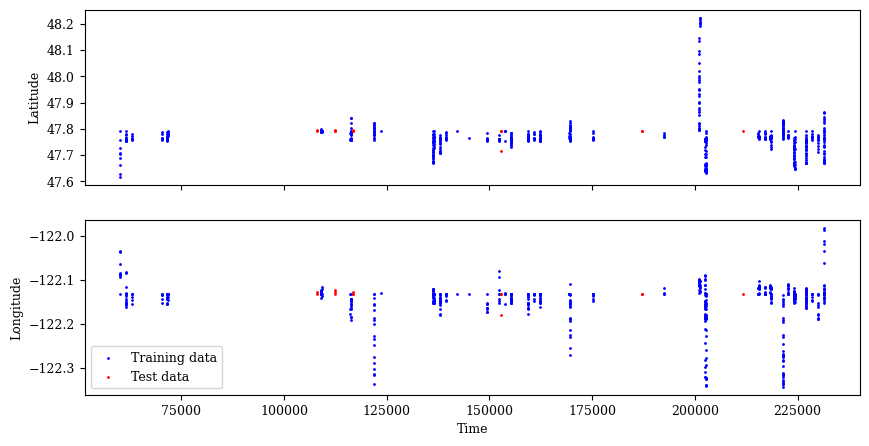

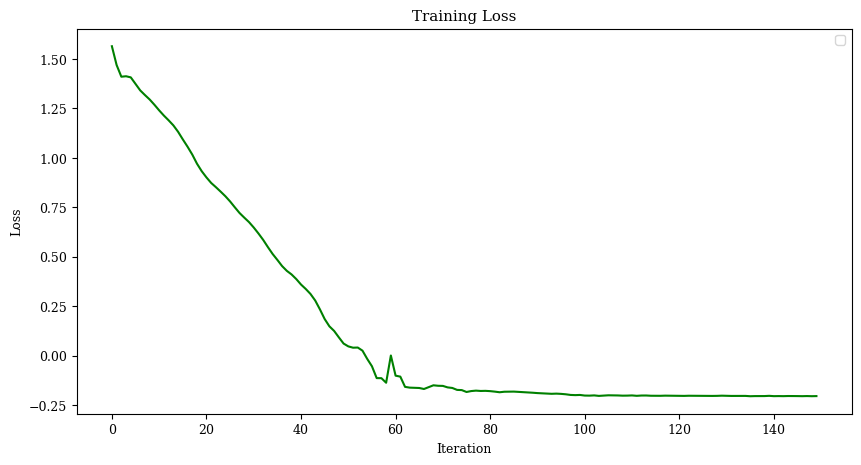

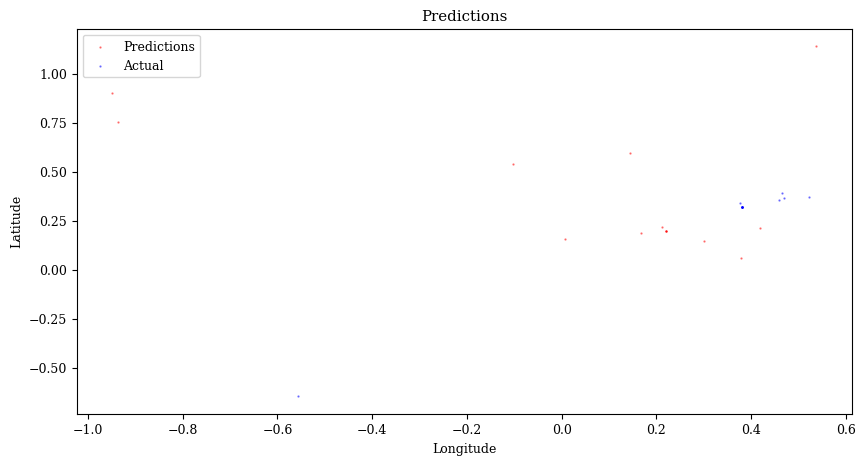

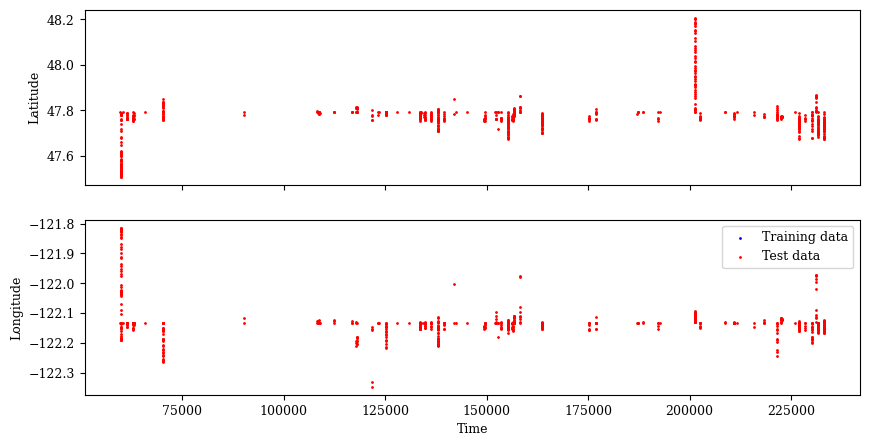

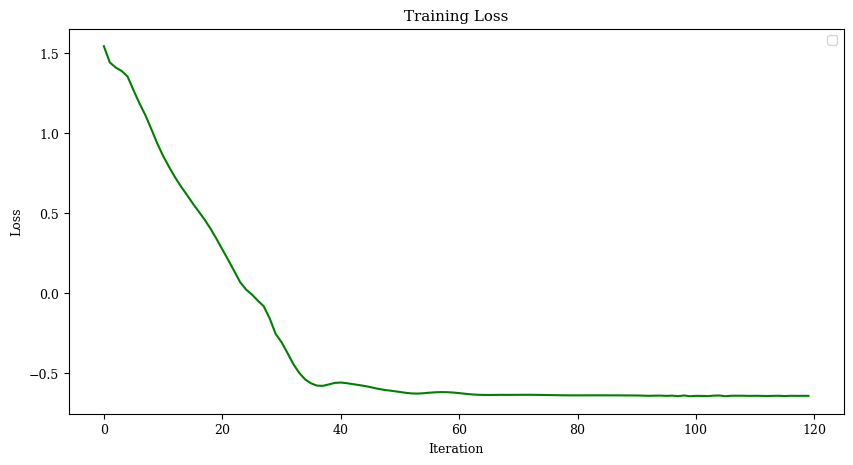

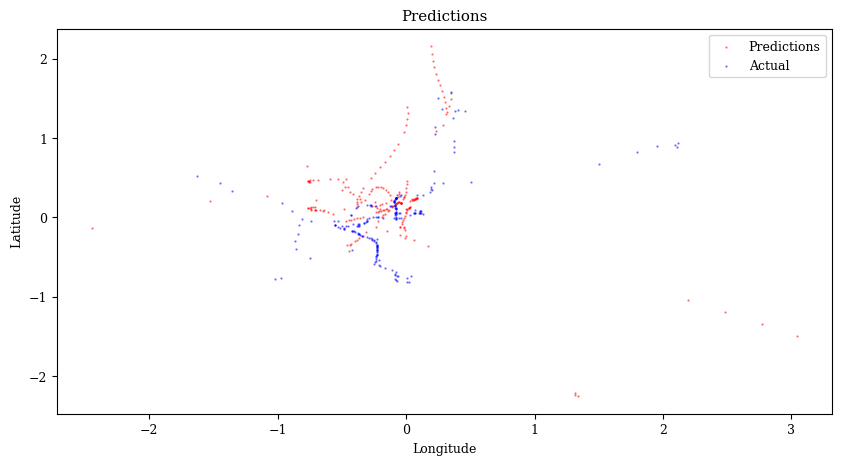

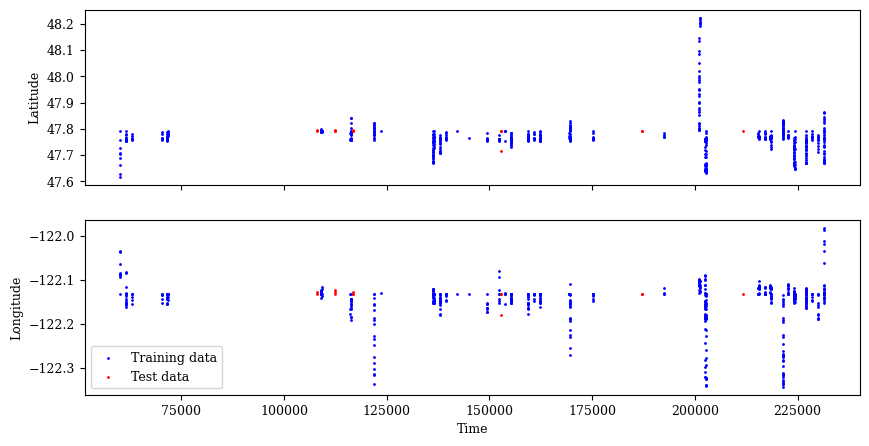

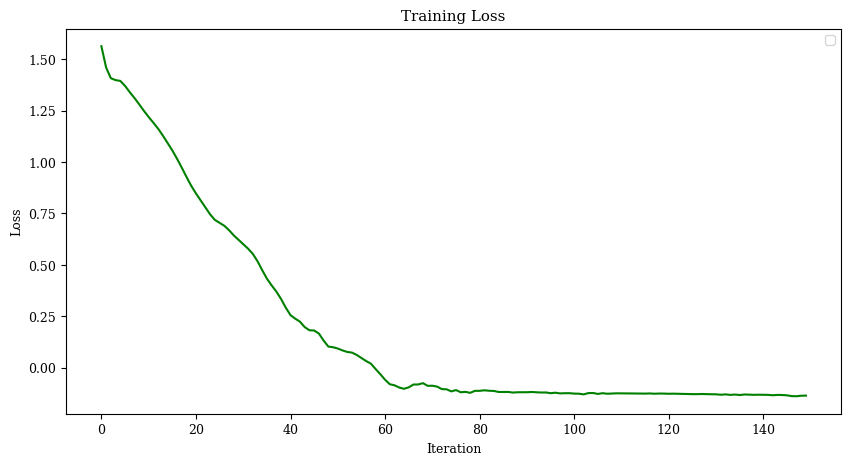

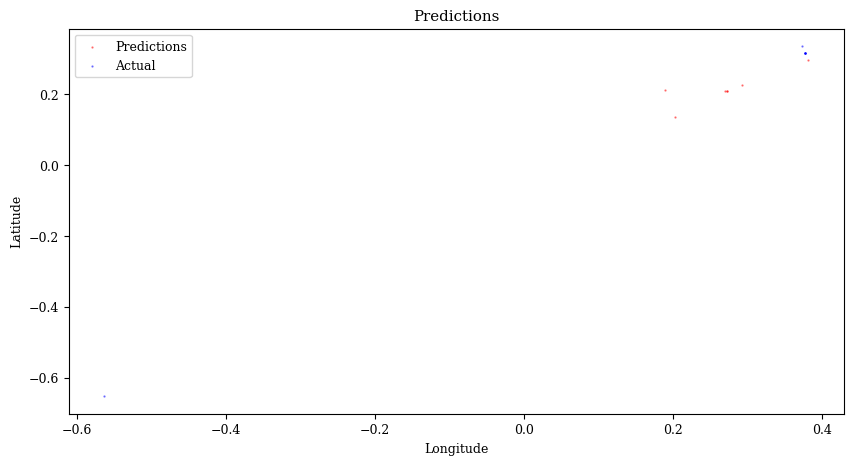

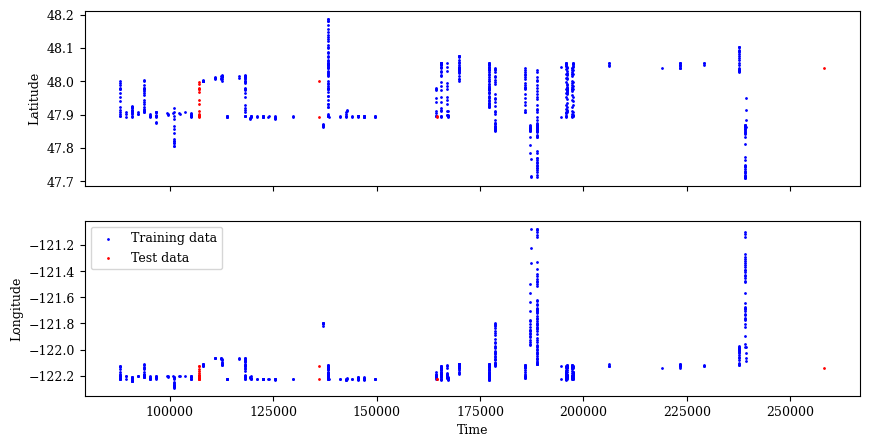

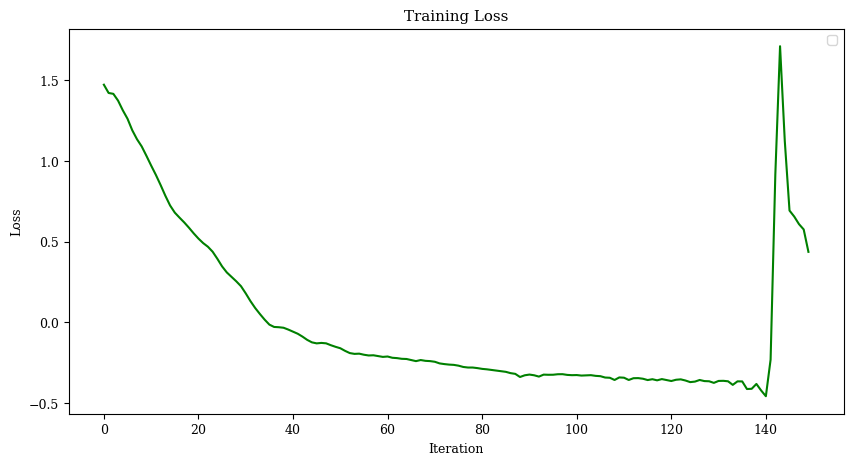

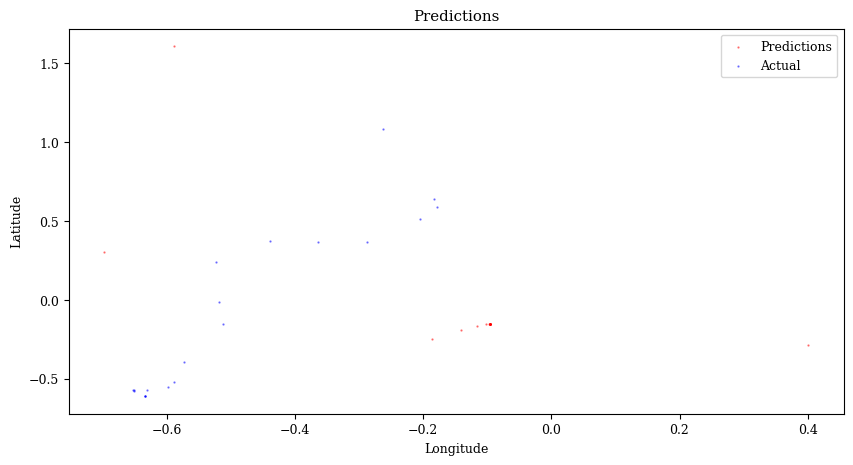

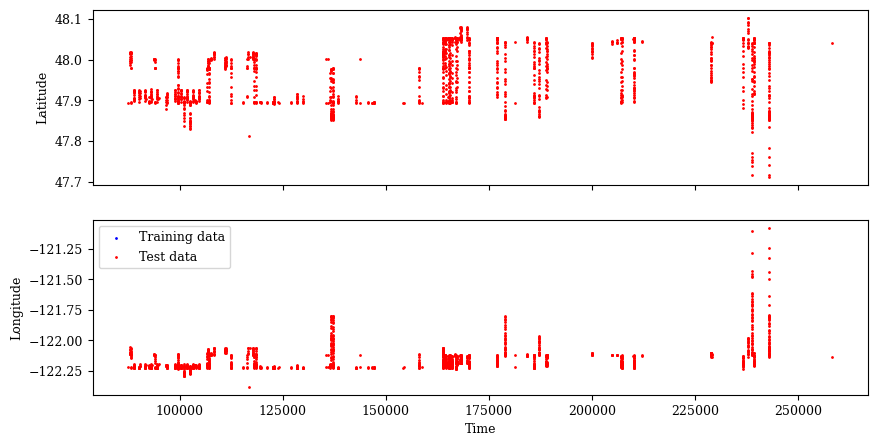

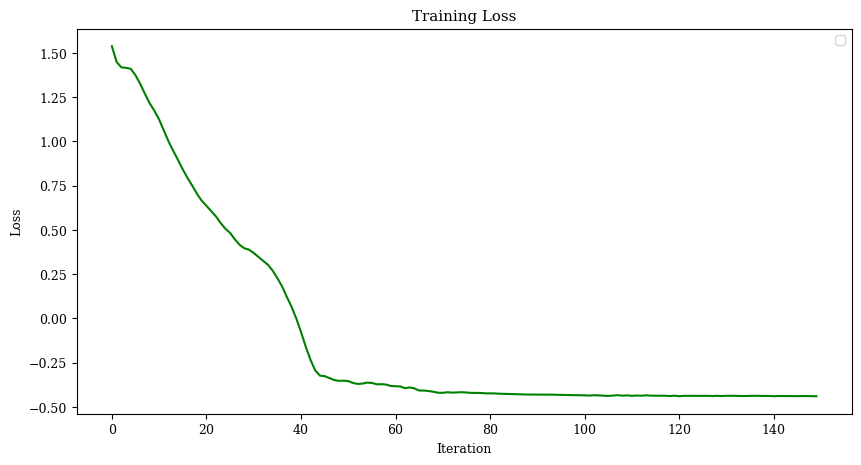

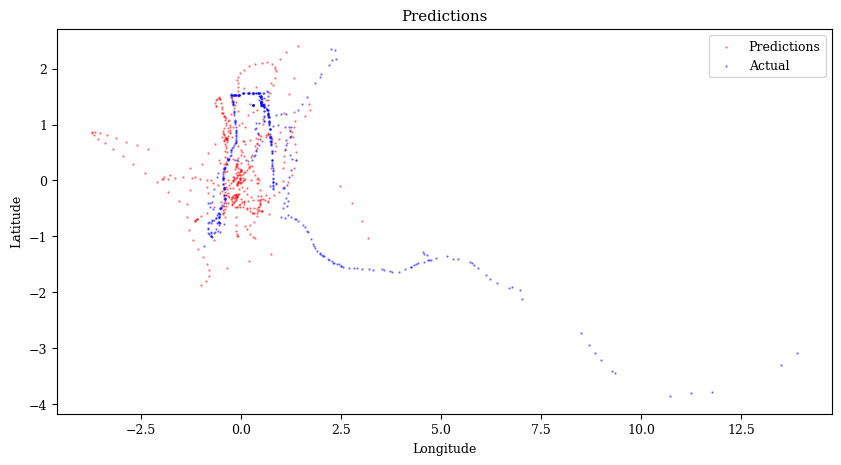

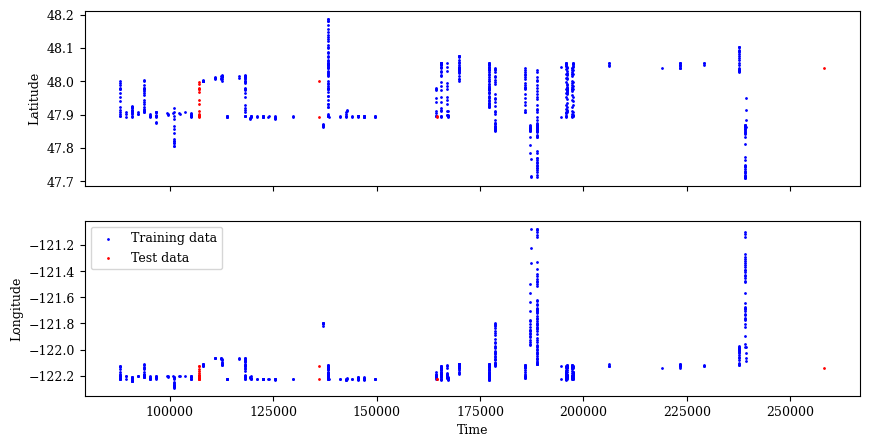

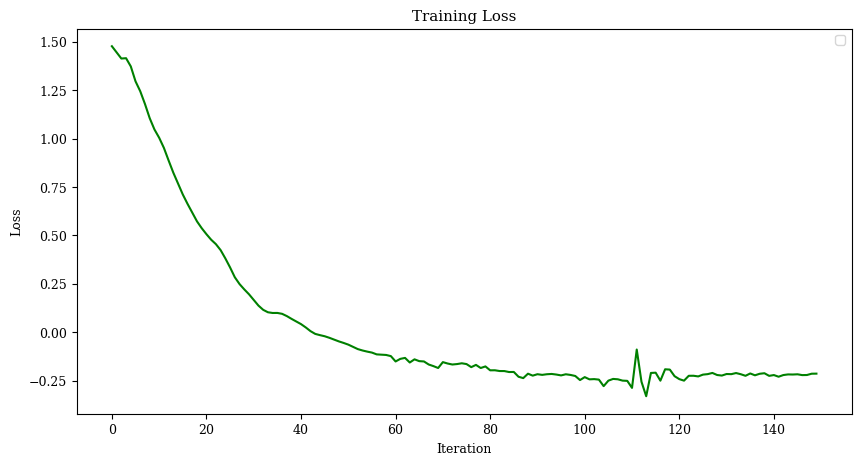

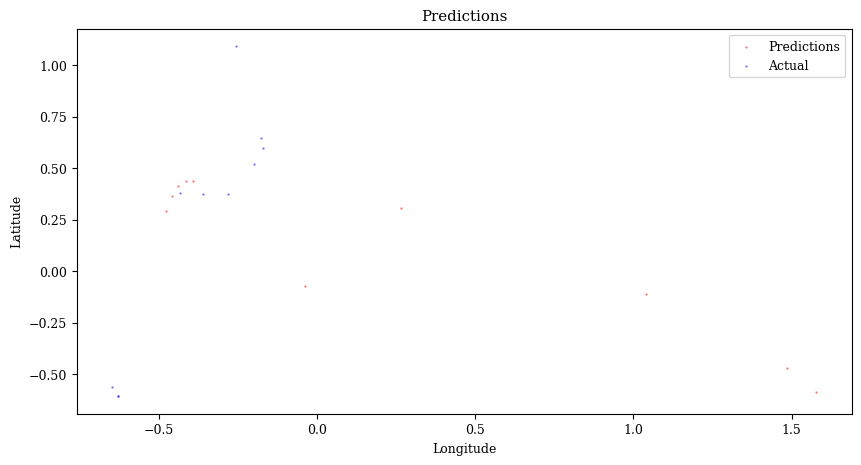

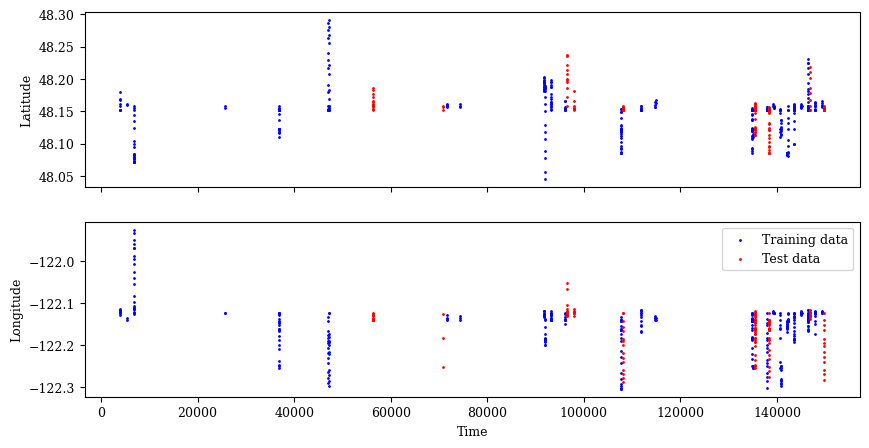

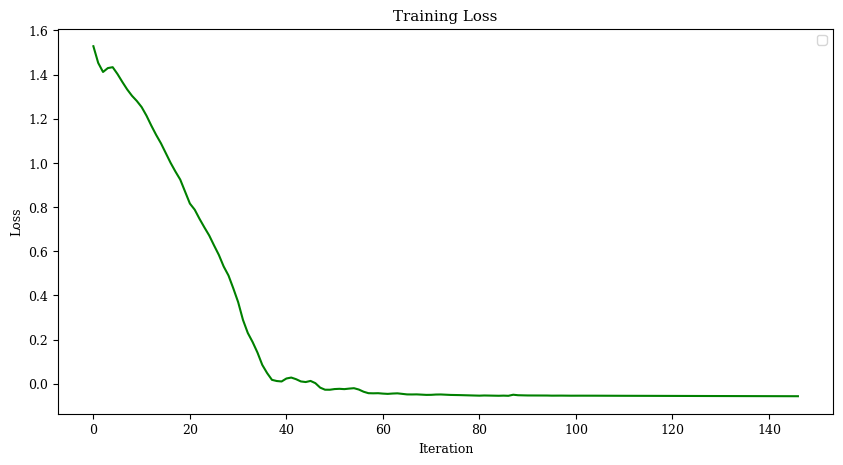

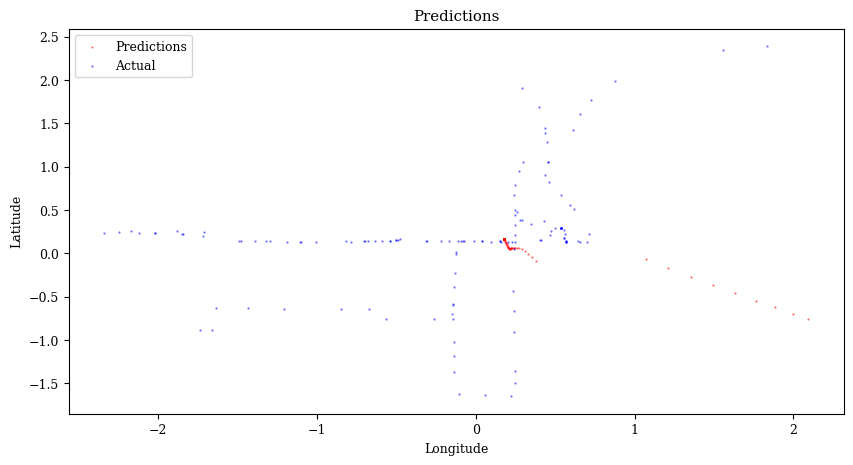

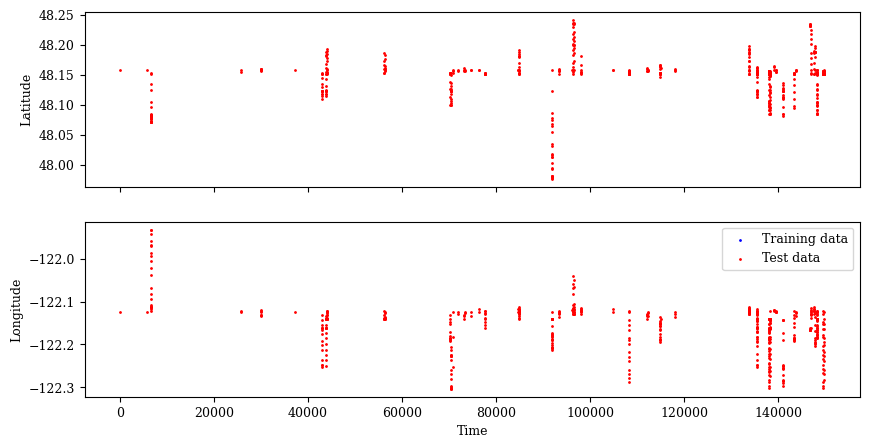

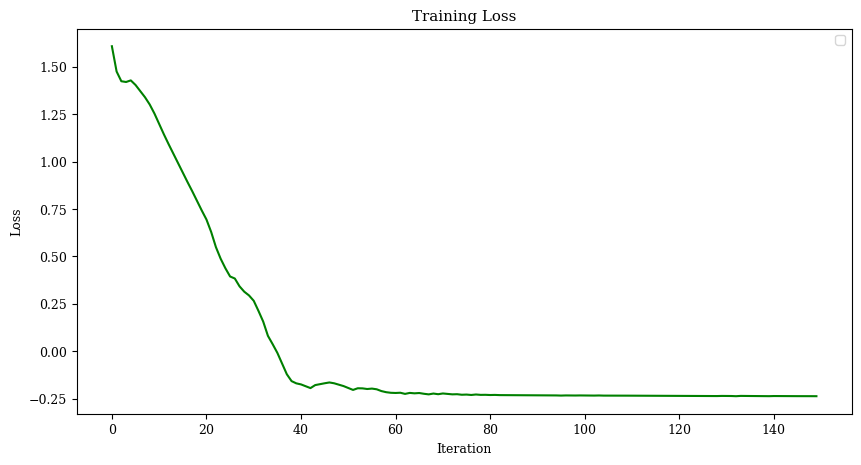

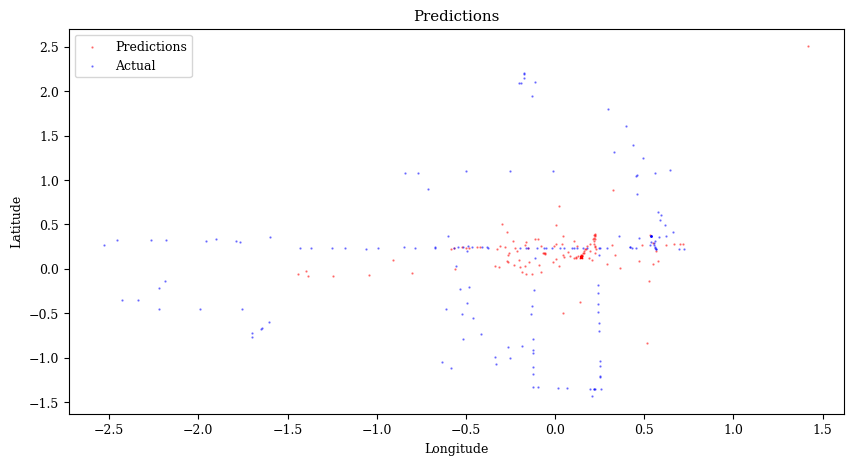

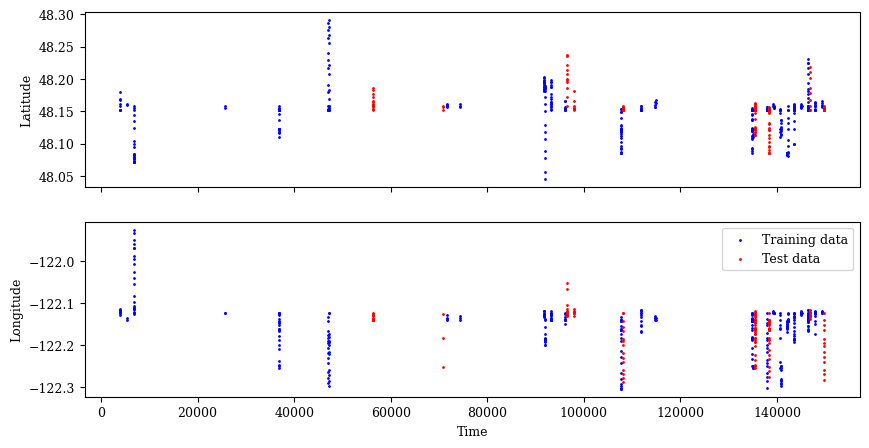

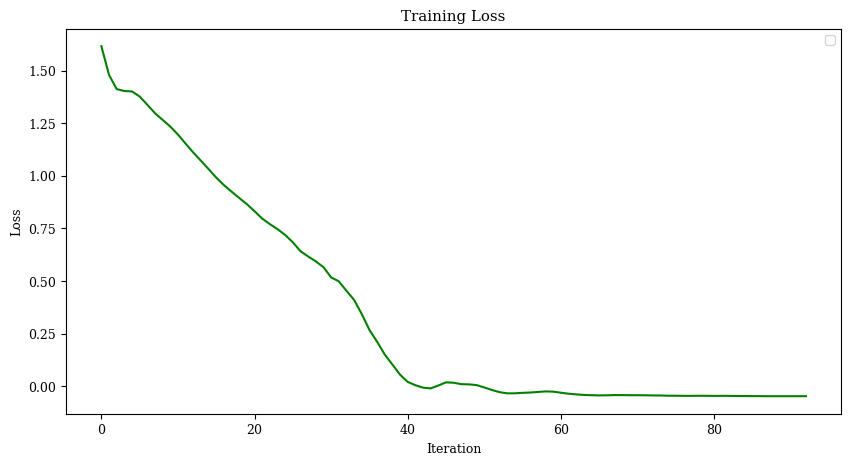

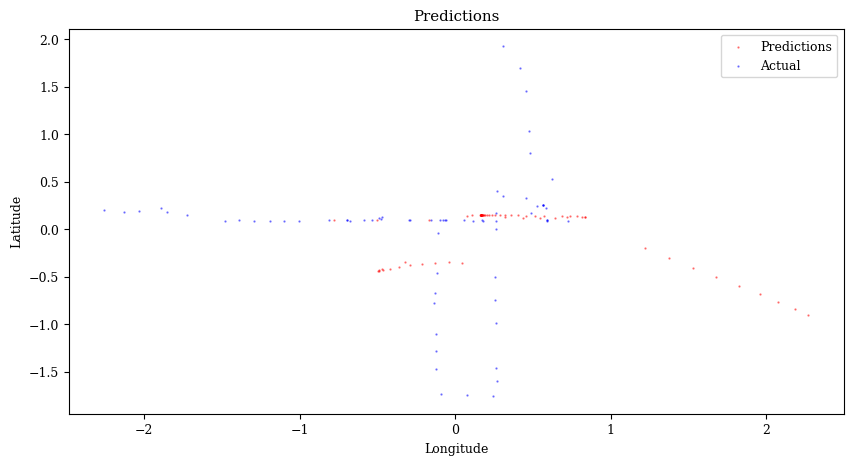

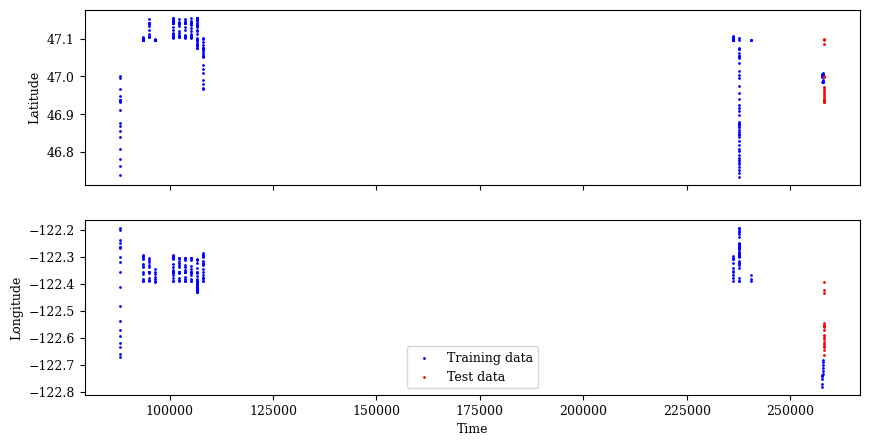

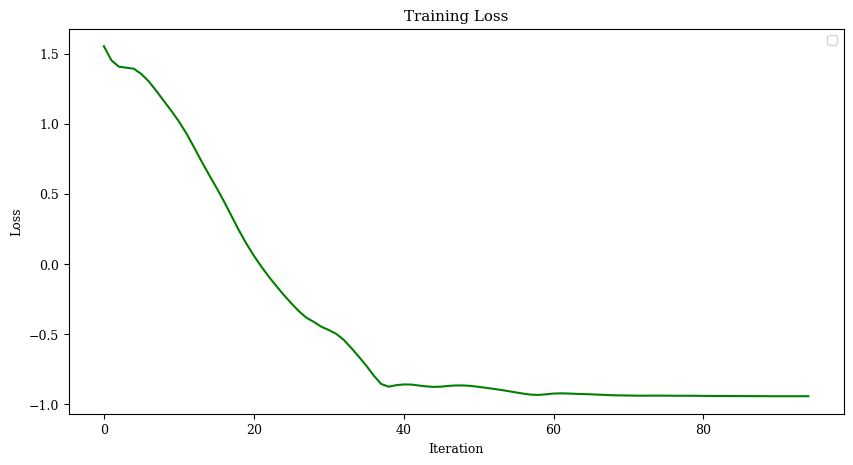

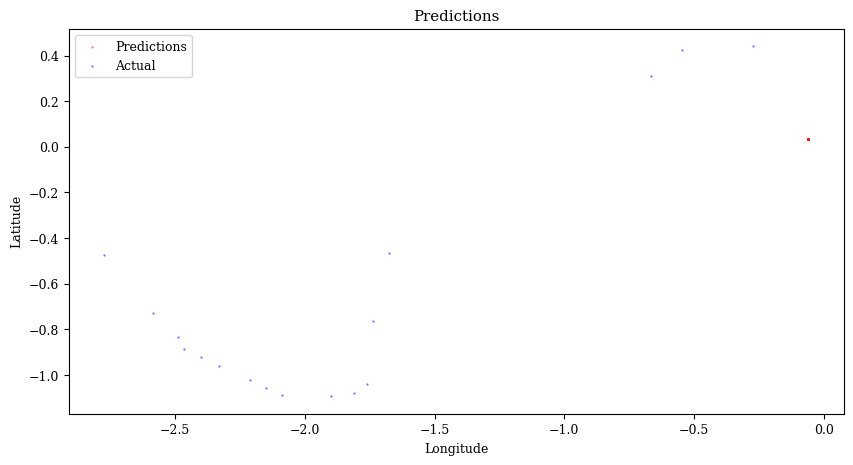

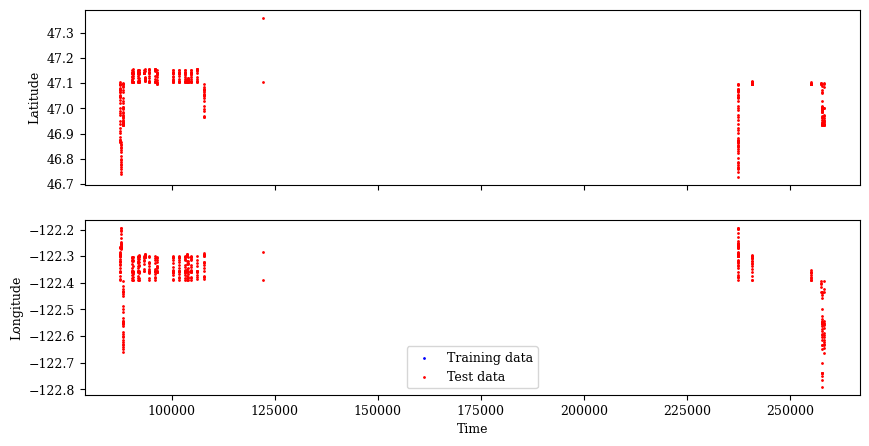

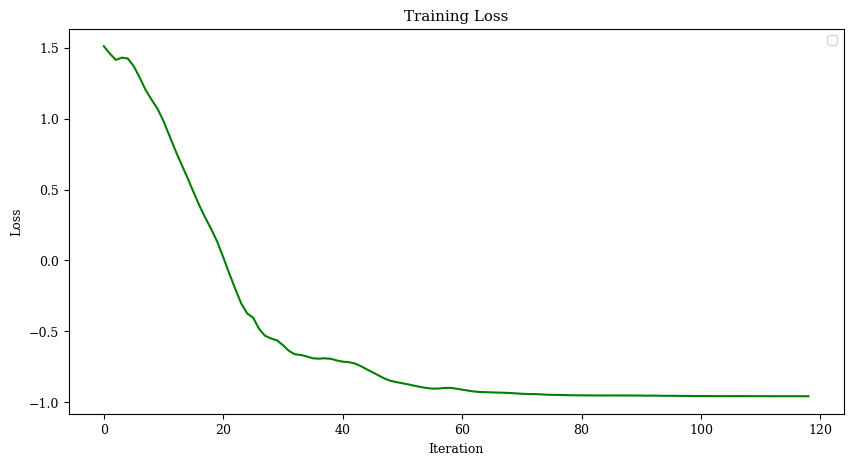

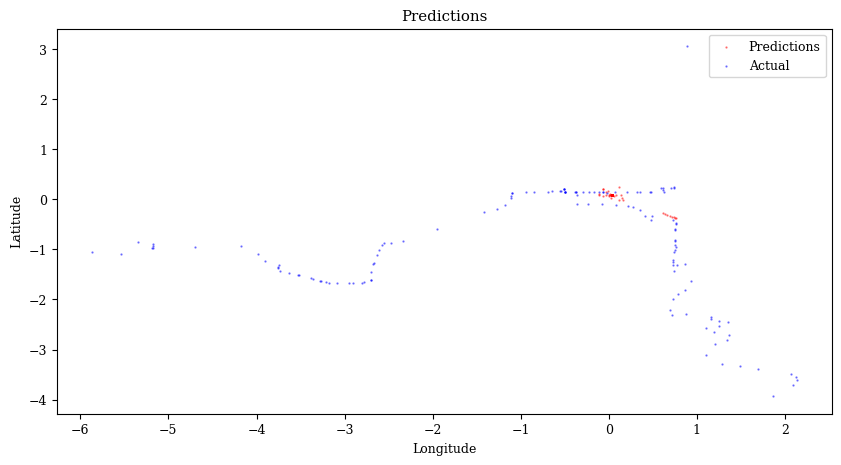

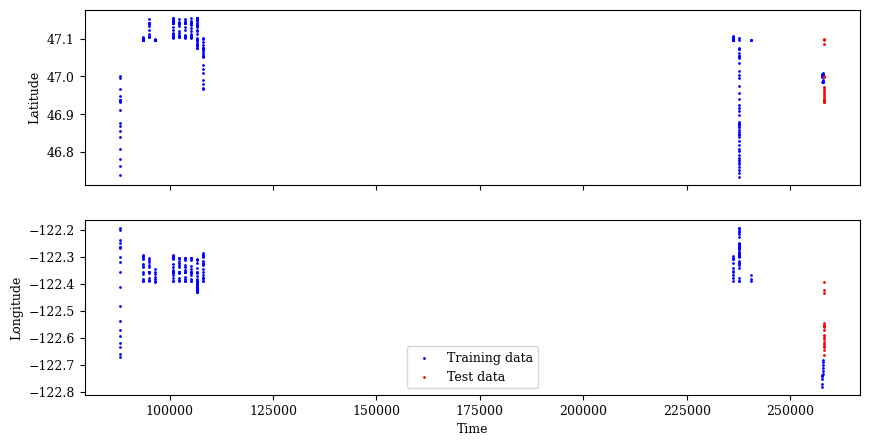

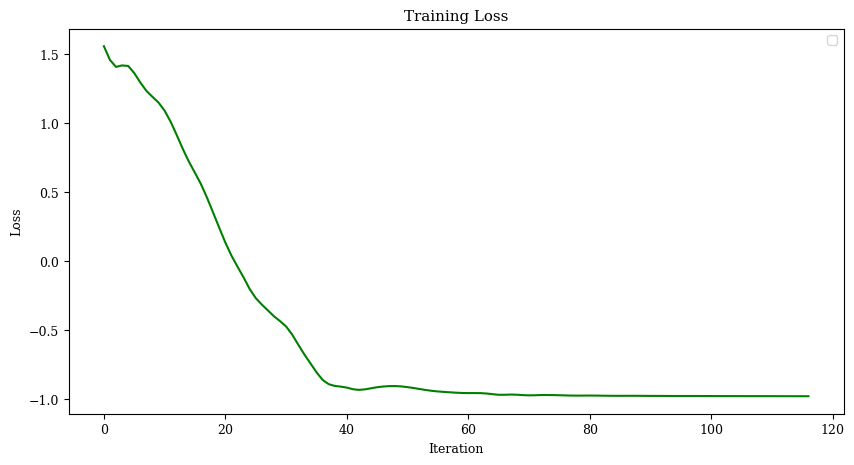

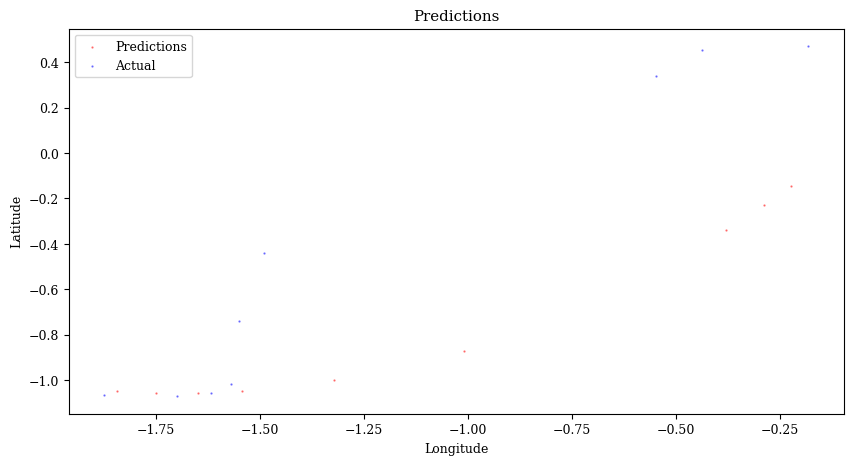

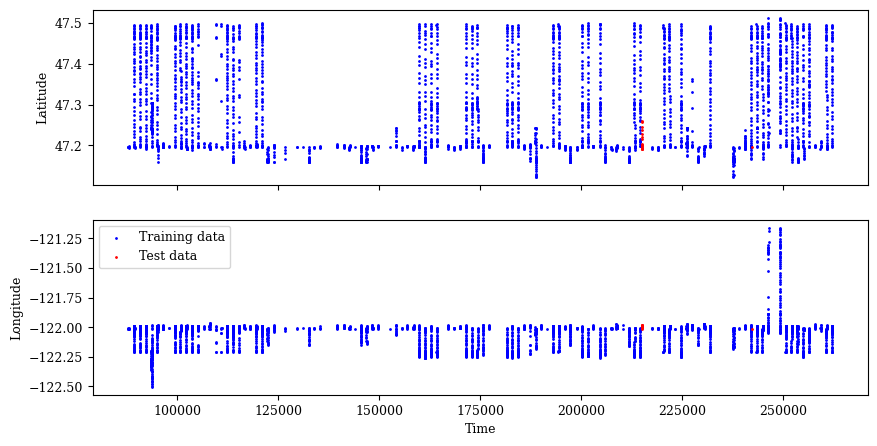

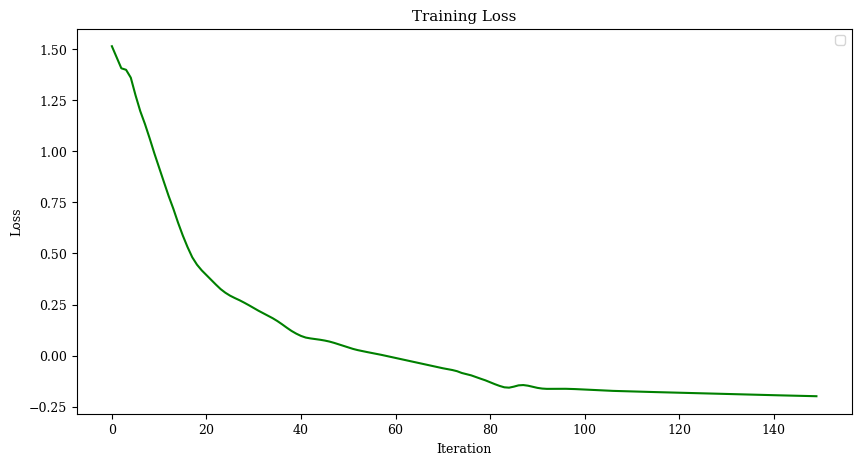

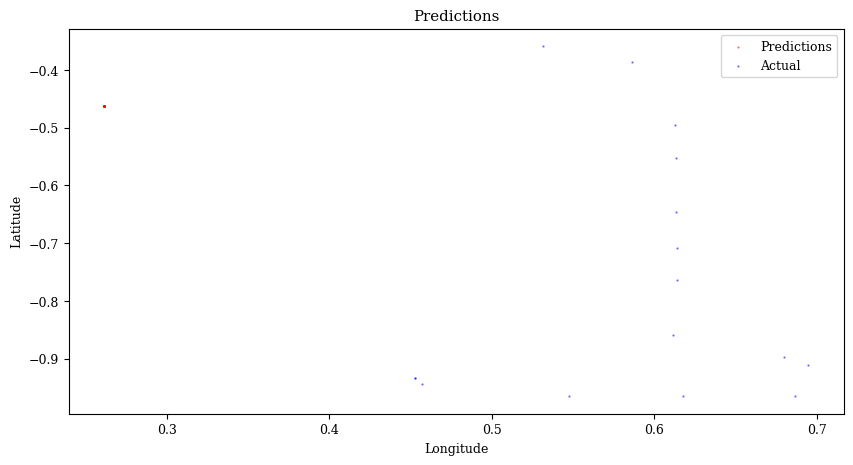

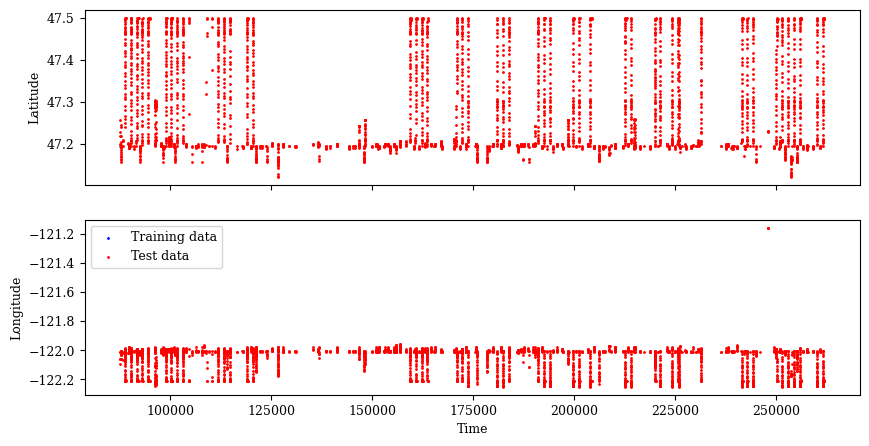

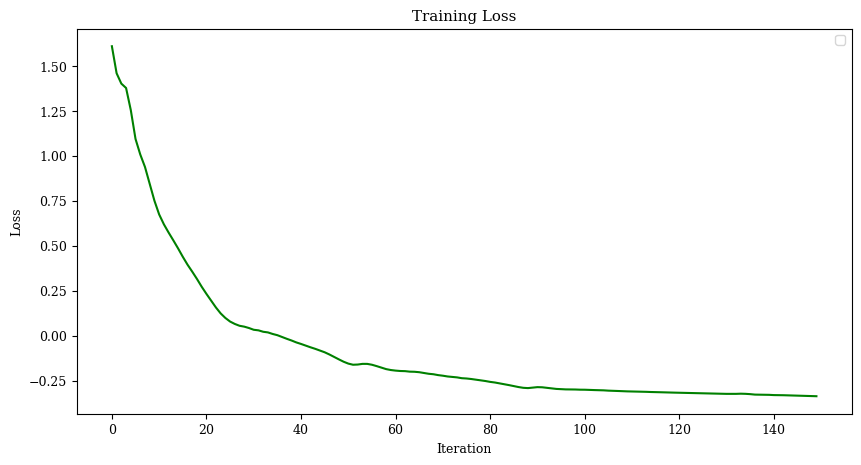

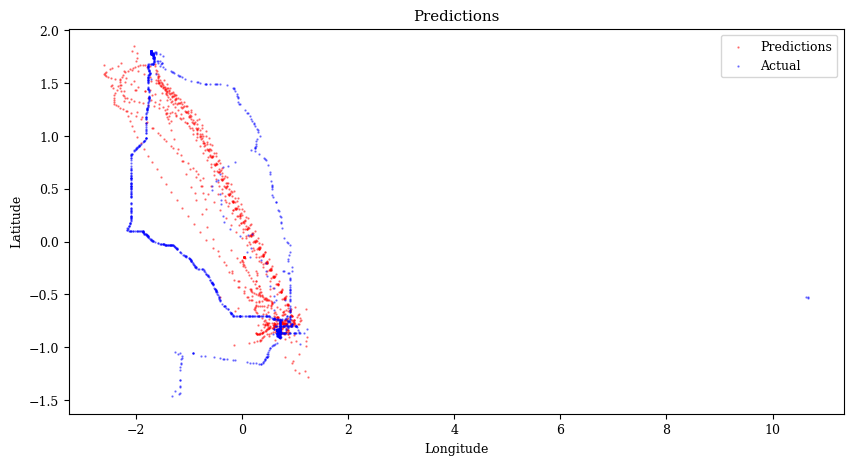

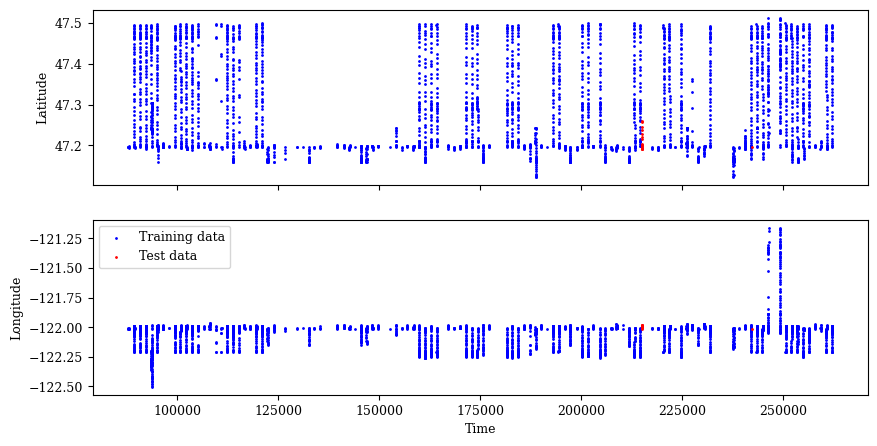

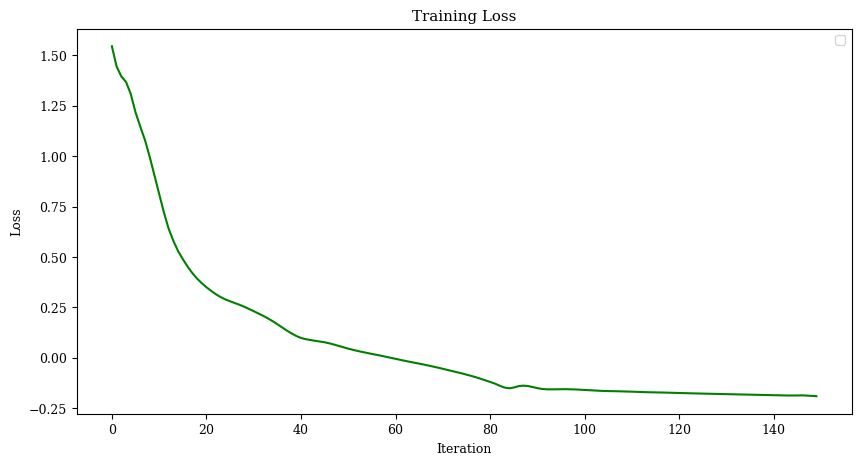

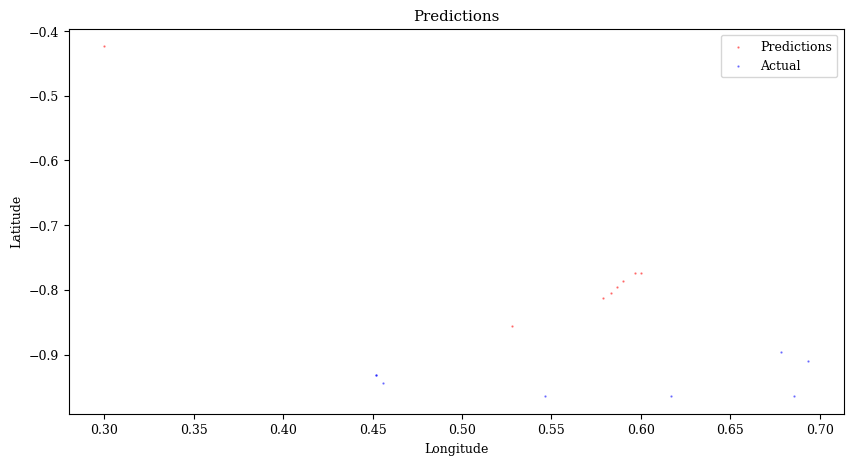

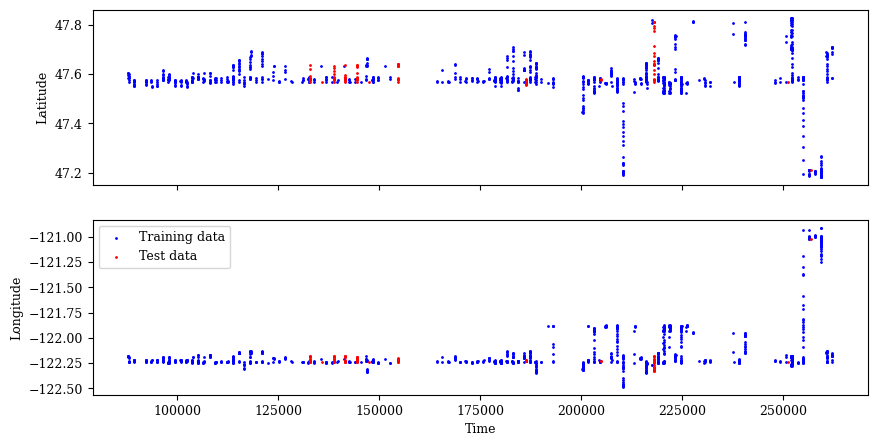

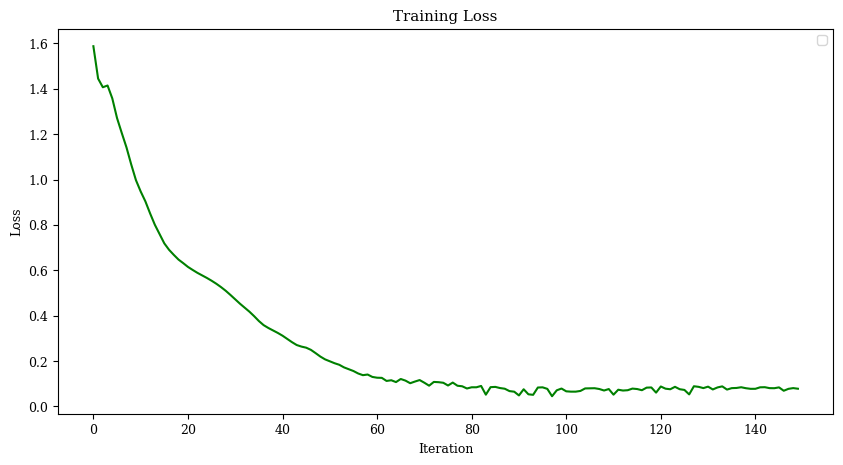

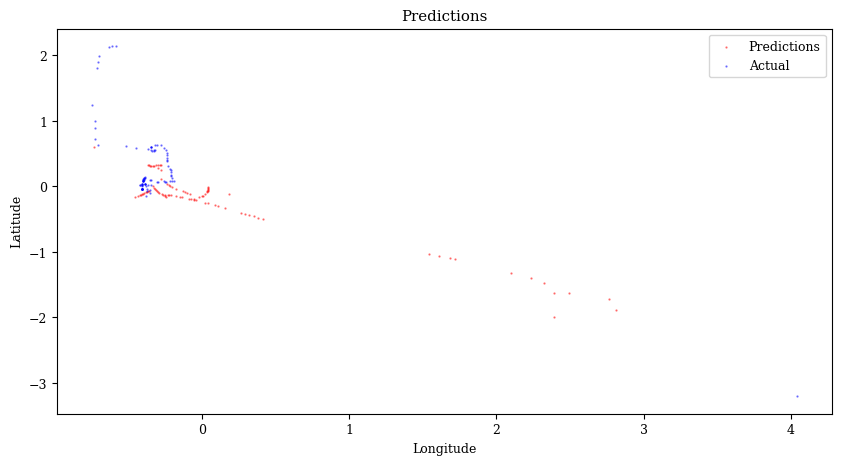

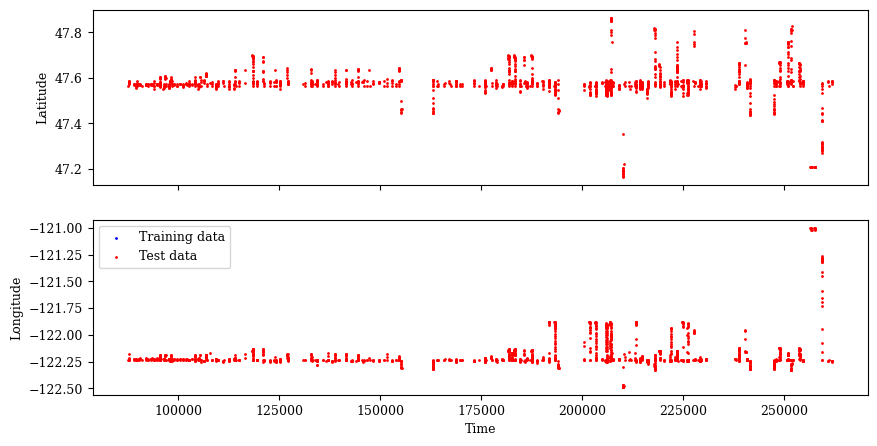

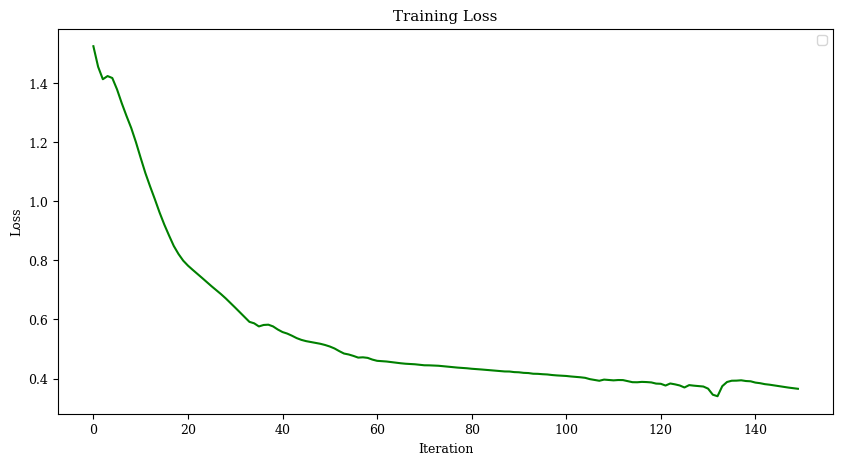

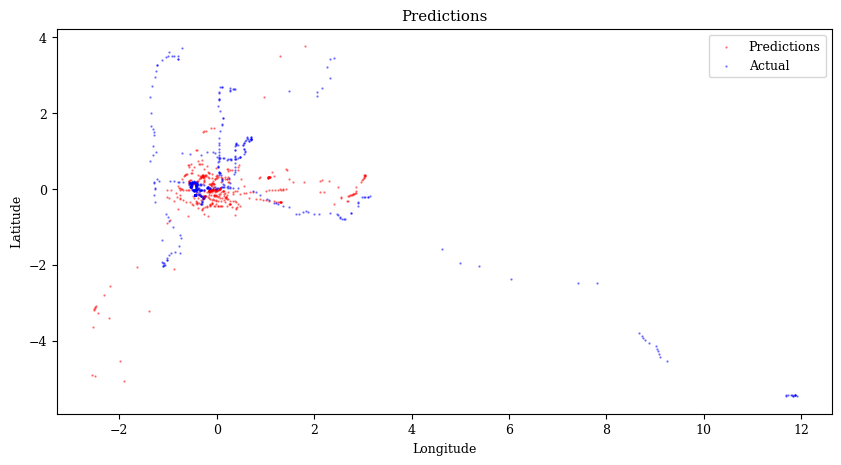

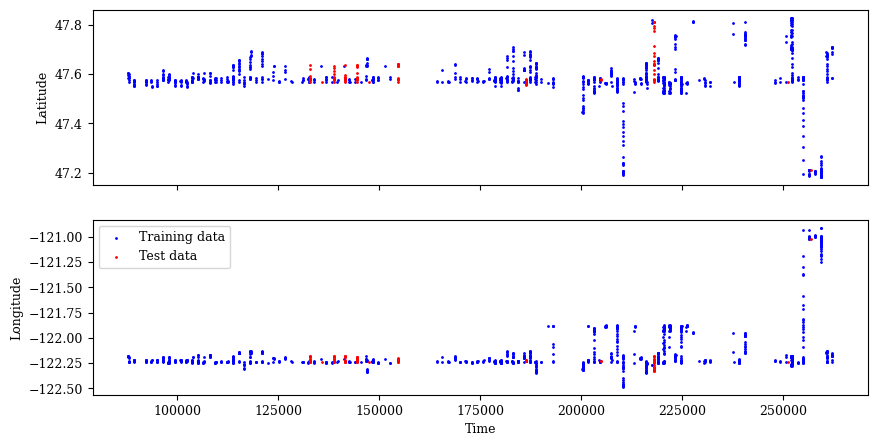

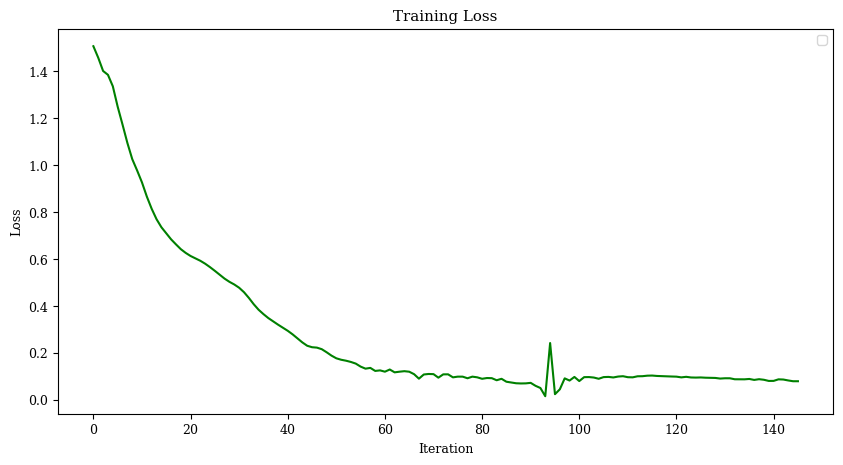

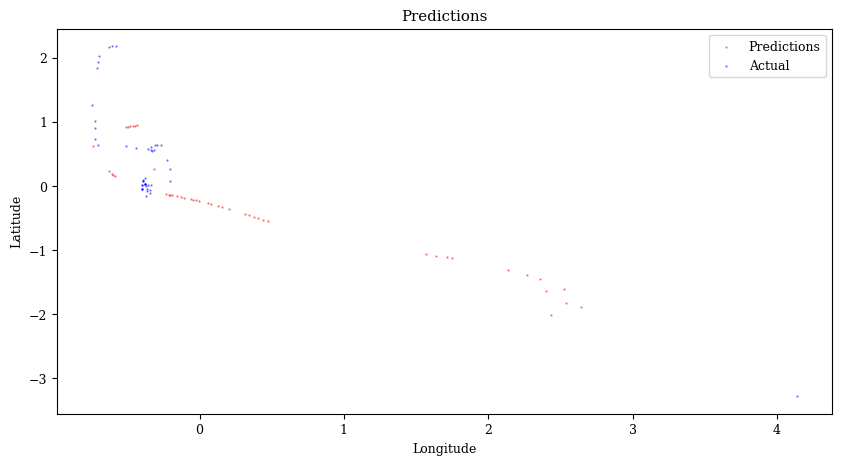

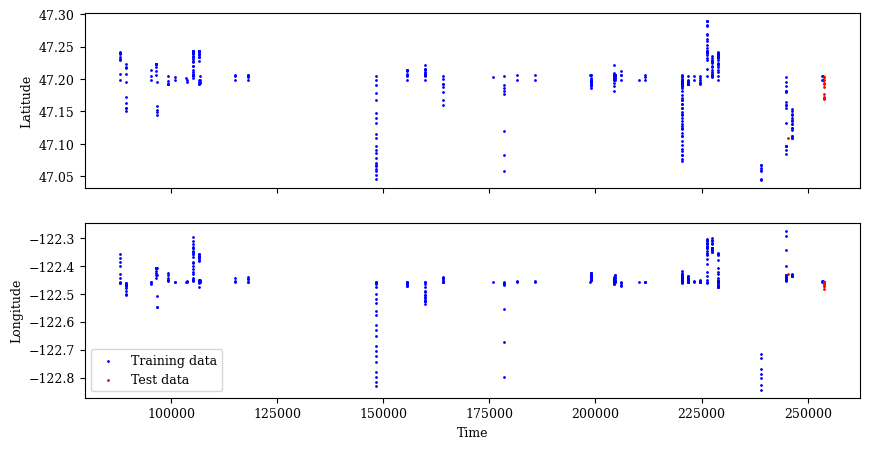

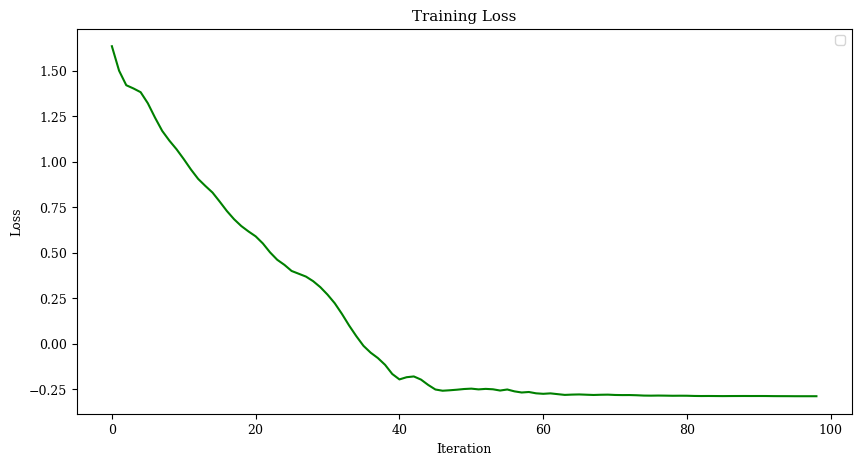

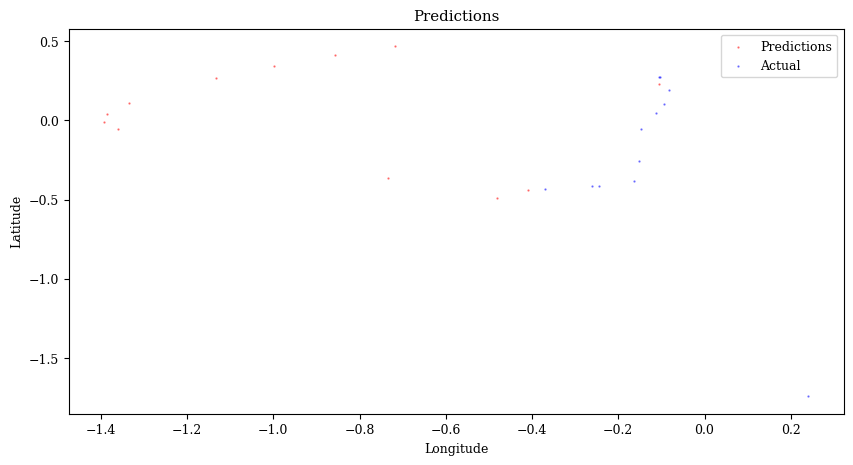

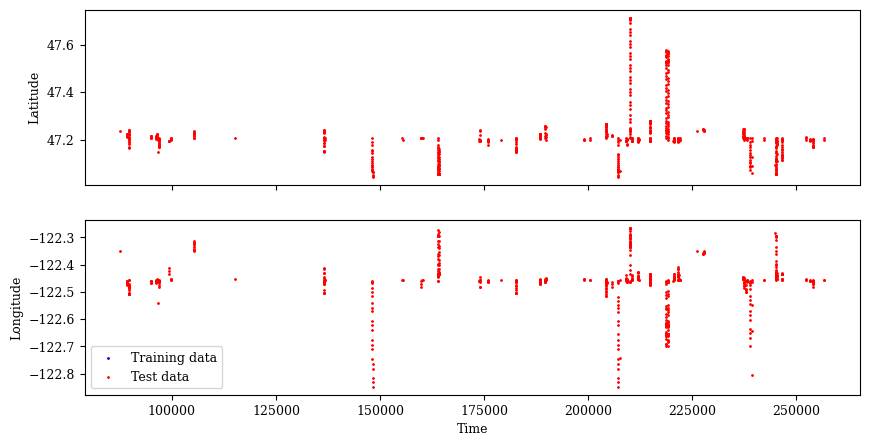

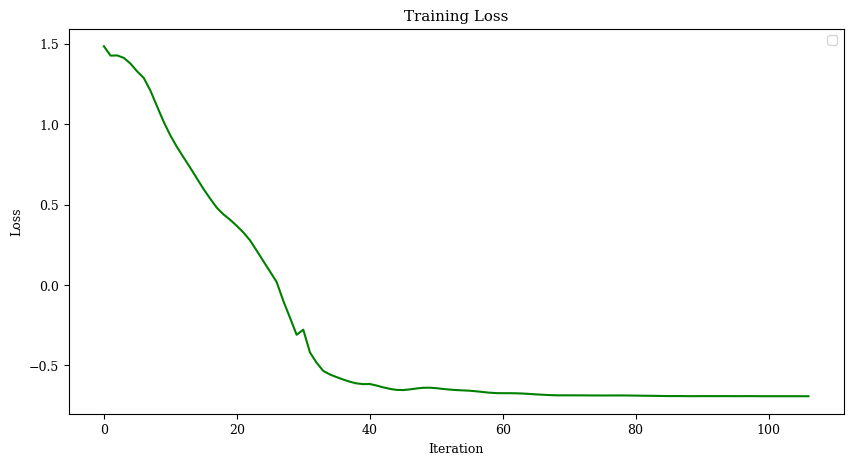

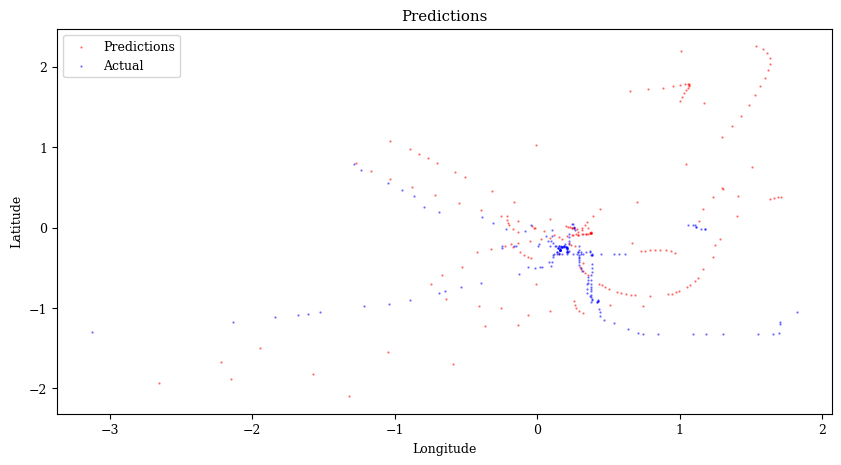

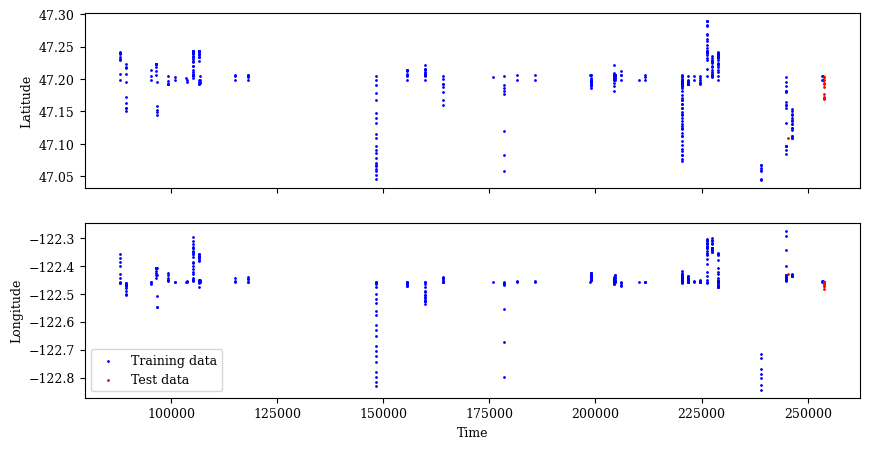

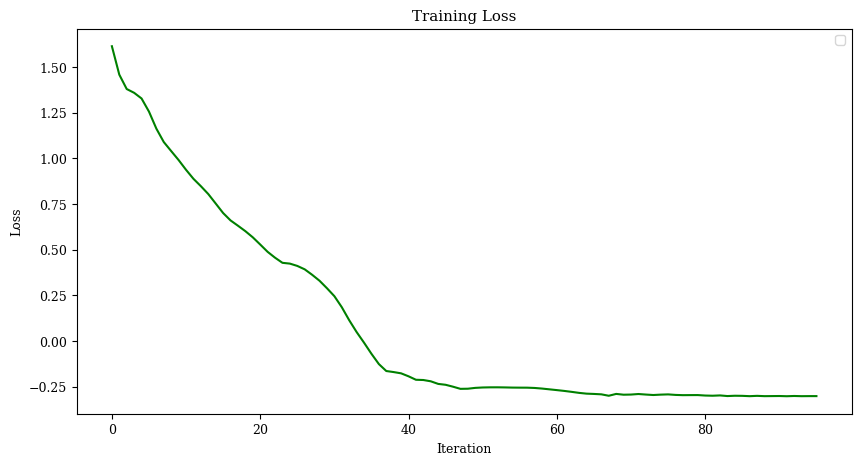

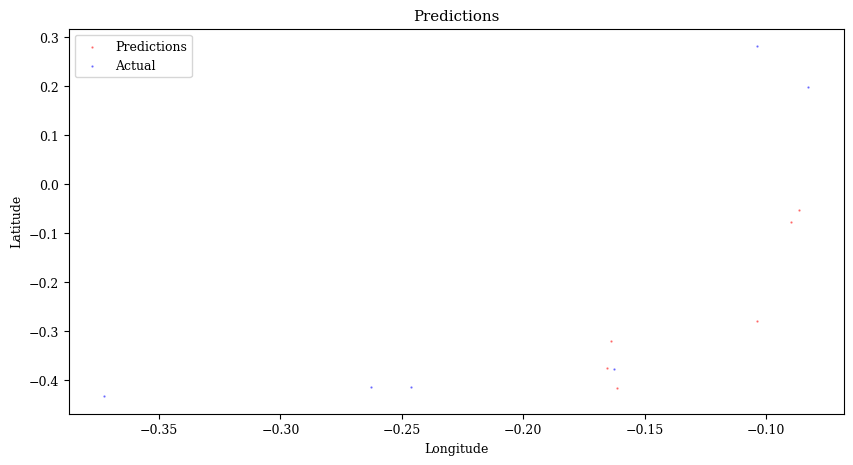

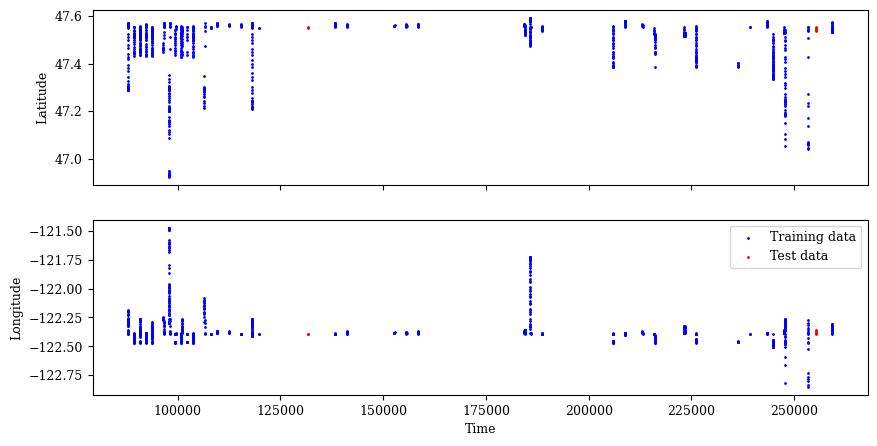

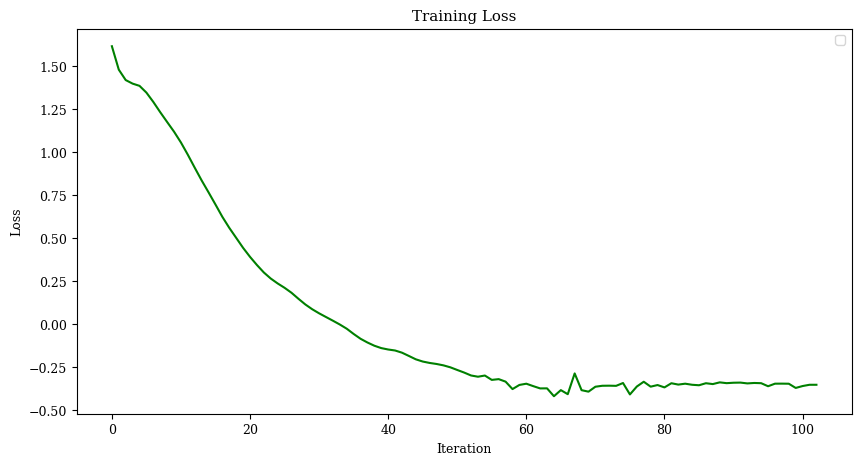

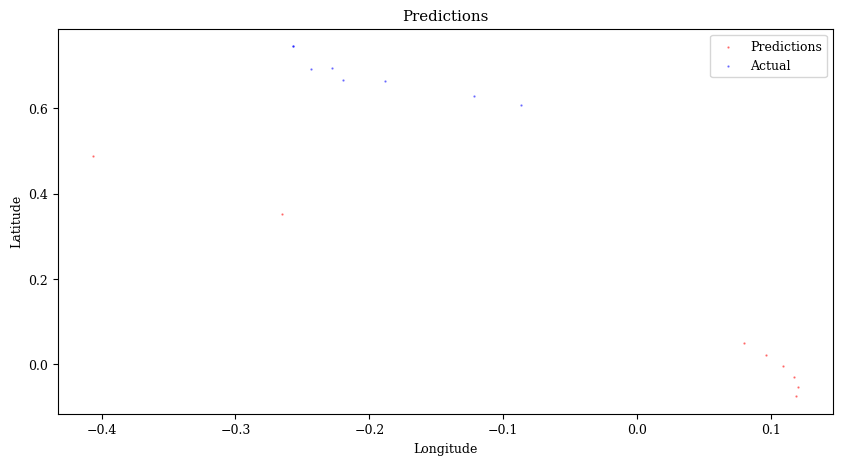

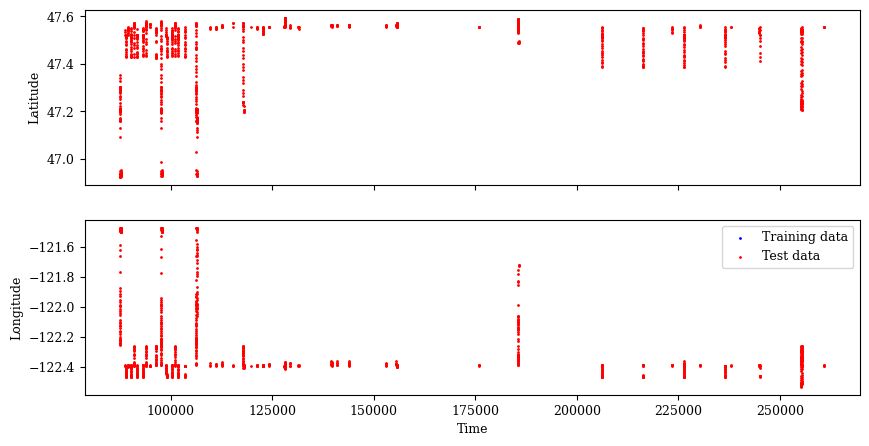

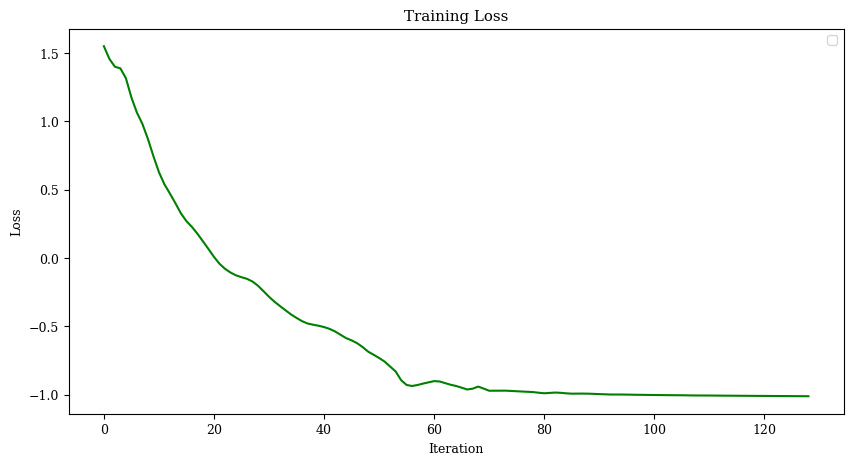

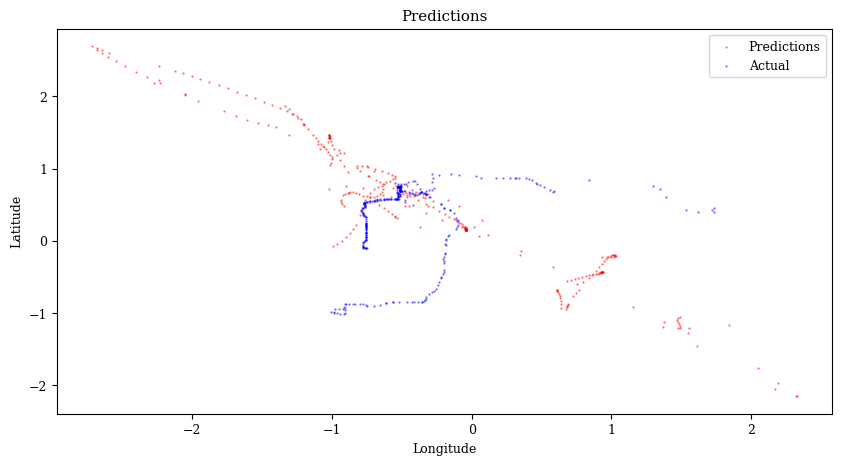

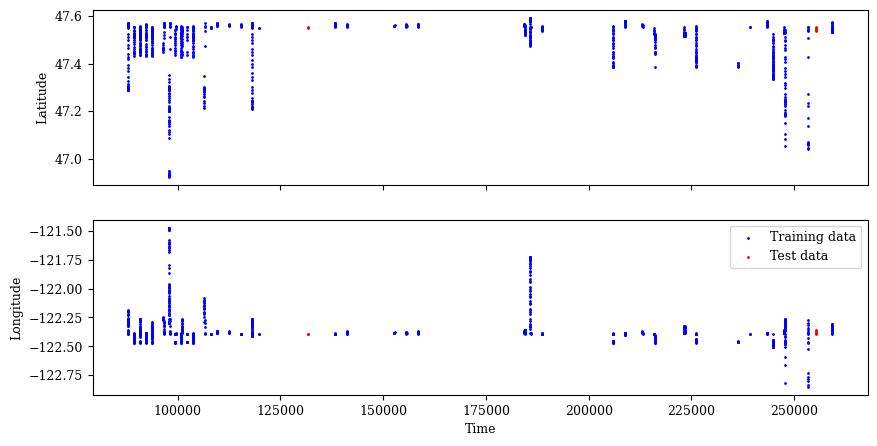

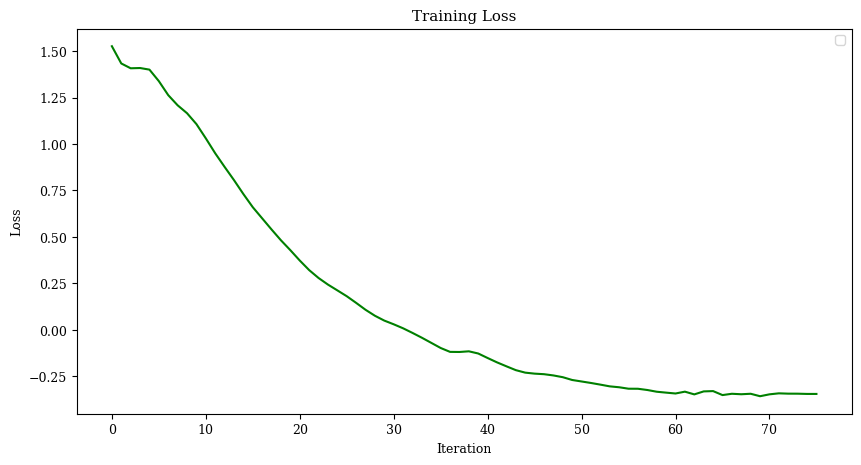

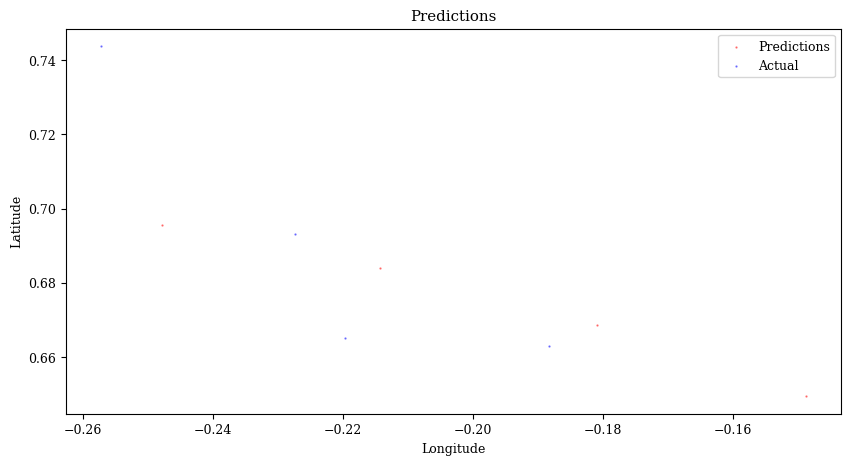

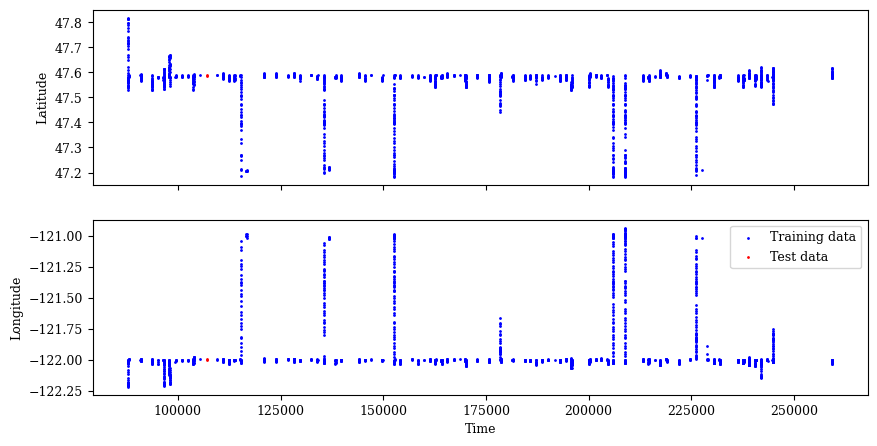

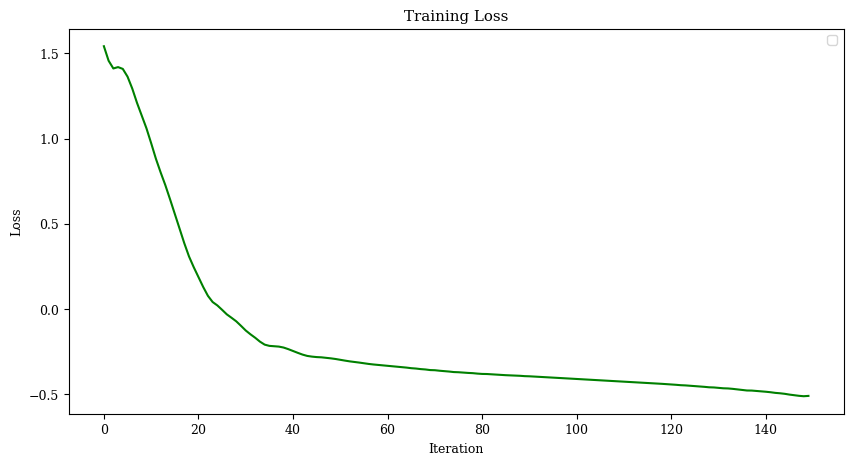

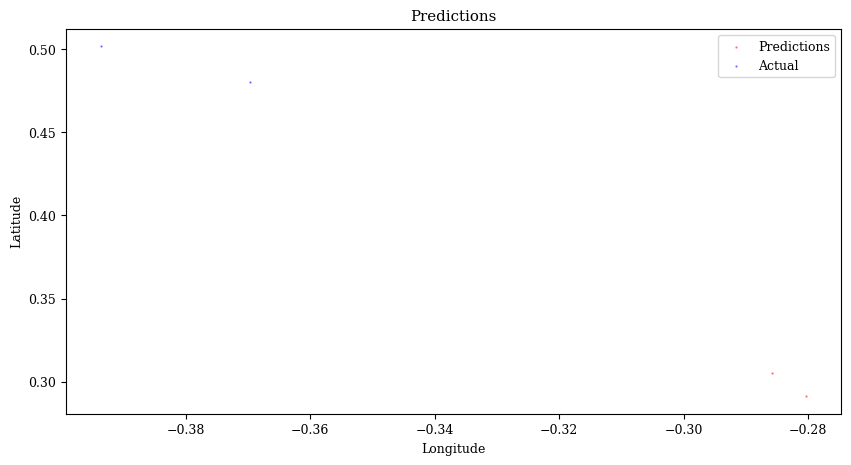

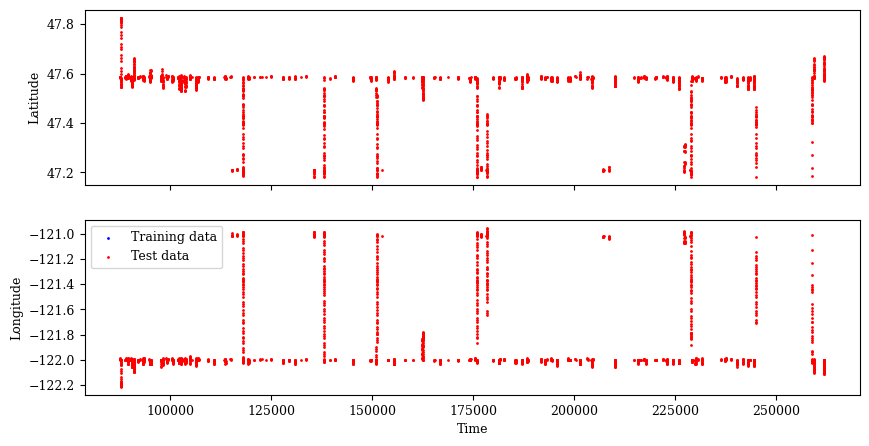

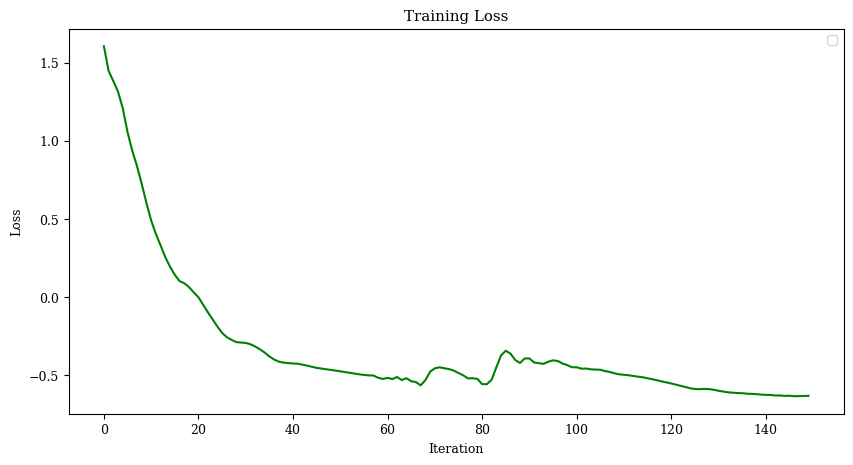

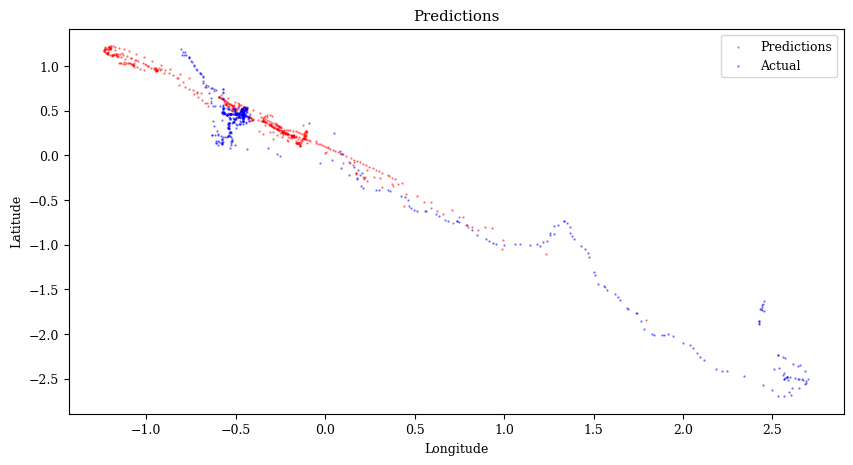

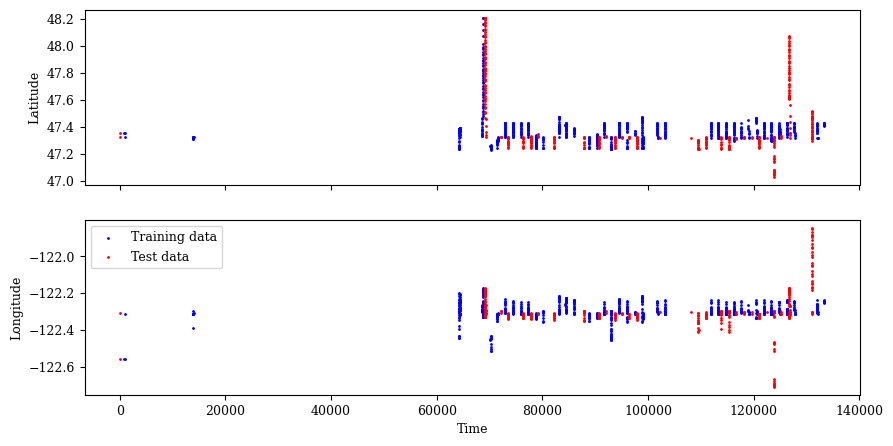

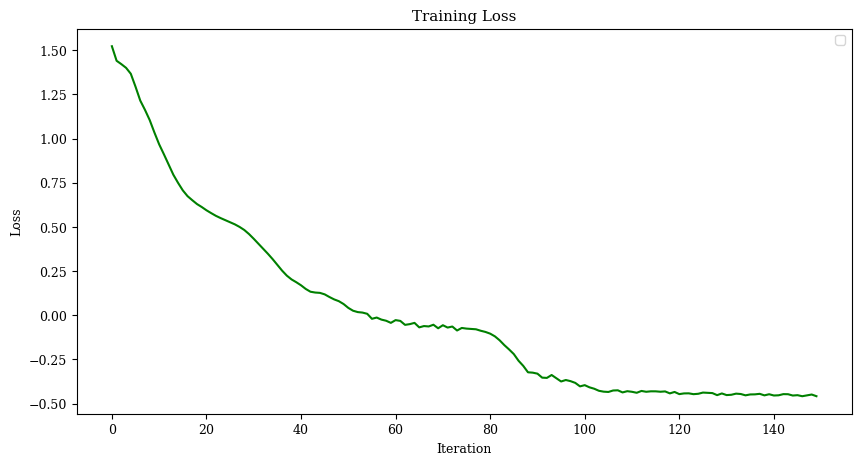

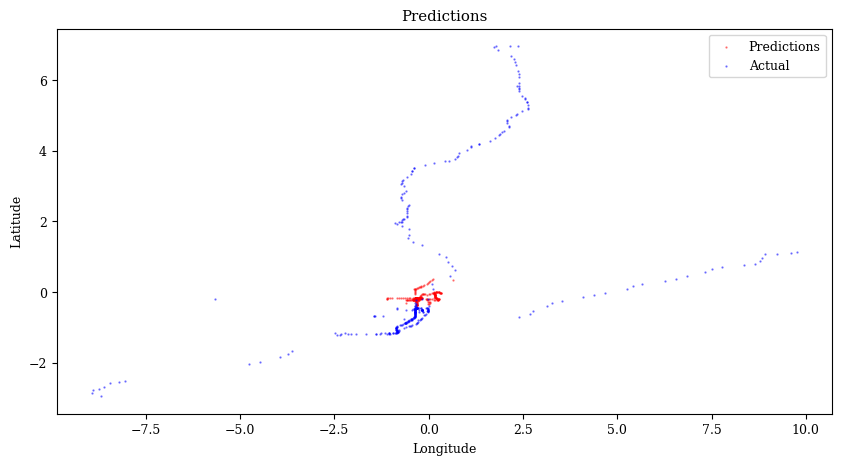

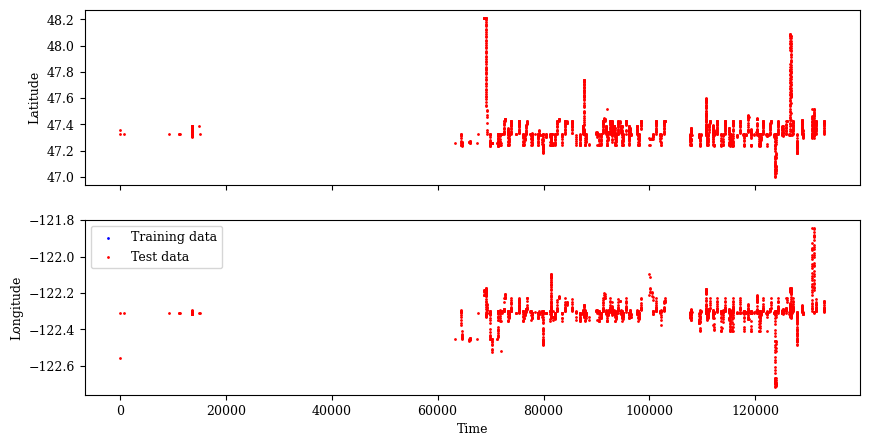

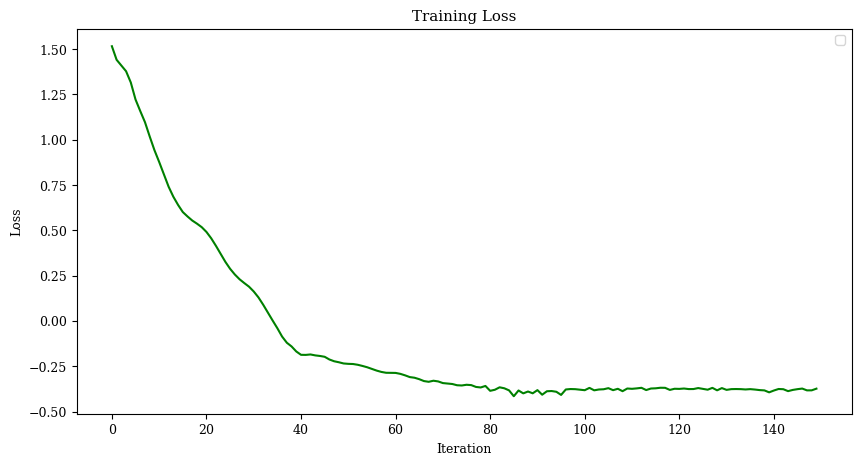

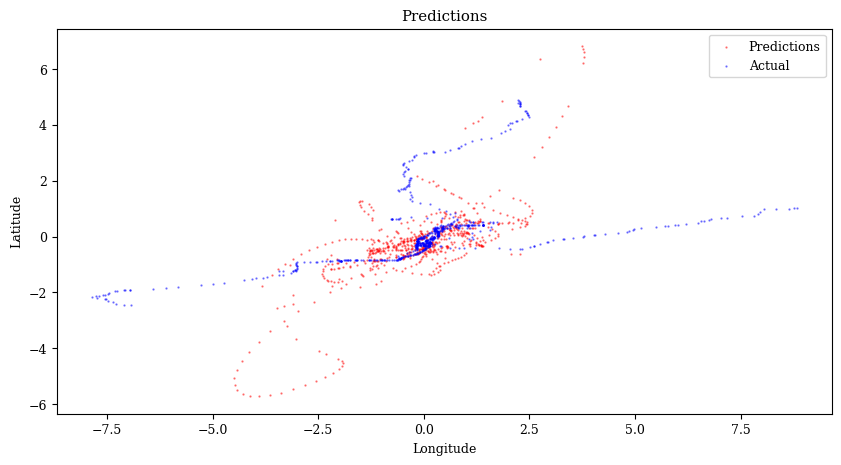

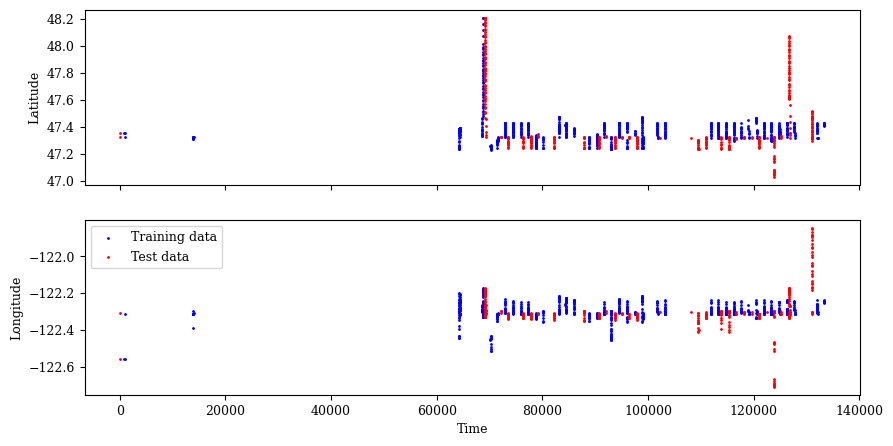

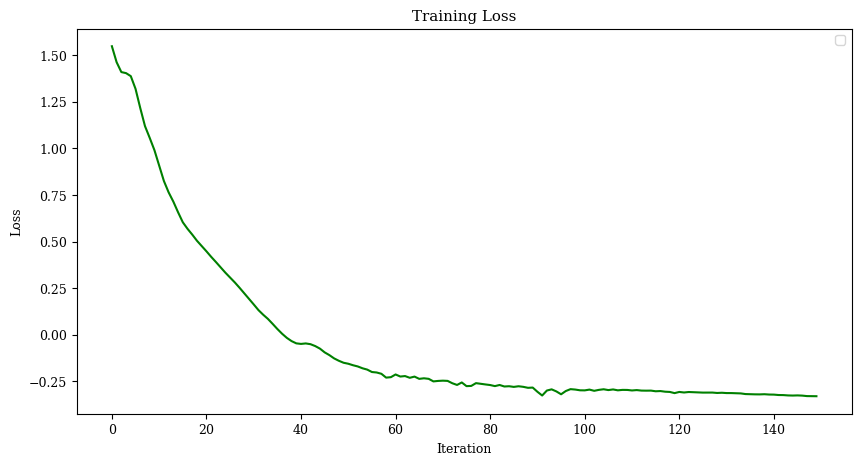

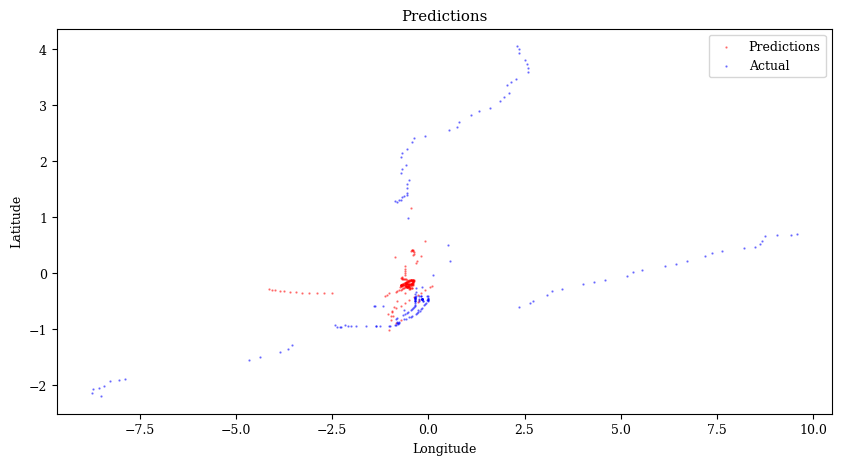

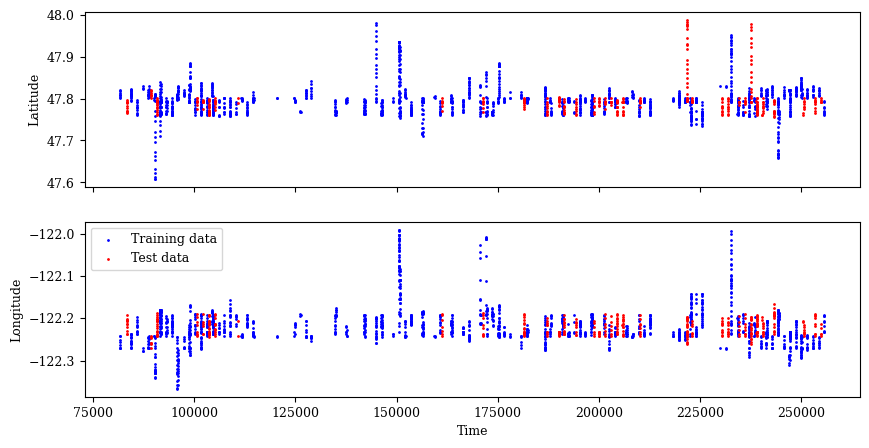

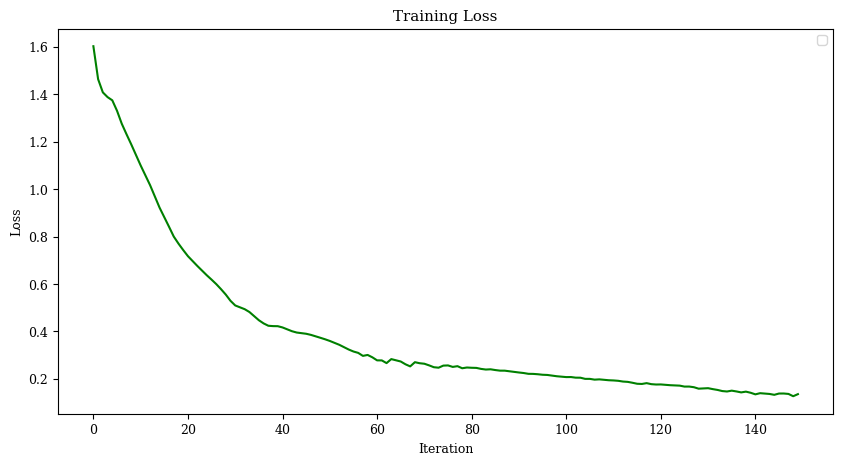

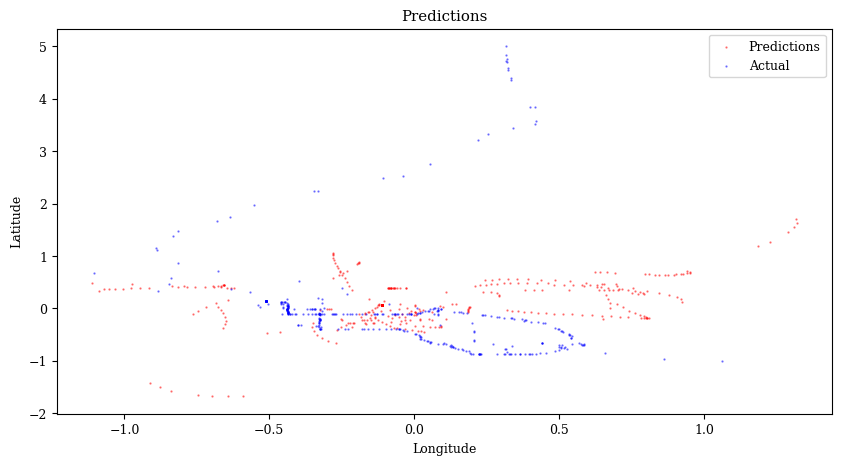

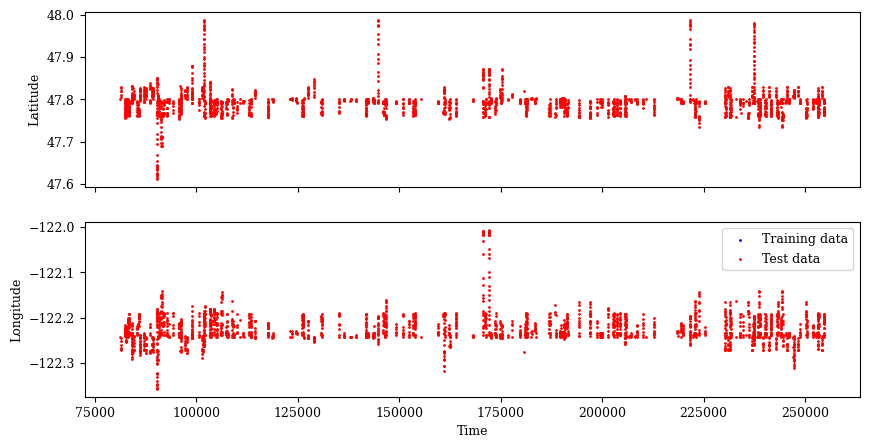

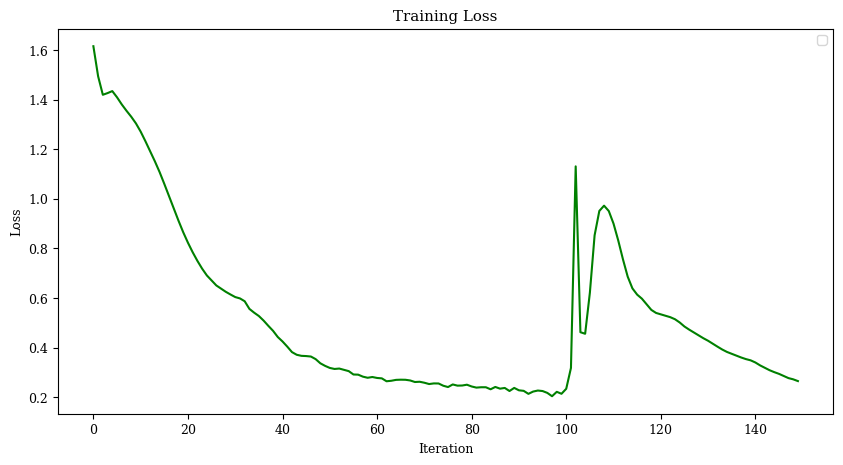

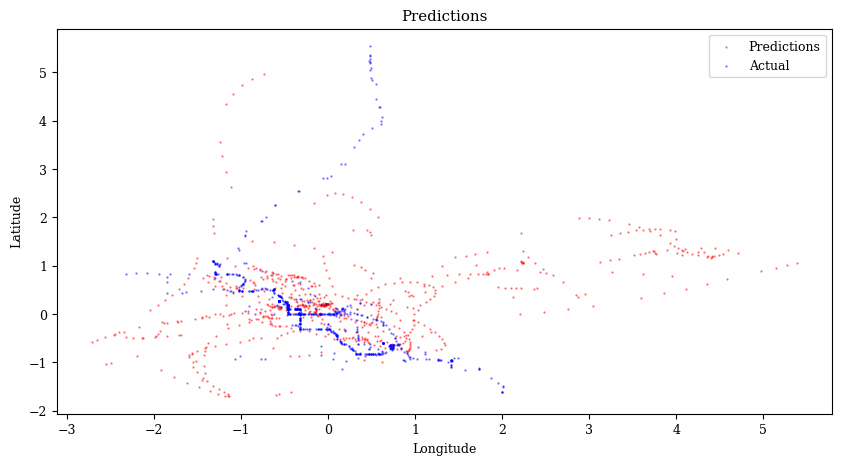

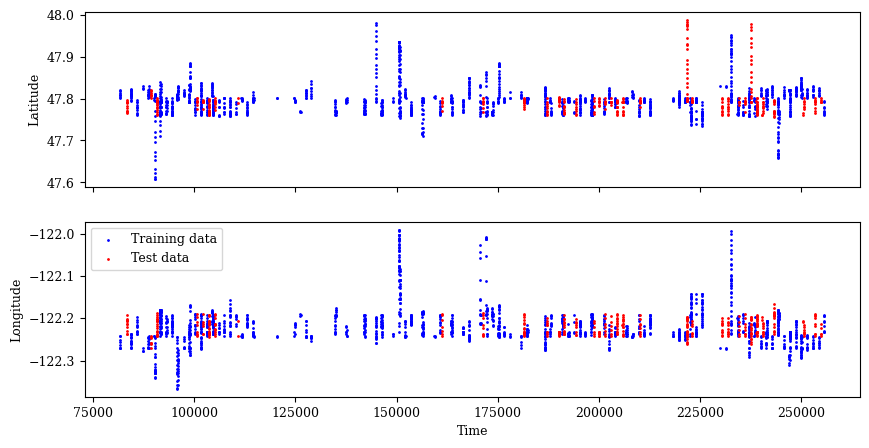

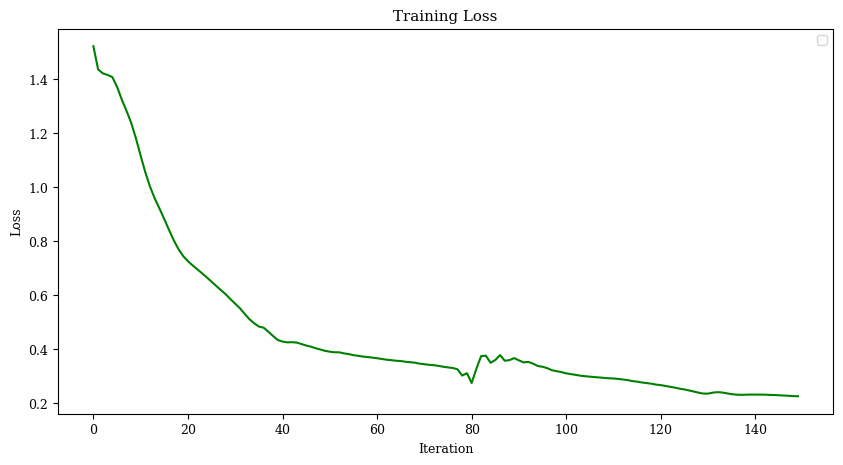

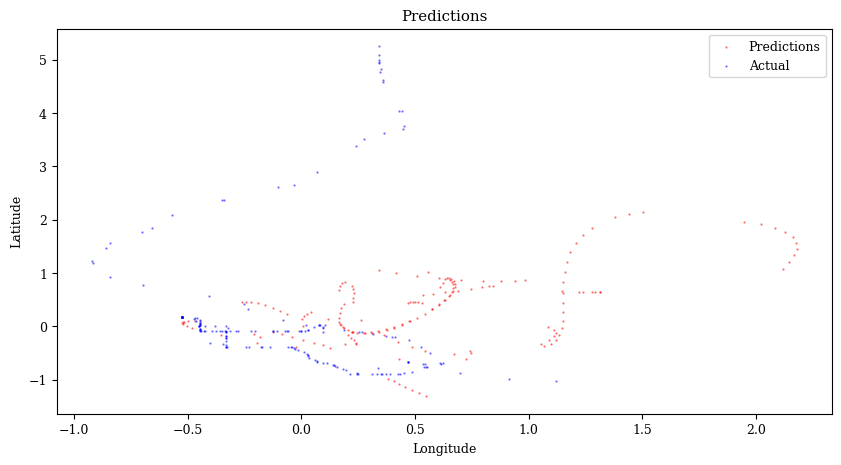

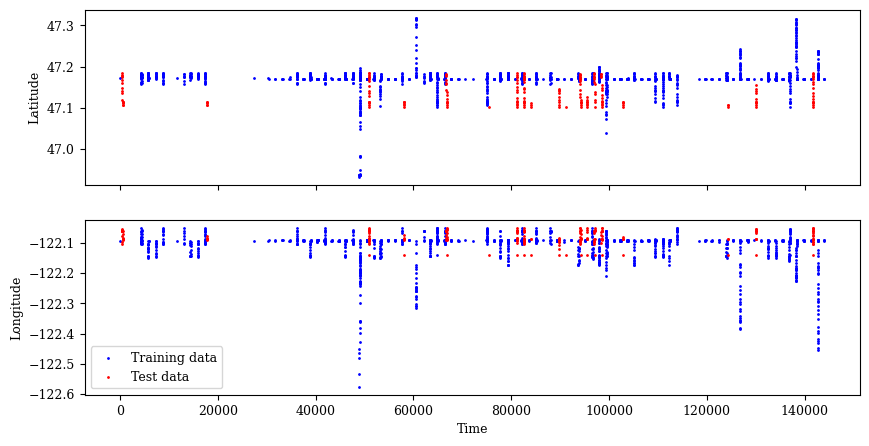

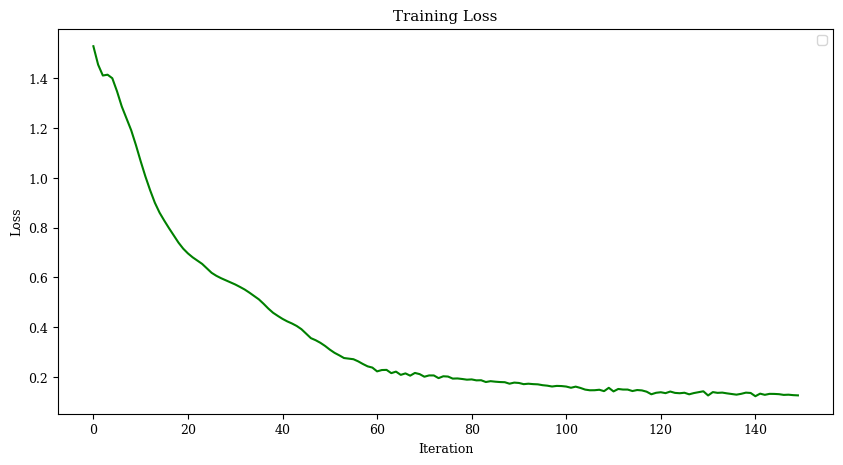

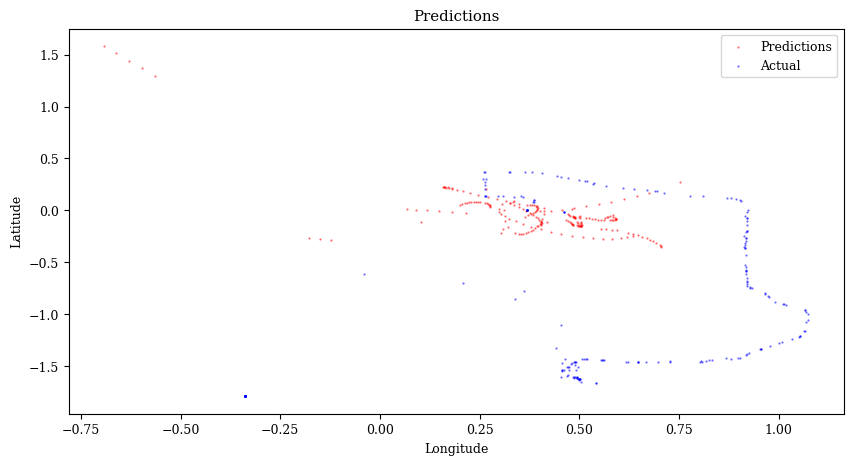

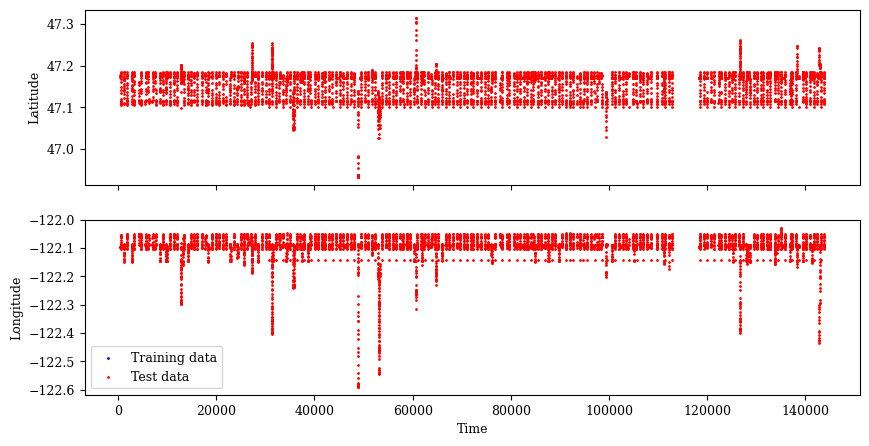

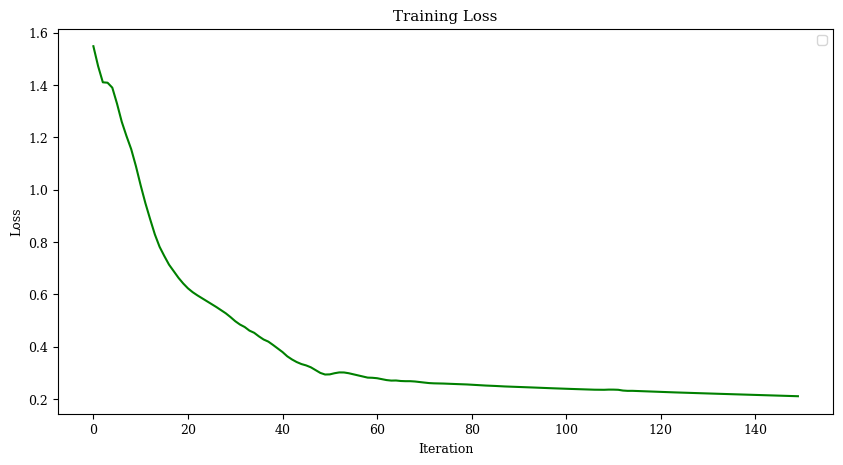

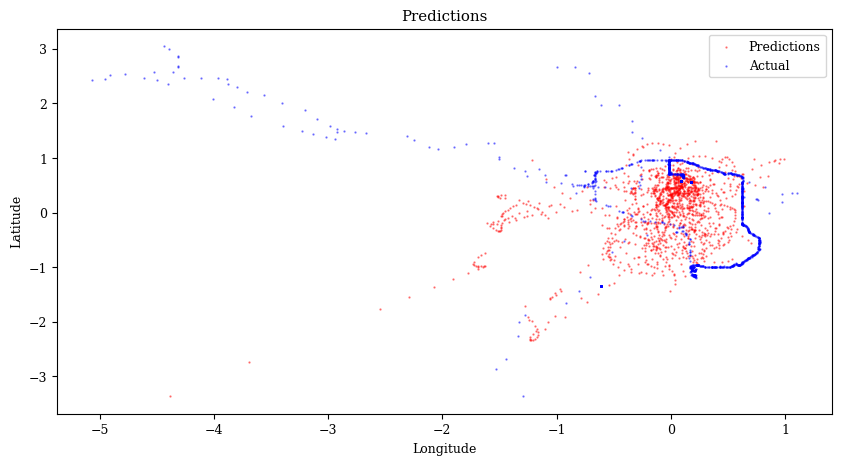

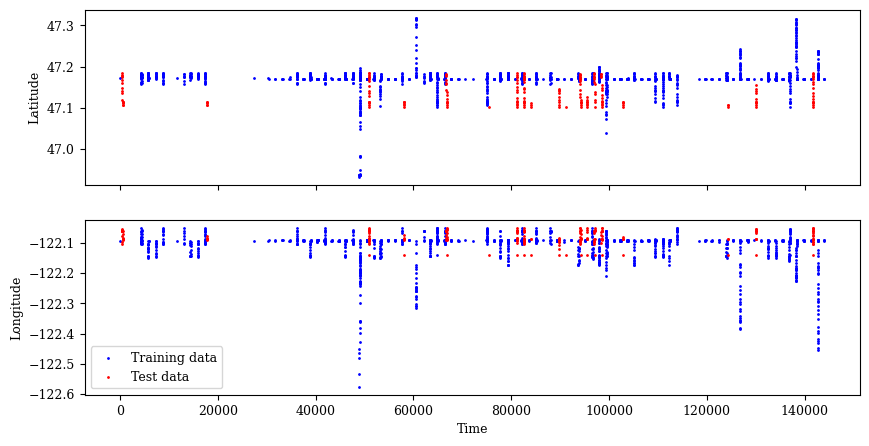

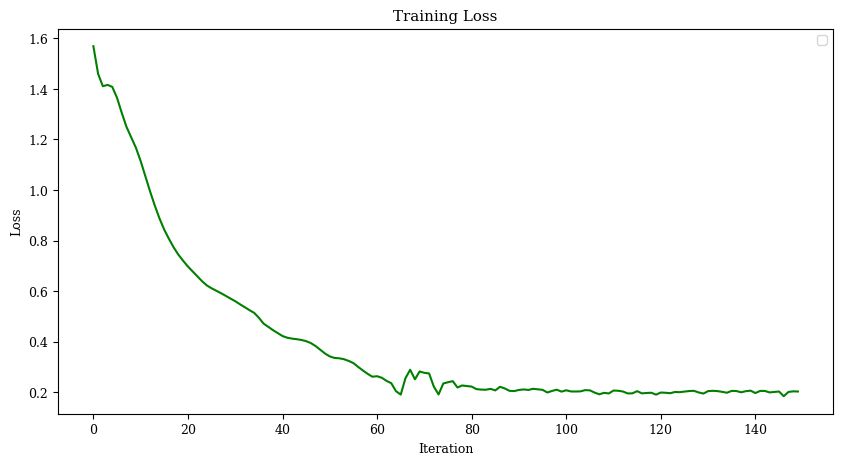

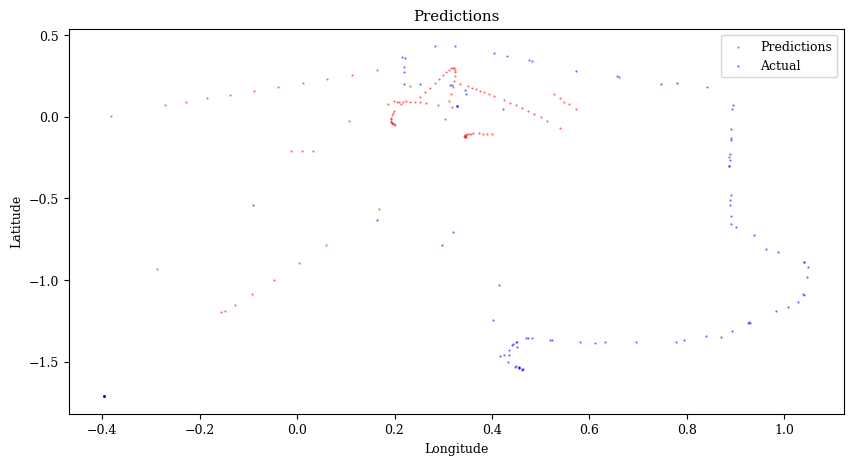

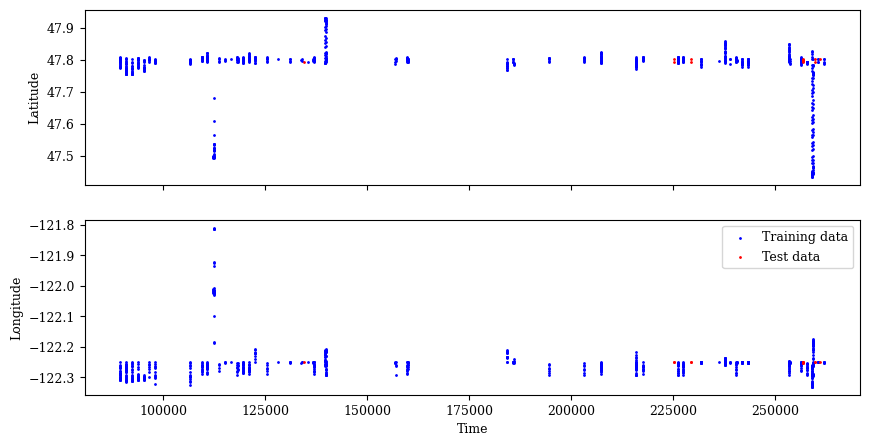

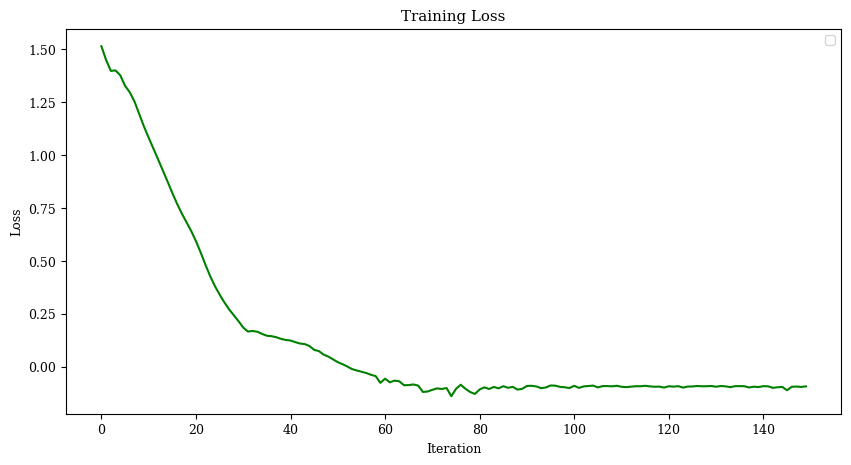

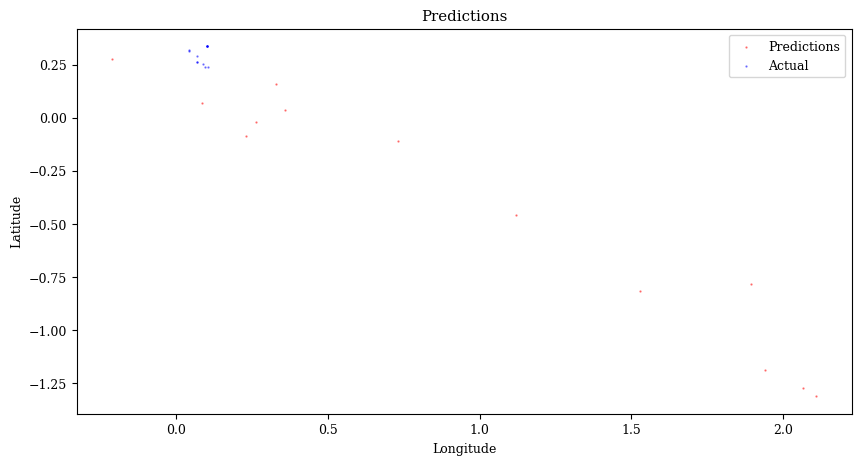

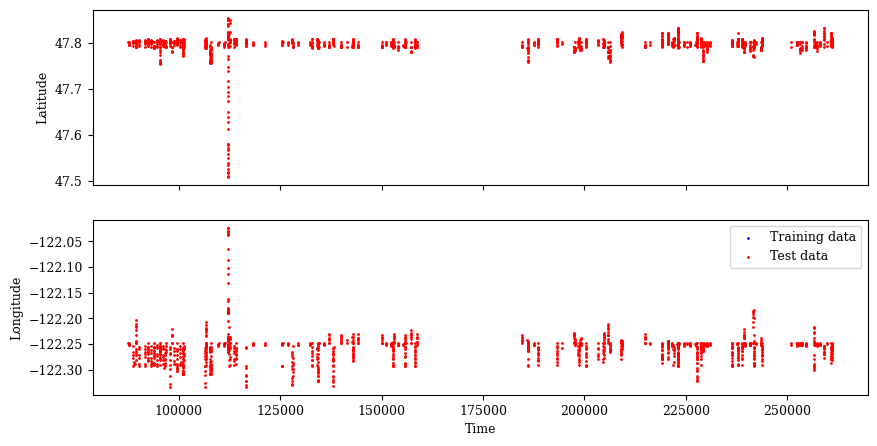

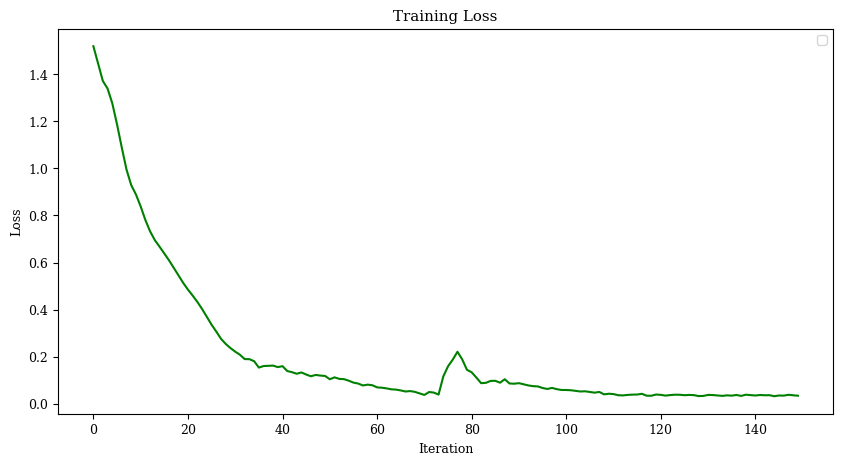

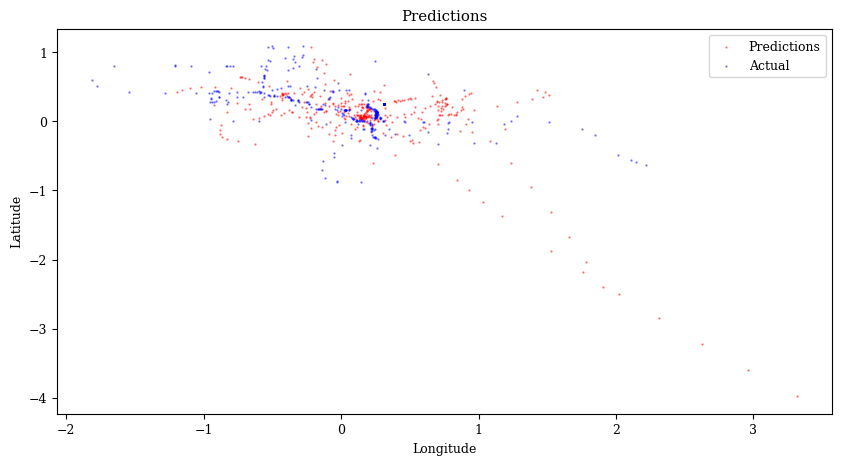

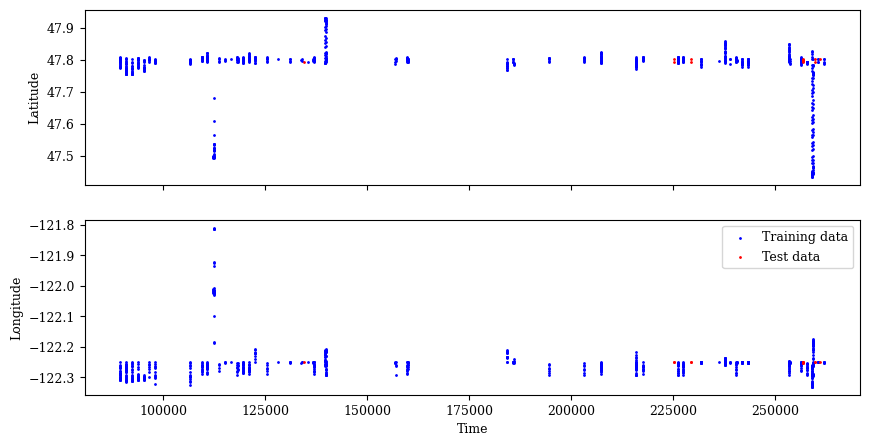

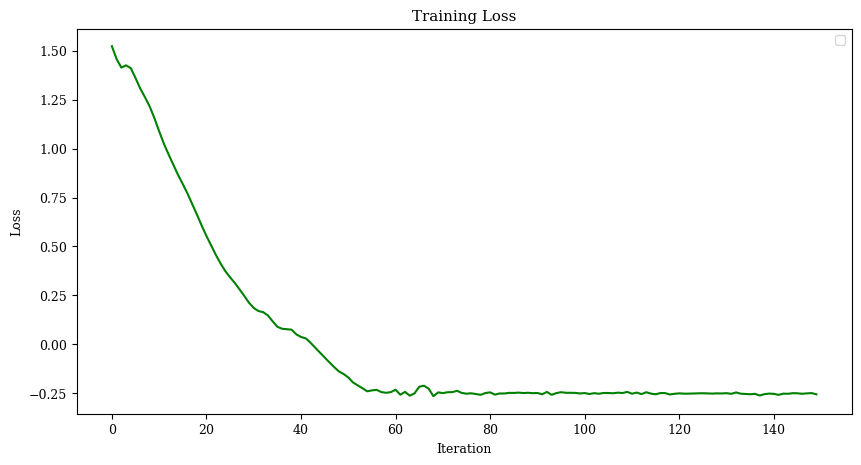

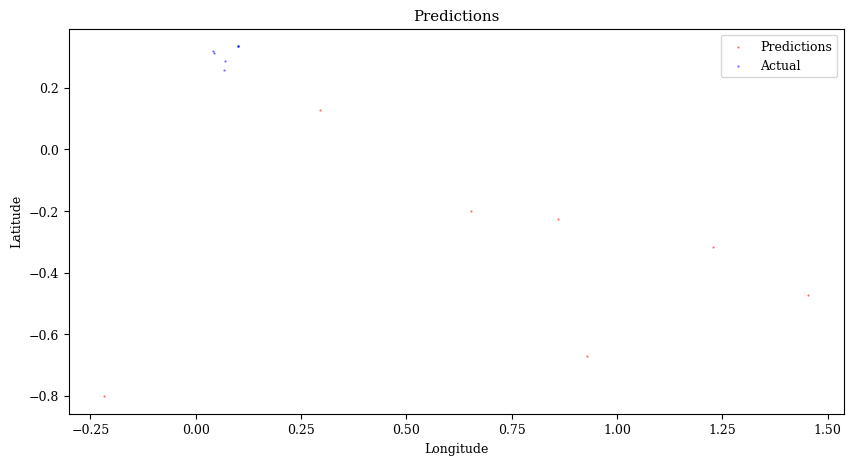

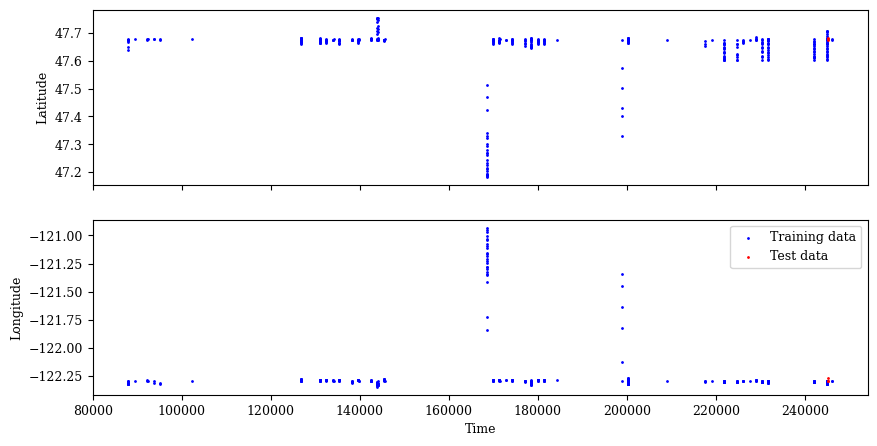

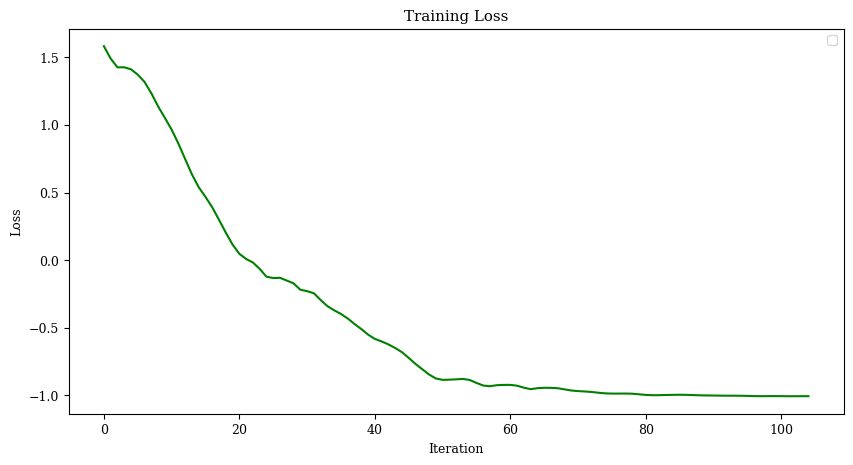

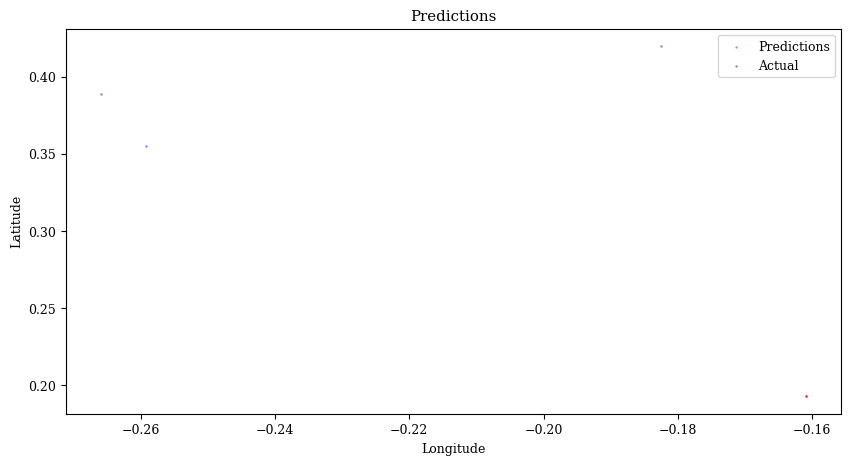

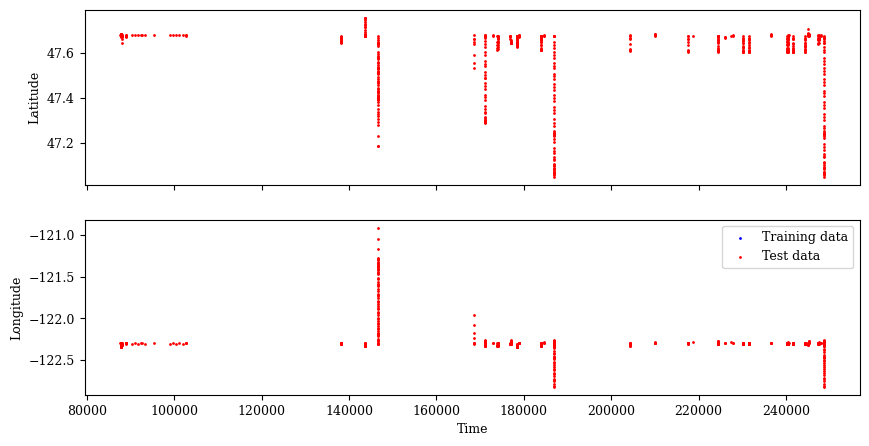

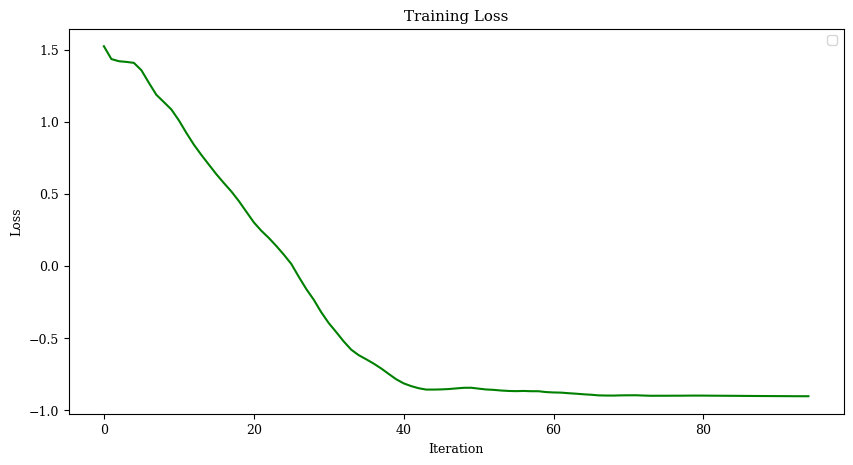

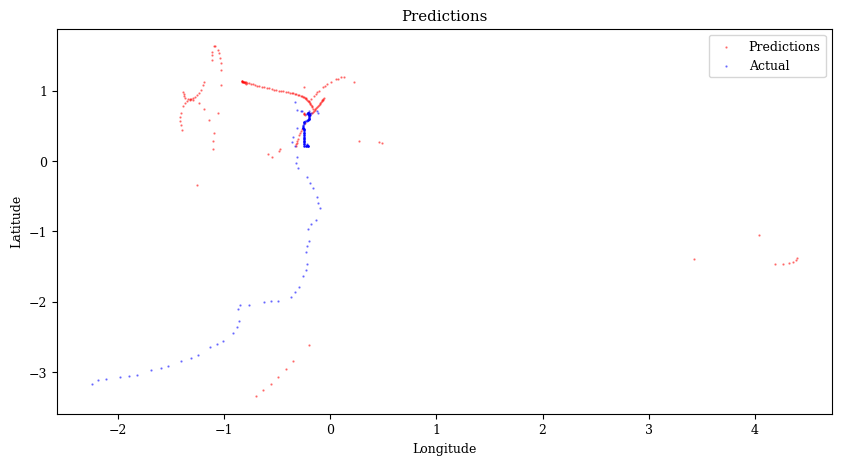

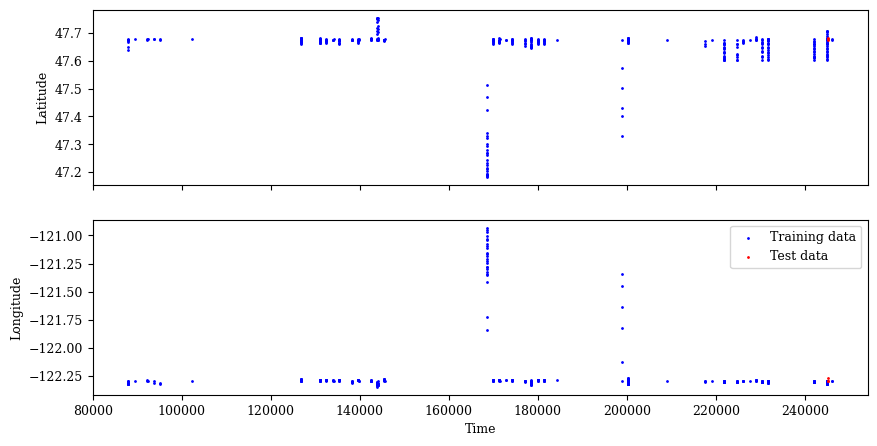

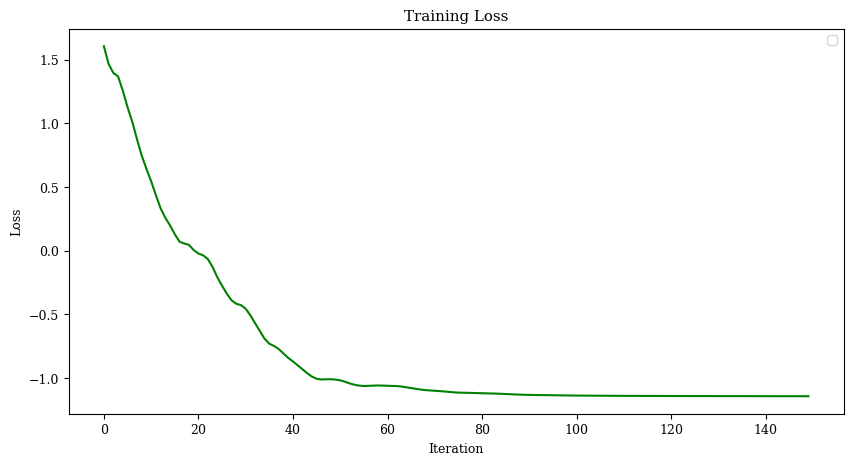

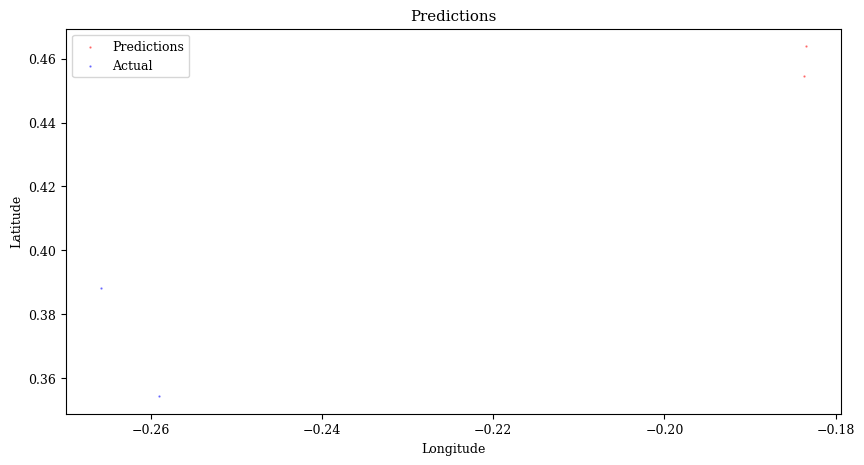

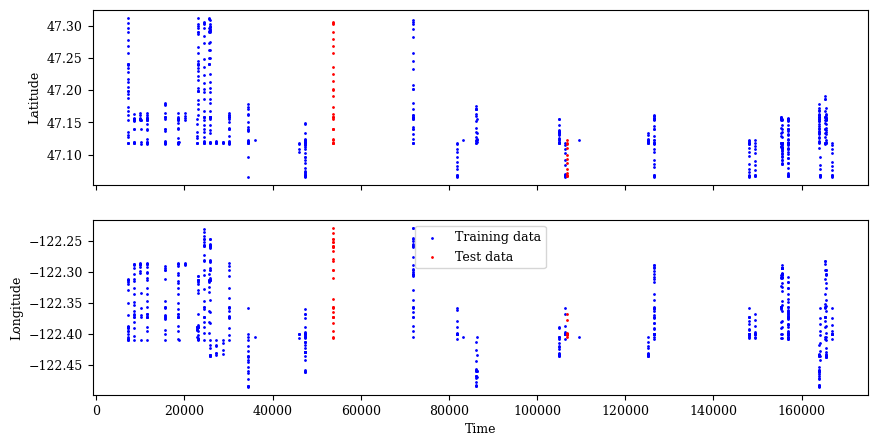

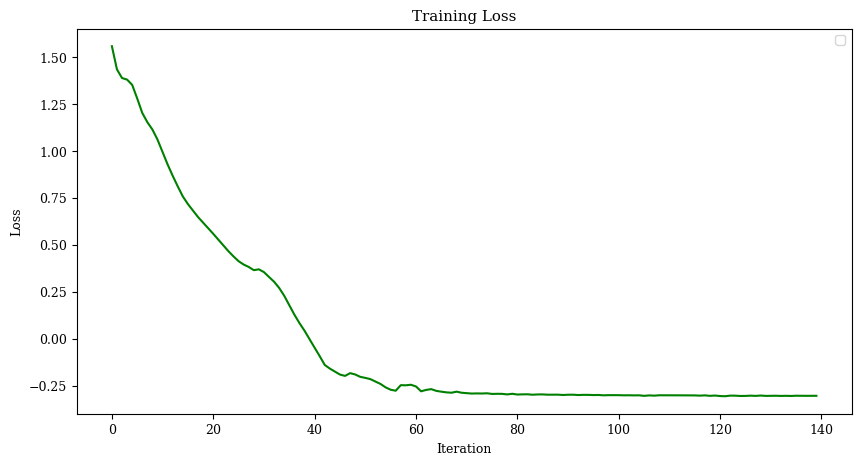

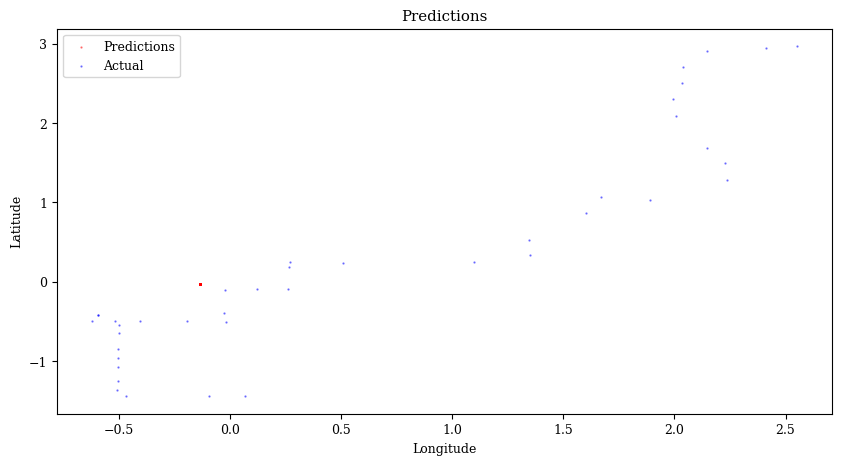

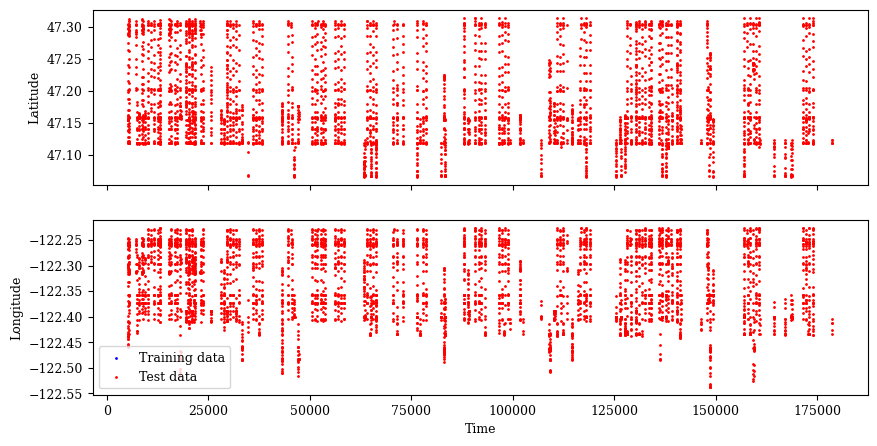

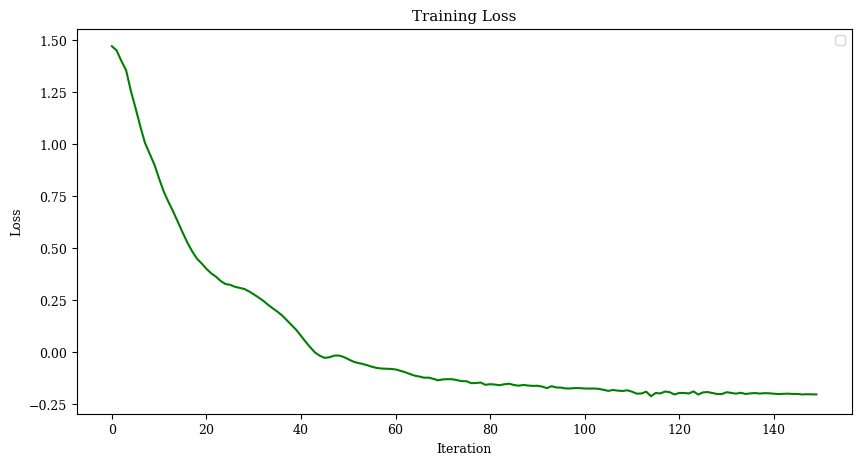

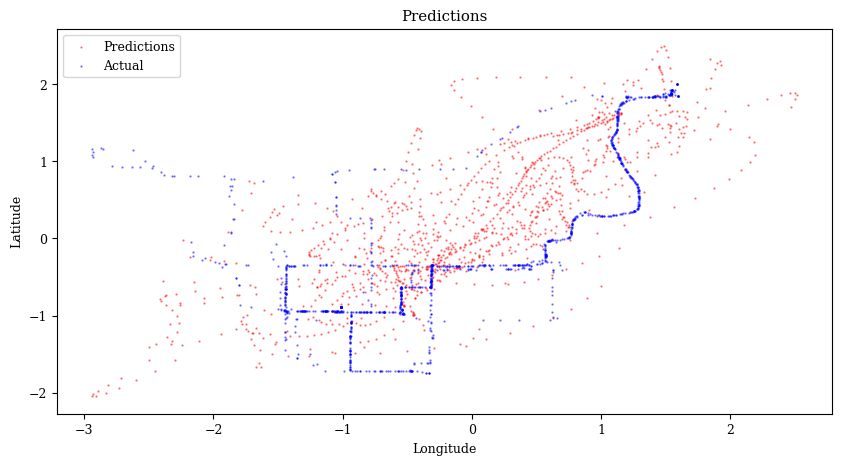

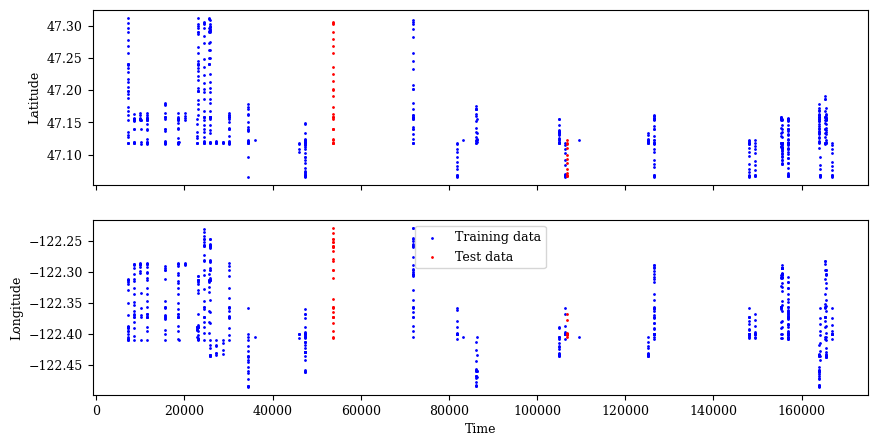

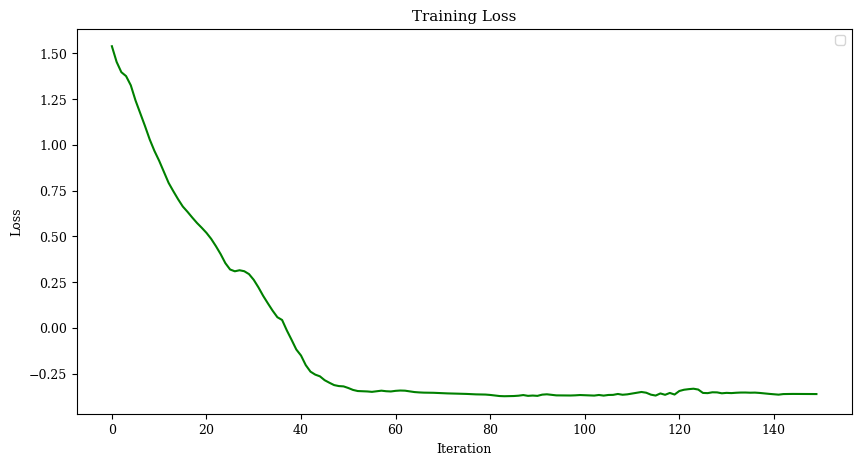

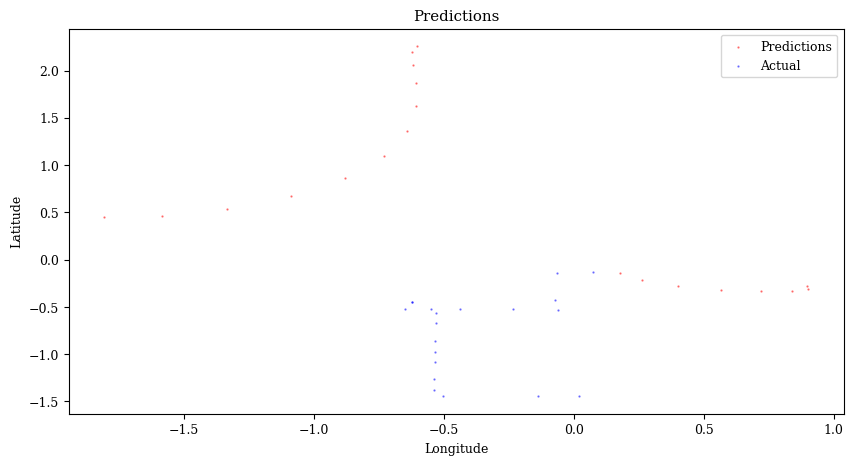

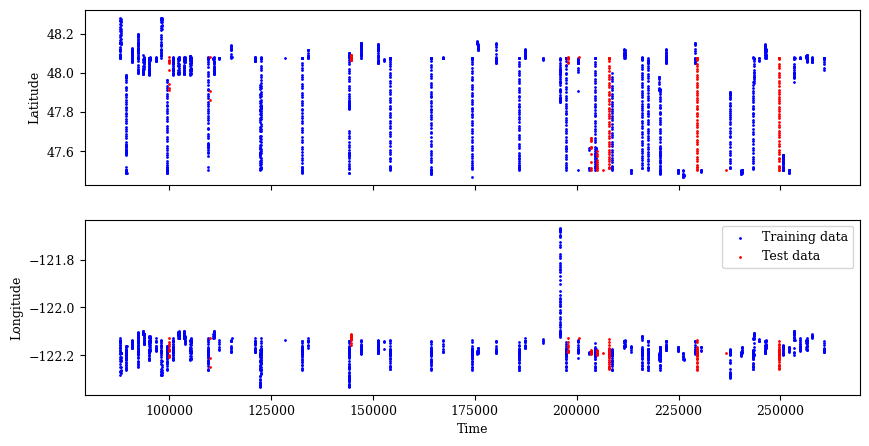

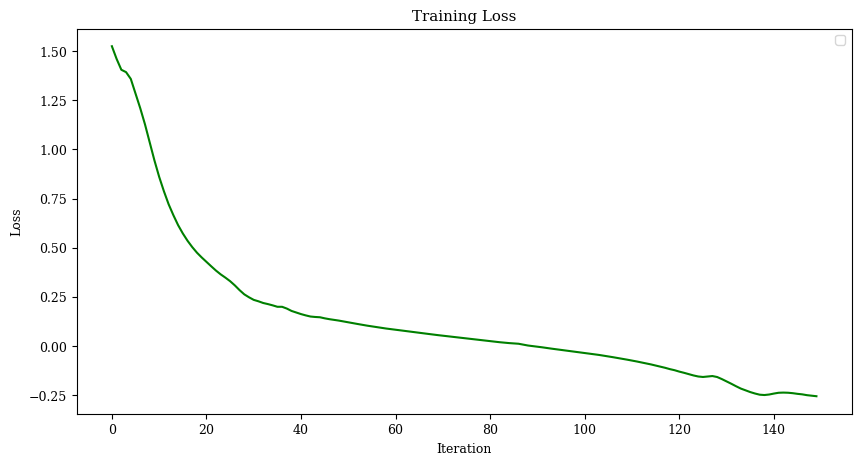

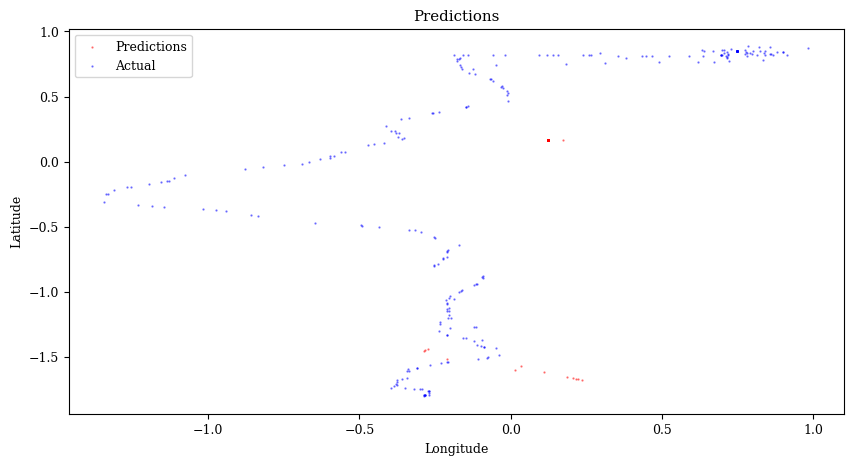

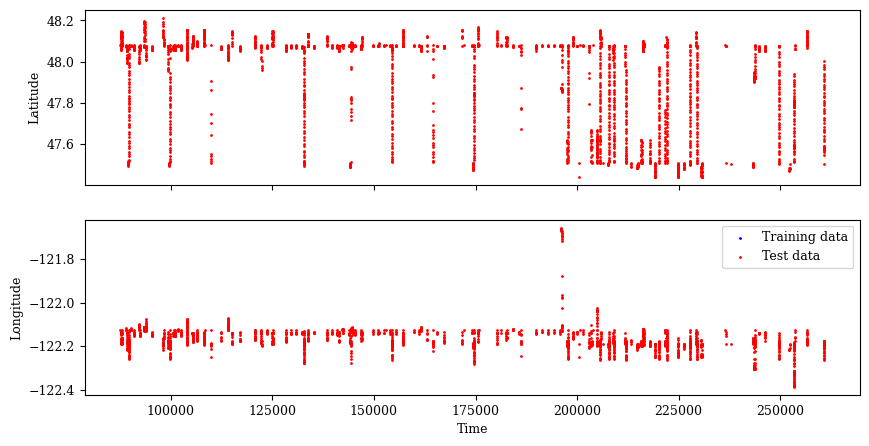

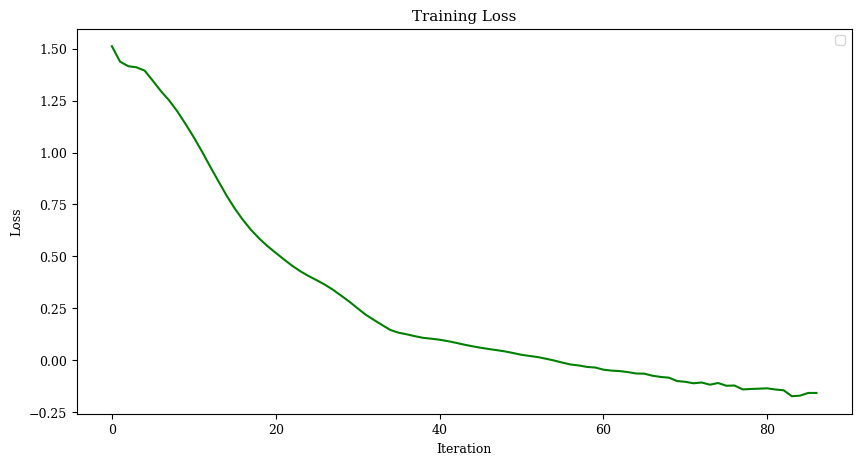

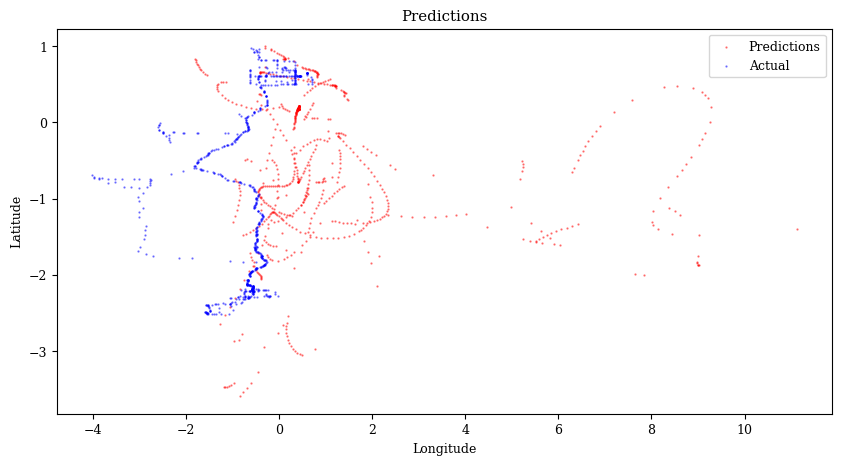

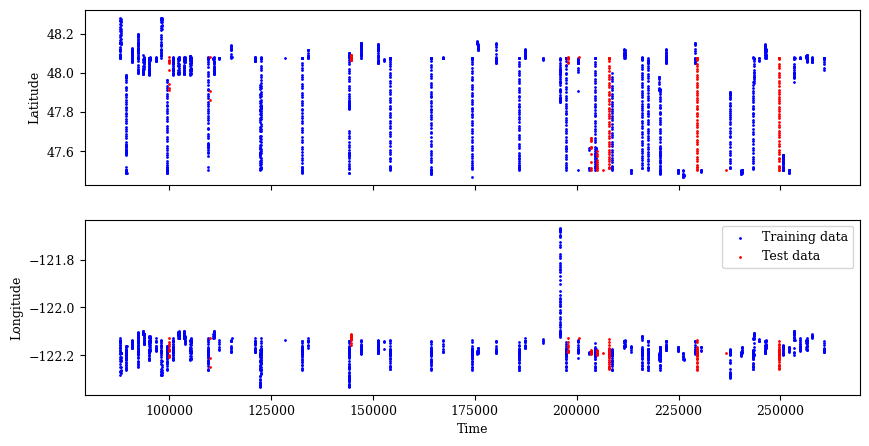

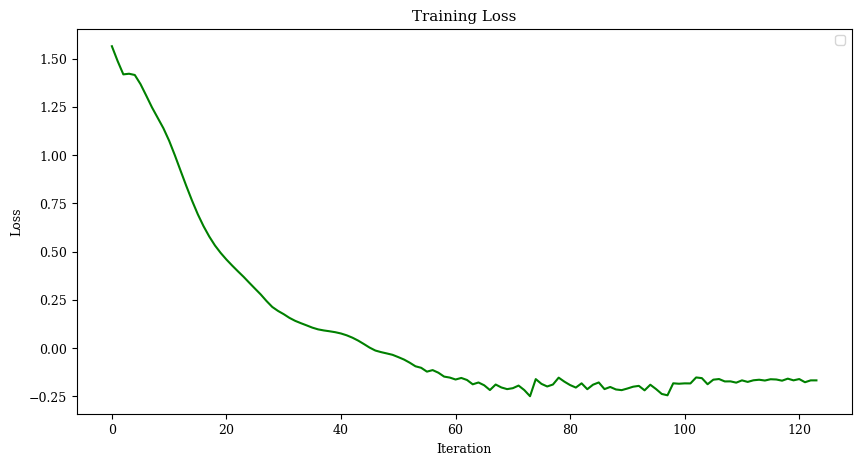

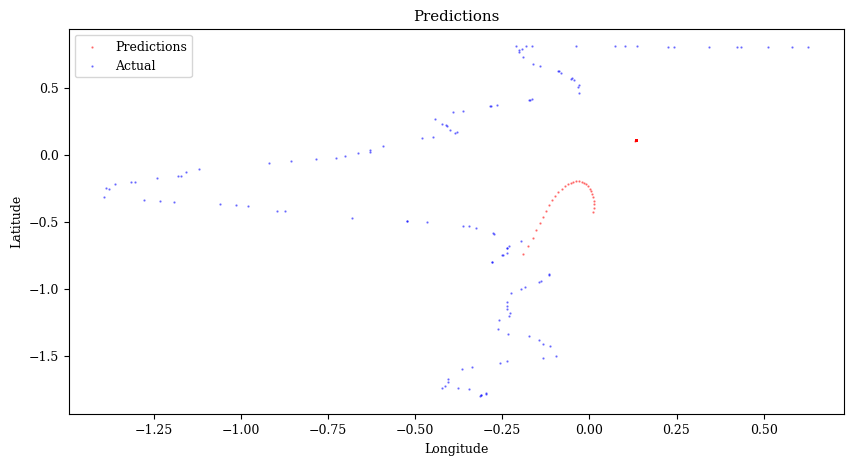

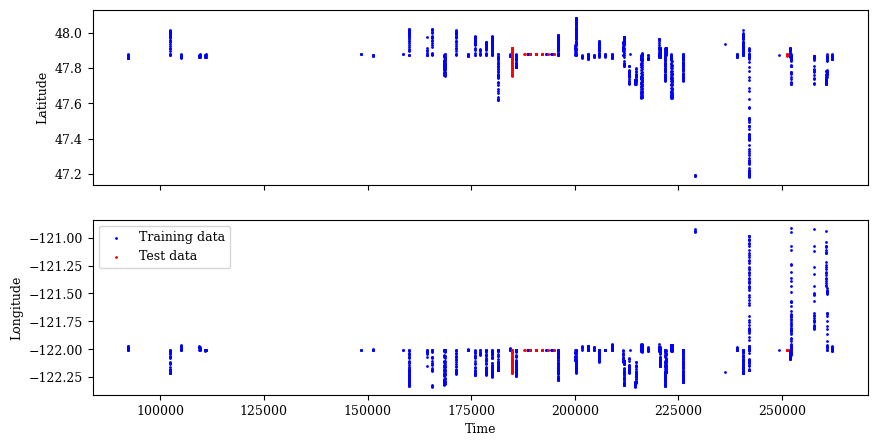

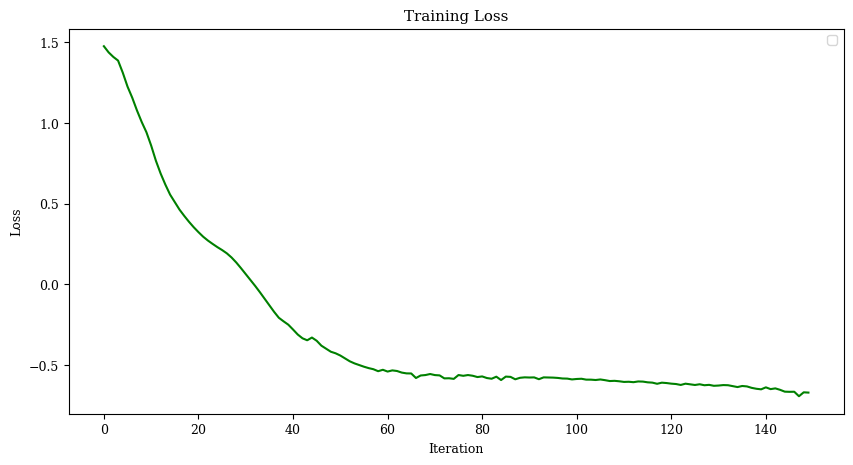

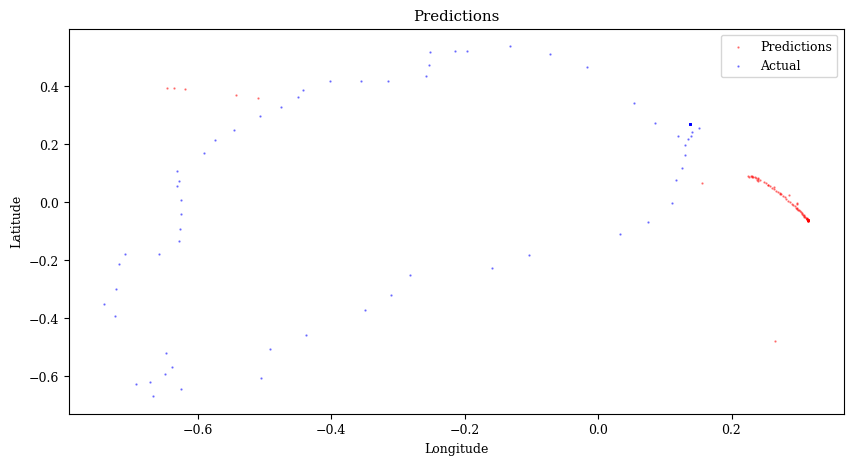

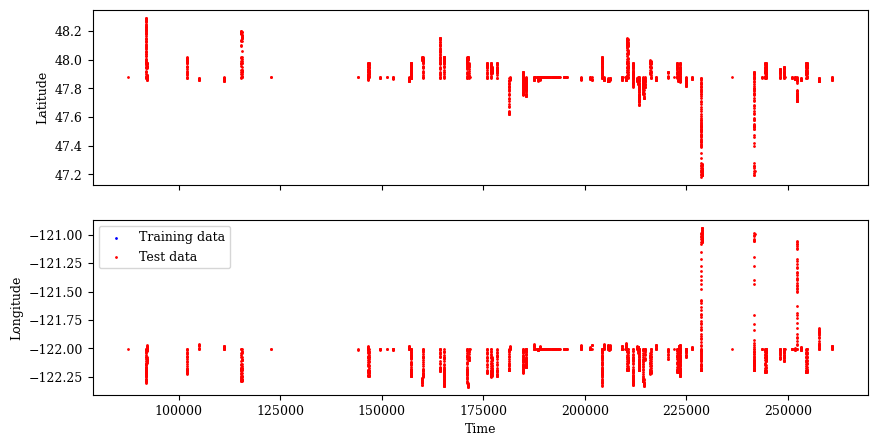

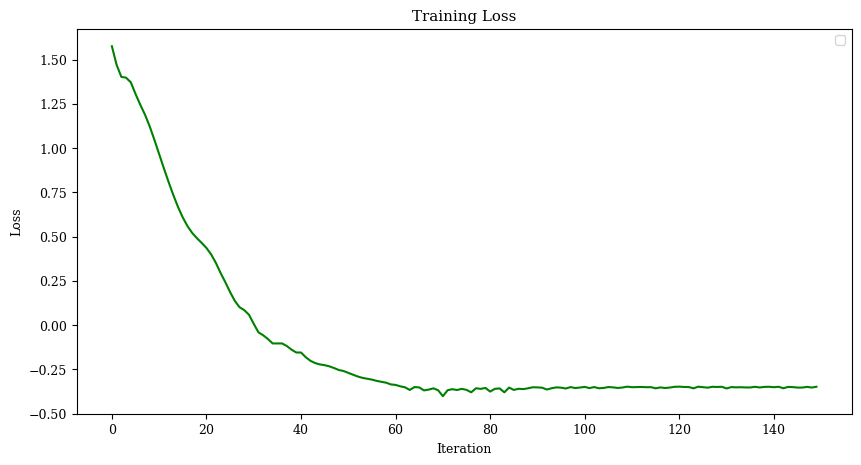

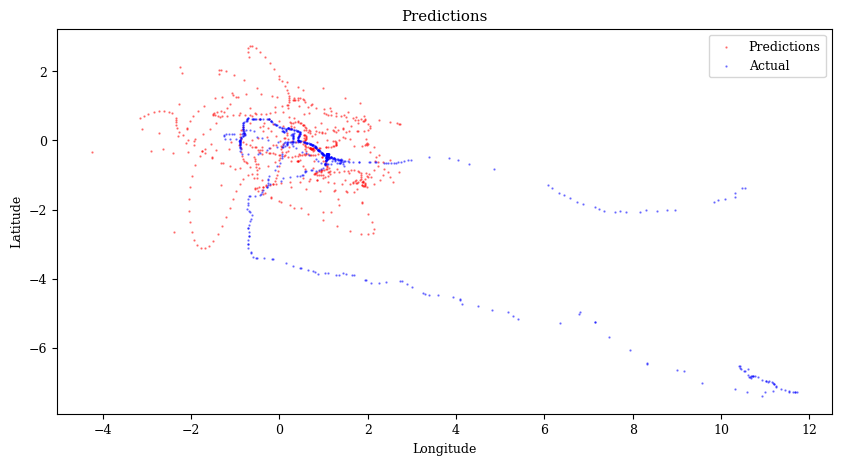

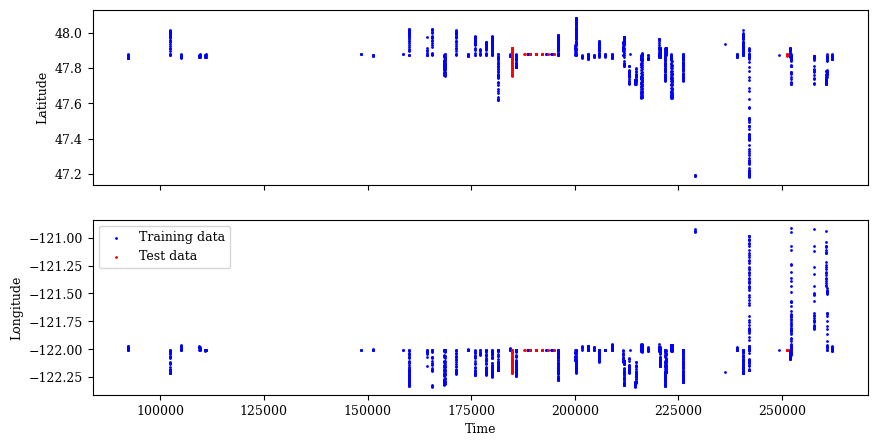

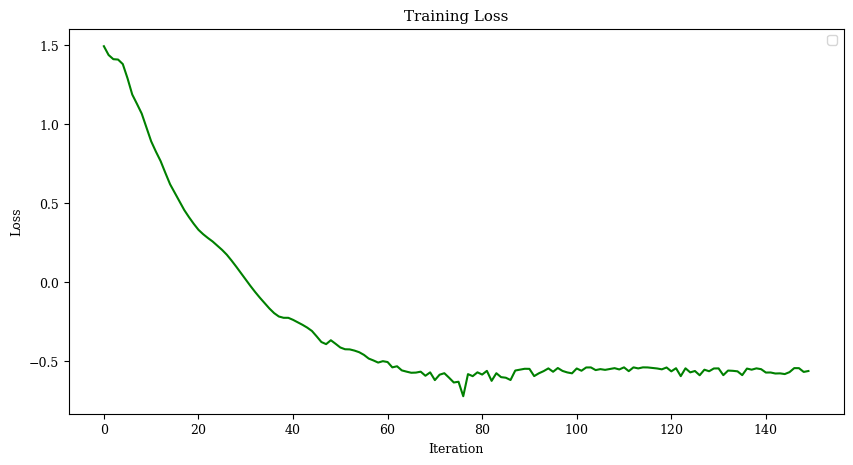

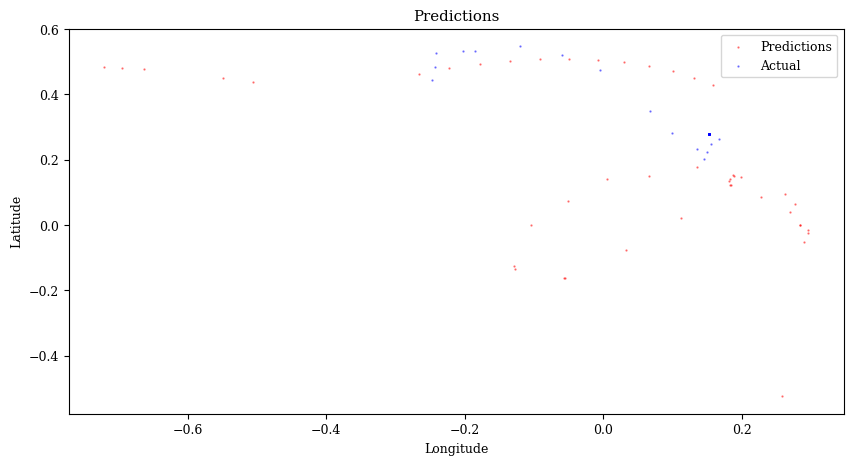

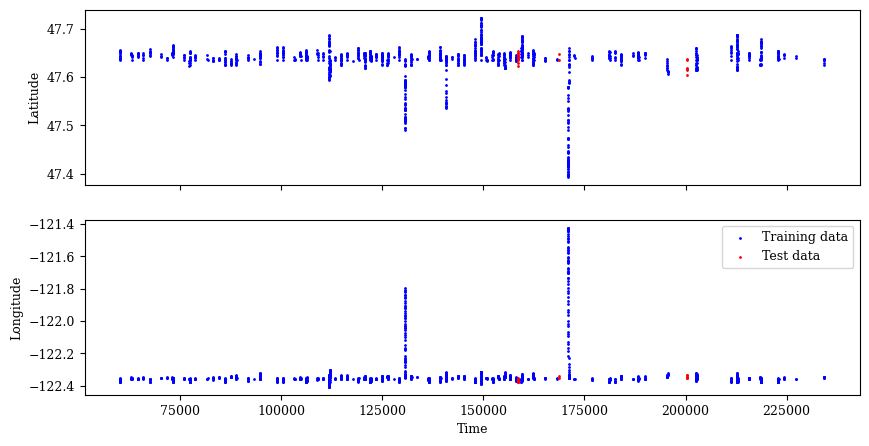

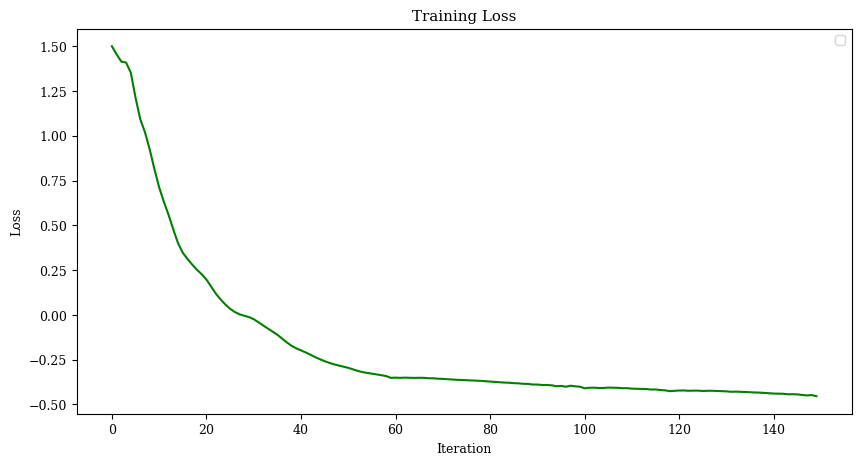

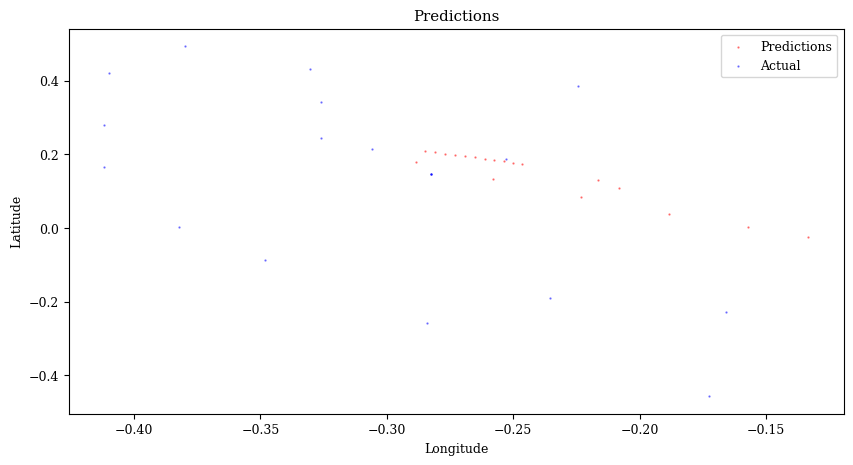

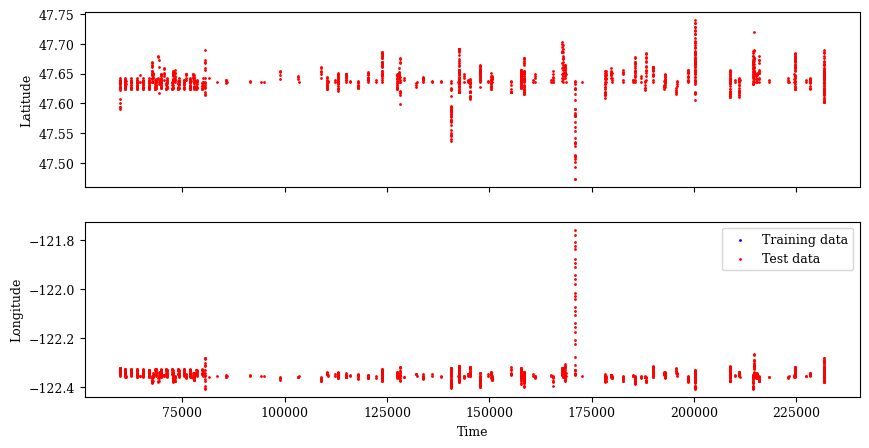

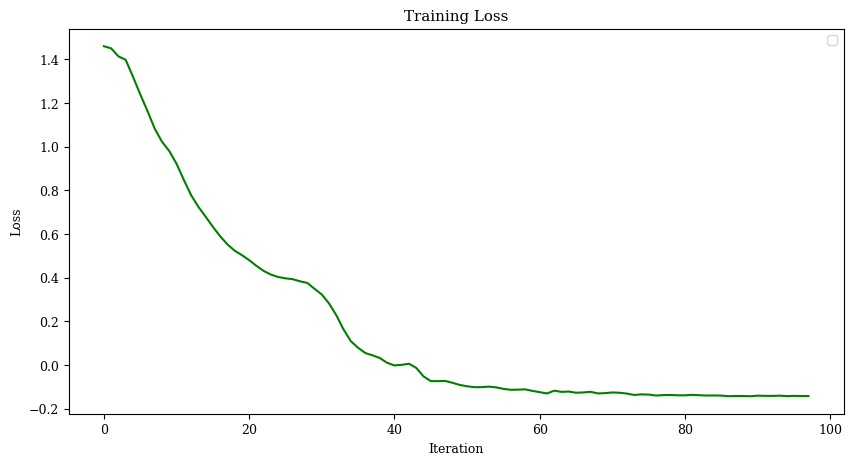

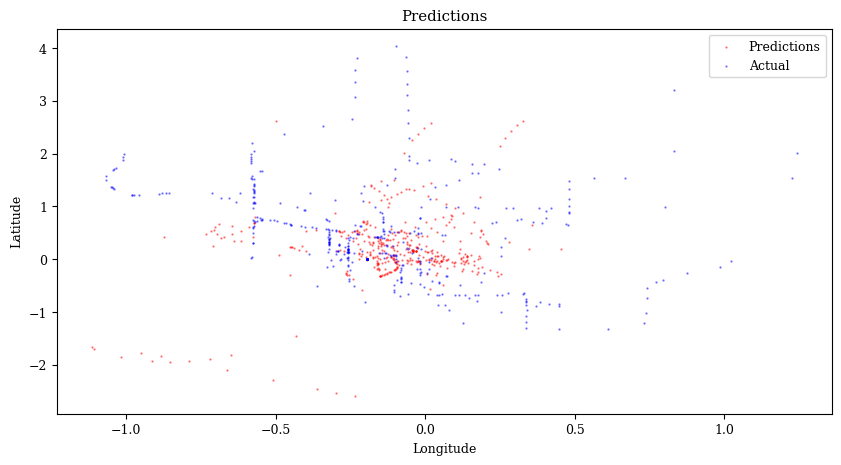

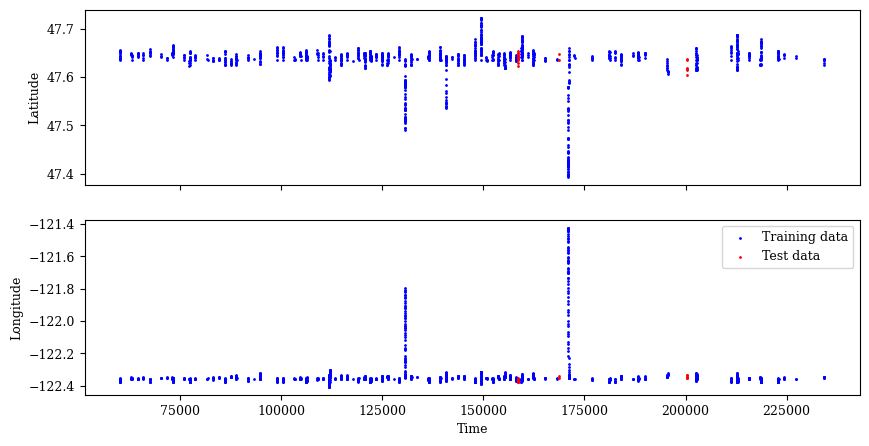

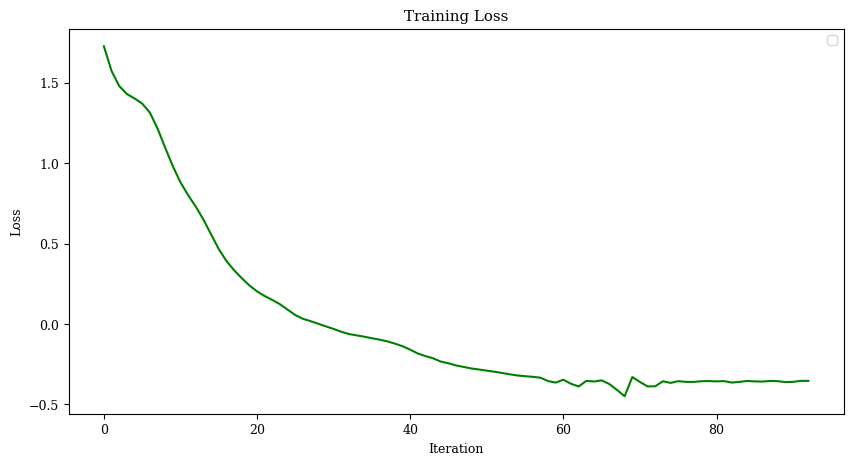

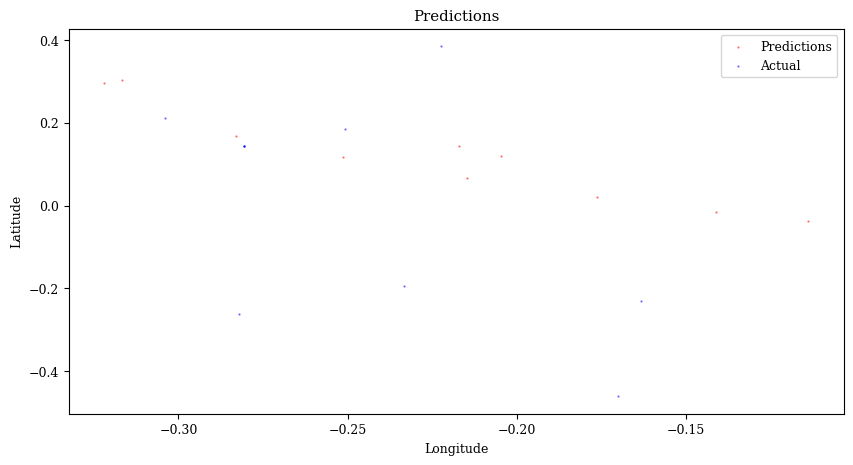

In [7]:
# if os.device
if socket.gethostname() == 'CC-M133A-EU.local':
    file_path = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GPR/Data/seattle_2000_all_obs_sampled.csv"
    df = pd.read_csv(file_path, header=0)
else:
    file_path = "C:\\Users\\ekino\\OneDrive - UW\\GPR\\Data\\seattle_2000_all_obs_sampled.csv"
    df = pd.read_csv(file_path, header=0)

# Add month column
df['month'] = pd.DatetimeIndex(df['datetime']).month

# Group by user ID, find month with third most observations (average)
#df_m = df.groupby('UID').apply(lambda x: x[x['month'] == x['month'].value_counts().index[2]])

# Groupby user ID, keep all observations from January and February
df_m = df.groupby('UID').apply(lambda x: x[x['month'].isin([3, 4, 5, 6])])

df_m = df_m.reset_index(drop=True)

max_speed_kmh = 200 # for filtering out unrealistic speeds
spatial_radius_km = 0.3 # for compressing similar points using Douglas-Peucker algorithm
#bin_len_ls = [10080, 5, 1] # Bin lengths to test: 1 week, 1 day, 6 hours, 1 hour, 30 min, 15 min, 1 min
init_period_len_1 = 60*24 # 24 hours
init_period_len_2 = 60*24*7 # 1 week
lr = 0.3 # learning rate
n_epochs = 150 # number of epochs

# Set search range for ARIMA and SARIMAX
p_values = range(0, 3)
d_values = range(0, 2)  
q_values = range(0, 3) 
P_values = range(0, 3)  
D_values = range(0, 2)  
Q_values = range(0, 3)  
m_values = range(24, 25) # 24 hours 

runtimes_comp = []
bics_comp = []
runtimes_PM = []
bics_PM = []
runtimes_PM_comp = []
bics_PM_comp = []

# if os.device
if socket.gethostname() == 'CC-M133A-EU.local':
    dir_path = "/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/GPSImputeOct2023/results/small_data/"
else:
    dir_path = "C:\\Users\\ekino\\OneDrive - UW\\GPR\\small_data\\"

# Main loop that will go through each user ID, create a directory for each user, etc.
for i in df_m.UID.unique():
    # Create a directory for each user
    if not os.path.exists(dir_path + str(i)):
        os.makedirs(dir_path + str(i))
    # If path already exists, skip to next user
    else:
        print("Path already exists. Skipping to next user.")
        continue
    # Navigate to the directory
    os.chdir(dir_path + str(i))
    
    print("Starting test on user ID = {}".format(i))
#try:
    df_curr = df_m[df_m.UID == i]

    tdf = skmob.TrajDataFrame(df_curr, latitude='orig_lat', longitude='orig_long', datetime='datetime')
    f_tdf = skmob.preprocessing.filtering.filter(tdf, max_speed_kmh=max_speed_kmh, include_loops=False)
    # Print the difference in number of rows
    print("Number of rows before filtering: {}".format(tdf.shape[0]))
    print("Number of rows after filtering: {}".format(f_tdf.shape[0]))
    fc_tdf = skmob.preprocessing.compression.compress(f_tdf, spatial_radius_km=spatial_radius_km)
    # Print the difference in number of rows
    print("Number of rows after compression: {}".format(fc_tdf.shape[0]))
    # Remove data points with uncertainty > 100m
    fcu_tdf = fc_tdf[fc_tdf['orig_unc'] <= 100]
    # Print the difference in number of rows
    print("Number of rows after uncertainty filtering: {}".format(fcu_tdf.shape[0]))
    df_curr = fcu_tdf

    # Remove duplicates in the unix column
    df_curr = df_curr.drop_duplicates(subset=['unix_min'])

    # Change name of 'lat' and 'lon' columns to 'orig_lat' and 'orig_long'
    df_curr = df_curr.rename(columns={'lat': 'orig_lat', 'lng': 'orig_long'})

    # Create MultiTrip object
    curr_mt = preprocessing.dp_MultiTrip(data=df_curr)
    curr_mt.Multi_Trip_Preprocess(lat='orig_lat', long='orig_long', datetime='datetime')

    # Move 'unix_start_t' to before 'SaM'
    cols = list(curr_mt.data.columns)
    cols.insert(16, cols.pop(cols.index('unix_min')))
    curr_mt.data = curr_mt.data.loc[:, cols] 
    # Print data columns
    print(curr_mt.data.columns)

    am_peak_data = curr_mt.data[curr_mt.data['AM_peak'] == 1]
    pm_peak_data = curr_mt.data[curr_mt.data['PM_peak'] == 1]
    # Keep only AM and PM peak data
    curr_mt.data = curr_mt.data[(curr_mt.data['AM_peak'] == 1) | (curr_mt.data['PM_peak'] == 1)]

    curr_mt.Multi_Trip_TrainTestSplit(test_start_date=None, test_end_date=None, 
                                training_index = set(am_peak_data['unix_min']),
                                lat='orig_lat', long='orig_long', datetime='datetime', unix='unix_min', inputstart='unix_min', 
                                inputend=curr_mt.data.columns[-1])

    n_train_orig = len(curr_mt.X_train[:,0])
    n_test_orig = len(curr_mt.X_test[:,0])
    n_dims_orig = curr_mt.X_train.shape[1]

    # See number of points in training and test sets
    print("Number of points in training set: {}".format(n_train_orig))
    print("Number of points in test set: {}".format(n_test_orig))
    print("Number of input dimensions: {}".format(n_dims_orig))

    # If there are no points (or 1 point) in the test set, skip to the next user
    if n_test_orig <= 1:
        print("No points in test set. Skipping to next user.")
        continue

    # Calculating skmob metrics only on the test and prediction points, not the entire dataset
    df_curr_metrics_orig = helper_func.skmob_metric_calcs(curr_mt.test, method='GT', lat='lat', long='long', datetime='date')

    # Visualize the training and test data in two subplots, one lat vs time and one long vs time
    fig1 = trainTestPlot(am_peak_data, curr_mt)

    mean_lat = curr_mt.y_train[:,0].mean()
    mean_long = curr_mt.y_train[:,1].mean()
    std_lat = curr_mt.y_train[:,0].std()
    std_long = curr_mt.y_train[:,1].std()

    scaler = StandardScaler()
    y_train_scaled = torch.tensor(np.float64(scaler.fit_transform(curr_mt.y_train)))
    y_test_scaled = torch.tensor(np.float64(scaler.transform(curr_mt.y_test)))
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

    # Composite model with RQ * PER kernels
    model = GP.MTGPRegressor(curr_mt.X_train, y_train_scaled, 
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_orig)) * ScaleKernel(PER(active_dims=[0]))) + 
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_orig)) * ScaleKernel(PER(active_dims=[0])))
    )

    # Set initial lengthscale guess for unix_min as half the average length of gap in training set
    init_lengthscale = curr_mt.data[curr_mt.data['unix_min'].isin(set(am_peak_data['unix_min']))]['unix_min'].diff().mean() / 2 
    # Set the rest of the lengthscale guesses to 1
    initializations = np.ones(n_dims_orig - 1)
    initializations = np.insert(initializations, 0, init_lengthscale)
    model.covar_module.data_covar_module.kernels[0].base_kernel.kernels[0].base_kernel.lengthscale = initializations
    model.covar_module.data_covar_module.kernels[1].base_kernel.kernels[0].base_kernel.lengthscale = initializations

    # Set initial period lengths
    model.covar_module.data_covar_module.kernels[0].base_kernel.kernels[1].base_kernel.period_length = init_period_len_1
    model.covar_module.data_covar_module.kernels[1].base_kernel.kernels[1].base_kernel.period_length = init_period_len_2

    # Train model
    start = time.time()
    ls, mll = GP.training(model, curr_mt.X_train, y_train_scaled, lr=lr, n_epochs=n_epochs)
    end = time.time()
    runtime = end - start
    runtimes_comp.append(runtime)

    fig2 = trainingLossPlot(ls)
    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    with torch.no_grad():
        log_ll = mll(model(curr_mt.X_train), y_train_scaled) * curr_mt.X_train.shape[0]
                
    N = curr_mt.X_train.shape[0]
    m = sum(p.numel() for p in model.hyperparameters())
    bic = -2 * log_ll + m * np.log(N)
    bics_comp.append(bic)

    # Unix time for benchmarks
    unix_min_tr = np.array(curr_mt.X_train[:,0]).astype(int)
    unix_min_te = np.array(curr_mt.X_test[:,0]).astype(int)  

    lat, lat_tc, lon, lon_tc = makeSeries(y_train_scaled, y_test_scaled, unix_min_tr, unix_min_te)


    predictions, mean = model.predict(curr_mt.X_test)

    fig3 = predictionsVsActualPlot(y_test_scaled, mean)

    # Model results
    mtgp_res = metrics.average_eval(pd.Series(y_test_scaled[:,0]), pd.Series(y_test_scaled[:,1]), pd.Series(mean[:,0]), pd.Series(mean[:,1]))
    
    mtgp_sim = evaluate_similarity(lat_tc, mean, y_test_scaled)

    mtgp_res.update(mtgp_sim)

    # Convert mean predictions back to original scale in lat/long
    orig_preds = scaler.inverse_transform(mean.reshape(-1,2))

    #GP_full_preds_df = helper_func.preds_to_full_df(preds_lat=orig_preds[:,0], preds_long=orig_preds[:,1], 
    #                                            test_df = curr_mt.test, train_df=curr_mt.train)
    # Changelog: 09/30/2023
    # Making it such that skmob metrics are calculated only on the test and prediction points, not the entire dataset
    GP_full_preds_df = pd.DataFrame(orig_preds, columns=['lat', 'long'])
    GP_full_preds_df['datetime'] = curr_mt.test['date'].values

    mtgp_tdf = helper_func.skmob_metric_calcs(GP_full_preds_df, method='GP', lat='lat', long='long', datetime='datetime')

    mtgp_rec_acc = helper_func.matrix_acc(mtgp_tdf.recency_gp_pred, df_curr_metrics_orig.recency_gt_pred, metric_name='recency', tolerance=1e-04)
    mtgp_freq_rank_acc = helper_func.matrix_acc(mtgp_tdf.freq_rank_gp_pred, df_curr_metrics_orig.freq_rank_gt_pred, metric_name='freq_rank', tolerance=1e-01)

    ### Benchmark models ###
    # Try again but with other PM peak data, do a 70/30 split
    curr_mt = preprocessing.dp_MultiTrip(data=df_curr)
    curr_mt.Multi_Trip_Preprocess(lat='orig_lat', long='orig_long', datetime='datetime')

    # Move 'unix_start_t' to before 'SaM'
    cols = list(curr_mt.data.columns)
    cols.insert(16, cols.pop(cols.index('unix_min')))
    curr_mt.data = curr_mt.data.loc[:, cols] 
    # Rename orig_lat and orig_long to lat and lng
    curr_mt.data = curr_mt.data.rename(columns={'orig_lat': 'lat', 'orig_long': 'lng'})
    

    # Keep only AM and PM peak data
    curr_mt.data = curr_mt.data[(curr_mt.data['AM_peak'] == 0) | (curr_mt.data['PM_peak'] == 1)]
    
    # Use sklearn to split data into training and test sets, make sure that test set is continuous in time
    # Split data into training and test sets
    train_index, test_index = train_test_split(curr_mt.data.index, test_size=0.3, shuffle=False)
    # Create training and test sets
    curr_mt.train = curr_mt.data.loc[train_index]
    curr_mt.test = curr_mt.data.loc[test_index]

    curr_mt.y_train = curr_mt.train[['lat', 'lng']].values
    curr_mt.y_test = curr_mt.test[['lat', 'lng']].values

    curr_mt.X_train = curr_mt.train[['unix_min', 'SaM', 'Holiday', 'weekend',
    'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
    'day_5', 'day_6']]
    curr_mt.X_test = curr_mt.test[['unix_min', 'SaM', 'Holiday', 'weekend',
        'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
        'day_5', 'day_6']]
    
    # Convert to torch tensor
    curr_mt.X_train = torch.tensor(curr_mt.X_train.values)
    curr_mt.X_test = torch.tensor(curr_mt.X_test.values)
    curr_mt.y_train = torch.tensor(curr_mt.y_train)
    curr_mt.y_test = torch.tensor(curr_mt.y_test)

    n_train_PM = len(curr_mt.X_train[:,0])
    n_test_PM = len(curr_mt.X_test[:,0])
    n_dims_PM = curr_mt.X_train.shape[1]

    # If there are less than or equal to 1 points in the test set, skip to the next user
    if n_test_PM <= 1:
        print("No points in test set. Skipping to next user.")
        continue

    # Calculate sci-kit mobility metrics
    # Calculating skmob metrics only on the test and prediction points, not the entire dataset
    df_curr_metrics_PM = helper_func.skmob_metric_calcs(curr_mt.test, method='PM', lat='lat', long='lng', datetime='date')

    # See number of points in training and test sets
    print("Number of points in training set: {}".format(n_train_PM))
    print("Number of points in test set: {}".format(n_test_PM))
    print("Number of input dimensions: {}".format(n_dims_PM))

    

    # Visualize the training and test data in two subplots, one lat vs time and one long vs time
    fig4 = trainTestPlot(am_peak_data, curr_mt, lat_col='lat', long_col='lng')

    mean_lat = curr_mt.y_train[:,0].mean()
    mean_long = curr_mt.y_train[:,1].mean()
    std_lat = curr_mt.y_train[:,0].std()
    std_long = curr_mt.y_train[:,1].std()

    scaler = StandardScaler()
    y_train_scaled = torch.tensor(np.float64(scaler.fit_transform(curr_mt.y_train)))
    y_test_scaled = torch.tensor(np.float64(scaler.transform(curr_mt.y_test)))
    # Unix time for benchmarks
    unix_min_tr = np.array(curr_mt.X_train[:,0]).astype(int)
    unix_min_te = np.array(curr_mt.X_test[:,0]).astype(int)  

    lat, lat_tc, lon, lon_tc = makeSeries(y_train_scaled, y_test_scaled, unix_min_tr, unix_min_te)

    likelihood  = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model_PM = GP.MTGPRegressor(curr_mt.X_train, y_train_scaled,
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_PM)) * ScaleKernel(PER(active_dims=[0]))) + 
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_PM)) * ScaleKernel(PER(active_dims=[0])))
    )

    # Set initial lengthscale guess for unix_min as half the average length of gap in training set
    init_lengthscale = curr_mt.data[curr_mt.data['unix_min'].isin(set(curr_mt.train['unix_min']))]['unix_min'].diff().mean() / 2
    # Set the rest of the lengthscale guesses to 1
    initializations = np.ones(n_dims_PM - 1)
    initializations = np.insert(initializations, 0, init_lengthscale)
    model_PM.covar_module.data_covar_module.kernels[0].base_kernel.kernels[0].base_kernel.lengthscale = initializations
    model_PM.covar_module.data_covar_module.kernels[1].base_kernel.kernels[0].base_kernel.lengthscale = initializations

    # Set initial period lengths
    model_PM.covar_module.data_covar_module.kernels[0].base_kernel.kernels[1].base_kernel.period_length = init_period_len_1
    model_PM.covar_module.data_covar_module.kernels[1].base_kernel.kernels[1].base_kernel.period_length = init_period_len_2

    # Train model
    start = time.time()
    ls, mll = GP.training(model_PM, curr_mt.X_train, y_train_scaled, lr=lr, n_epochs=n_epochs)
    end = time.time()
    runtime = end - start
    runtimes_PM.append(runtime)

    fig5 = trainingLossPlot(ls)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model_PM.likelihood, model_PM)

    with torch.no_grad():
        log_ll = mll(model_PM(curr_mt.X_train), y_train_scaled) * curr_mt.X_train.shape[0]
        
    N = curr_mt.X_train.shape[0]    
    m = sum(p.numel() for p in model_PM.hyperparameters())
    bic = -2 * log_ll + m * np.log(N)
    bics_PM.append(bic)

    predictions, mean = model_PM.predict(curr_mt.X_test)

    fig6 = predictionsVsActualPlot(y_test_scaled, mean)

    # Model results
    mtgp_res_PM = metrics.average_eval(pd.Series(y_test_scaled[:,0]), pd.Series(y_test_scaled[:,1]), pd.Series(mean[:,0]), pd.Series(mean[:,1]))

    mtgp_sim_PM = evaluate_similarity(lat_tc, mean, y_test_scaled)

    mtgp_res_PM.update(mtgp_sim_PM)

    # Convert mean predictions back to original scale in lat/long
    orig_preds = scaler.inverse_transform(mean.reshape(-1,2))

    GP_full_preds_df = pd.DataFrame(orig_preds, columns=['lat', 'lng'])
    GP_full_preds_df['datetime'] = curr_mt.test['datetime'].values

    mtgp_tdf_PM = helper_func.skmob_metric_calcs(GP_full_preds_df, method='PM', lat='lat', long='lng', datetime='datetime')

    mtgp_rec_acc_PM = helper_func.matrix_acc(mtgp_tdf_PM.recency_pm_pred, df_curr_metrics_PM.recency_pm_pred, metric_name='recency', tolerance=1e-04)
    mtgp_freq_rank_acc_PM = helper_func.matrix_acc(mtgp_tdf_PM.freq_rank_pm_pred, df_curr_metrics_PM.freq_rank_pm_pred, metric_name='freq_rank', tolerance=1e-01)

    ### Now let's do one last run using both AM and PM peaks to predict the PM peak ###
    curr_mt = preprocessing.dp_MultiTrip(data=df_curr)
    curr_mt.Multi_Trip_Preprocess(lat='orig_lat', long='orig_long', datetime='datetime')

    # Move 'unix_start_t' to before 'SaM'
    cols = list(curr_mt.data.columns)
    cols.insert(16, cols.pop(cols.index('unix_min')))
    curr_mt.data = curr_mt.data.loc[:, cols]

    # Rename orig_lat and orig_long to lat and lng
    curr_mt.data = curr_mt.data.rename(columns={'orig_lat': 'lat', 'orig_long': 'lng'})
    
    # Keep only AM and PM peak data
    curr_mt.data = curr_mt.data[(curr_mt.data['AM_peak'] == 1) | (curr_mt.data['PM_peak'] == 1)]
    am_peak_data = curr_mt.data[curr_mt.data['AM_peak'] == 1]
    pm_peak_data = curr_mt.data[curr_mt.data['PM_peak'] == 1]

    # Use sklearn to split data into training and test sets, make sure that test set is continuous in time
    # Split data into training and test sets
    train_index, test_index = train_test_split(pm_peak_data, test_size=0.5, shuffle=False)

    # Append the indices of the AM peak data to the training set
    train_index = train_index.append(am_peak_data)
    
    # Create training and test sets
    curr_mt.train = curr_mt.data.loc[train_index.index]
    curr_mt.test = curr_mt.data.loc[test_index.index]

    curr_mt.y_train = curr_mt.train[['lat', 'lng']].values
    curr_mt.y_test = curr_mt.test[['lat', 'lng']].values

    curr_mt.X_train = curr_mt.train[['unix_min', 'SaM', 'Holiday', 'weekend',
        'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
        'day_5', 'day_6']]
    curr_mt.X_test = curr_mt.test[['unix_min', 'SaM', 'Holiday', 'weekend',
        'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
        'day_5', 'day_6']]
    
    # Convert to torch tensor
    curr_mt.X_train = torch.tensor(curr_mt.X_train.values)
    curr_mt.X_test = torch.tensor(curr_mt.X_test.values)
    curr_mt.y_train = torch.tensor(curr_mt.y_train)
    curr_mt.y_test = torch.tensor(curr_mt.y_test)

    n_train_PM_comp = len(curr_mt.X_train[:,0])
    n_test_PM_comp = len(curr_mt.X_test[:,0])
    n_dims_PM_comp = curr_mt.X_train.shape[1]

    # If there are less than or equal to 1 points in the test set, skip to the next user
    if n_test_PM_comp <= 1:
        print("No points in test set. Skipping to next user.")
        continue

    # Calculate sci-kit mobility metrics
    # df_curr_metrics = helper_func.skmob_metric_calcs(df_curr, method='GT', lat='lat', long='lng', datetime='datetime')
    # Calculating skmob metrics only on the test and prediction points, not the entire dataset
    df_curr_metrics_PM_comp = helper_func.skmob_metric_calcs(curr_mt.test, method='PM_comp', lat='lat', long='long', datetime='date')

    # See number of points in training and test sets
    print("Number of points in training set: {}".format(n_train_PM_comp))
    print("Number of points in test set: {}".format(n_test_PM_comp))
    print("Number of input dimensions: {}".format(n_dims_PM_comp))

    
        
    # Visualize the training and test data in two subplots, one lat vs time and one long vs time
    fig7 = trainTestPlot(am_peak_data, curr_mt, lat_col='lat', long_col='lng')

    mean_lat = curr_mt.y_train[:,0].mean()
    mean_long = curr_mt.y_train[:,1].mean()
    std_lat = curr_mt.y_train[:,0].std()
    std_long = curr_mt.y_train[:,1].std()

    scaler = StandardScaler()
    y_train_scaled = torch.tensor(np.float64(scaler.fit_transform(curr_mt.y_train)))
    y_test_scaled = torch.tensor(np.float64(scaler.transform(curr_mt.y_test)))
    # Unix time for benchmarks
    unix_min_tr = np.array(curr_mt.X_train[:,0]).astype(int)
    unix_min_te = np.array(curr_mt.X_test[:,0]).astype(int)  

    lat, lat_tc, lon, lon_tc = makeSeries(y_train_scaled, y_test_scaled, unix_min_tr, unix_min_te)
    
    likelihood  = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

    model_PM_comp = GP.MTGPRegressor(curr_mt.X_train, y_train_scaled,
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_PM_comp)) * ScaleKernel(PER(active_dims=[0]))) + 
                            ScaleKernel(ScaleKernel(RQ(ard_num_dims=n_dims_PM_comp)) * ScaleKernel(PER(active_dims=[0])))
    )

    # Set initial lengthscale guess for unix_min as half the average length of gap in training set
    init_lengthscale = curr_mt.data[curr_mt.data['unix_min'].isin(set(curr_mt.train['unix_min']))]['unix_min'].diff().mean() / 2
    # Set the rest of the lengthscale guesses to 1
    initializations = np.ones(n_dims_PM_comp - 1)
    initializations = np.insert(initializations, 0, init_lengthscale)
    model_PM_comp.covar_module.data_covar_module.kernels[0].base_kernel.kernels[0].base_kernel.lengthscale = initializations
    model_PM_comp.covar_module.data_covar_module.kernels[1].base_kernel.kernels[0].base_kernel.lengthscale = initializations

    # Set initial period lengths
    model_PM_comp.covar_module.data_covar_module.kernels[0].base_kernel.kernels[1].base_kernel.period_length = init_period_len_1
    model_PM_comp.covar_module.data_covar_module.kernels[1].base_kernel.kernels[1].base_kernel.period_length = init_period_len_2

    # Train model
    start = time.time()
    ls, mll = GP.training(model_PM_comp, curr_mt.X_train, y_train_scaled, lr=lr, n_epochs=n_epochs)
    end = time.time()
    runtime = end - start
    runtimes_PM_comp.append(runtime)

    fig8 = trainingLossPlot(ls)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model_PM_comp.likelihood, model_PM_comp)

    with torch.no_grad():
        log_ll = mll(model_PM_comp(curr_mt.X_train), y_train_scaled) * curr_mt.X_train.shape[0]

    N = curr_mt.X_train.shape[0]
    m = sum(p.numel() for p in model_PM_comp.hyperparameters())
    bic = -2 * log_ll + m * np.log(N)
    bics_PM_comp.append(bic)
    
    predictions, mean = model_PM_comp.predict(curr_mt.X_test)

    fig9 = predictionsVsActualPlot(y_test_scaled, mean)

    # Model results
    mtgp_res_PM_comp = metrics.average_eval(pd.Series(y_test_scaled[:,0]), pd.Series(y_test_scaled[:,1]), pd.Series(mean[:,0]), pd.Series(mean[:,1]))

    mtgp_sim_PM_comp = evaluate_similarity(lat_tc, mean, y_test_scaled)

    mtgp_res_PM_comp.update(mtgp_sim_PM_comp)

    # Convert mean predictions back to original scale in lat/long
    orig_preds = scaler.inverse_transform(mean.reshape(-1,2))

    GP_full_preds_df = pd.DataFrame(orig_preds, columns=['lat', 'lng'])
    GP_full_preds_df['datetime'] = curr_mt.test['datetime'].values

    mtgp_tdf_PM_comp = helper_func.skmob_metric_calcs(GP_full_preds_df, method='PM_comp', lat='lat', long='lng', datetime='datetime')

    mtgp_rec_acc_PM_comp = helper_func.matrix_acc(mtgp_tdf_PM_comp.recency_pm_comp_pred, df_curr_metrics_PM_comp.recency_pm_comp_pred, metric_name='recency', tolerance=1e-04)
    mtgp_freq_rank_acc_PM_comp = helper_func.matrix_acc(mtgp_tdf_PM_comp.freq_rank_pm_comp_pred, df_curr_metrics_PM_comp.freq_rank_pm_comp_pred, metric_name='freq_rank', tolerance=1e-01)

    # Save figure to file
    try:
        fig1.savefig('train_test_sets_plot.png', dpi=300)
        fig2.savefig('training_loss_plot.png', dpi=300)
        fig3.savefig('mtgp_predictions_plot.png', dpi=300)
        fig4.savefig('train_test_sets_plot_PM.png', dpi=300)
        fig5.savefig('training_loss_plot_PM.png', dpi=300)
        fig6.savefig('mtgp_predictions_plot_PM.png', dpi=300)
        fig7.savefig('train_test_sets_plot_PM_comp.png', dpi=300)
        fig8.savefig('training_loss_plot_PM_comp.png', dpi=300)
        fig9.savefig('mtgp_predictions_plot_PM_comp.png', dpi=300)
    except:
            # Keep going even if figures fail to save
        print("Failed to save figures.")
        pass
            
    try:
        # Create dictionary to store parameters
        params = {
            'max_speed_kmh': max_speed_kmh,
            'spatial_radius_km': spatial_radius_km,
            'tdf.shape[0]': tdf.shape[0],
            'f_tdf.shape[0]': f_tdf.shape[0],
            'fc_tdf.shape[0]': fc_tdf.shape[0],
            'fcu_tdf.shape[0]': fcu_tdf.shape[0],
            #'curr_ocp': curr_ocp,
            #'target_ocp': target_ocp,
            #'new_ocp': new_ocp,
            'n_train_orig': n_train_orig,
            'n_test_orig': n_test_orig,
            'n_dims_orig': n_dims_orig,
            'n_train_PM': n_train_PM,
            'n_test_PM': n_test_PM,
            'n_dims_PM': n_dims_PM,
            'n_train_PM_comp': n_train_PM_comp,
            'n_test_PM_comp': n_test_PM_comp,
            'n_dims_PM_comp': n_dims_PM_comp,
            'mean_lat': mean_lat,
            'mean_long': mean_long,
            'std_lat': std_lat,
            'std_long': std_long,
            'init_lengthscale': init_lengthscale,
            'init_period_len_1': init_period_len_1,
            'init_period_len_2': init_period_len_2,
            'log_ll': log_ll,
            'm': m,
            'bic': bic,
            'bics_PM': bics_PM,
            'bics_PM_comp': bics_PM_comp,
            'gp_runtime': runtime
        }
            # Convert all values to float, except for tuples
        for k, v in params.items():
            try:
                params[k] = float(v)
            except TypeError:
                pass
        # Write params to a file
        with open('params_' + str(i) + '.json', 'w') as fp:
            json.dump(params, fp)

        # Create dataframe to store parameters
        params_df = pd.DataFrame.from_dict(params, orient='index')
        params_df.columns = ['value']
        params_df.to_csv('params_' + str(i) + '.csv')

        print("Saving parameters...")
    except:
        print("Failed to save parameters.")
        pass

    # See the differences in metric results
    
    
    # Create dataframe to store results
    results = pd.DataFrame.from_dict([mtgp_res, mtgp_res_PM, mtgp_res_PM_comp], orient='columns')
    results['model'] = ['MTGP_Comp', 'MTGP_PM', 'MTGP_PM_Comp']
    results = results.set_index('model')

    # Create dataframe to store scalar scikit-mobility metrics
    skmob_metrics_df = pd.DataFrame(columns=['no_loc', 'rg', 'k_rg',    
                                        'spat_burst', 'rand_entr', 
                                        'real_entr', 'uncorr_entr',
                                        'max_dist', 'dist_straight', 'max_dist_home', 
                                        'recency', 'freq_rank'])

    skmob_metrics_df['methods'] = ['MTGP_Comp', 'MTGP_PM', 'MTGP_PM_Comp', 'MTGP_GT', 'MTGP_GT_PM', 'MTGP_GT_PM_Comp']
    # Make methods the index
    skmob_metrics_df = skmob_metrics_df.set_index('methods')

    try:
        skmob_metrics_df.iloc[0] = mtgp_tdf.no_loc_gp_pred, mtgp_tdf.rg_gp_pred, mtgp_tdf.k_rg_gp_pred, mtgp_tdf.spat_burst_gp_pred, mtgp_tdf.rand_entr_gp_pred, mtgp_tdf.real_entr_gp_pred, mtgp_tdf.uncorr_entr_gp_pred, mtgp_tdf.max_dist_gp_pred, mtgp_tdf.dist_straight_gp_pred, mtgp_tdf.max_dist_home_gp_pred, mtgp_rec_acc, mtgp_freq_rank_acc
        skmob_metrics_df.iloc[1] = mtgp_tdf_PM.no_loc_pm_pred, mtgp_tdf_PM.rg_pm_pred, mtgp_tdf_PM.k_rg_pm_pred, mtgp_tdf_PM.spat_burst_pm_pred, mtgp_tdf_PM.rand_entr_pm_pred, mtgp_tdf_PM.real_entr_pm_pred, mtgp_tdf_PM.uncorr_entr_pm_pred, mtgp_tdf_PM.max_dist_pm_pred, mtgp_tdf_PM.dist_straight_pm_pred, mtgp_tdf_PM.max_dist_home_pm_pred, mtgp_rec_acc_PM, mtgp_freq_rank_acc_PM
        skmob_metrics_df.iloc[2] = mtgp_tdf_PM_comp.no_loc_pm_comp_pred, mtgp_tdf_PM_comp.rg_pm_comp_pred, mtgp_tdf_PM_comp.k_rg_pm_comp_pred, mtgp_tdf_PM_comp.spat_burst_pm_comp_pred, mtgp_tdf_PM_comp.rand_entr_pm_comp_pred, mtgp_tdf_PM_comp.real_entr_pm_comp_pred, mtgp_tdf_PM_comp.uncorr_entr_pm_comp_pred, mtgp_tdf_PM_comp.max_dist_pm_comp_pred, mtgp_tdf_PM_comp.dist_straight_pm_comp_pred, mtgp_tdf_PM_comp.max_dist_home_pm_comp_pred, mtgp_rec_acc_PM_comp, mtgp_freq_rank_acc_PM_comp
        skmob_metrics_df.iloc[3] = df_curr_metrics_orig.no_loc_gt_pred, df_curr_metrics_orig.rg_gt_pred, df_curr_metrics_orig.k_rg_gt_pred, df_curr_metrics_orig.spat_burst_gt_pred, df_curr_metrics_orig.rand_entr_gt_pred, df_curr_metrics_orig.real_entr_gt_pred, df_curr_metrics_orig.uncorr_entr_gt_pred, df_curr_metrics_orig.max_dist_gt_pred, df_curr_metrics_orig.dist_straight_gt_pred, df_curr_metrics_orig.max_dist_home_gt_pred, mtgp_rec_acc, mtgp_freq_rank_acc
        skmob_metrics_df.iloc[4] = df_curr_metrics_PM.no_loc_pm_pred, df_curr_metrics_PM.rg_pm_pred, df_curr_metrics_PM.k_rg_pm_pred, df_curr_metrics_PM.spat_burst_pm_pred, df_curr_metrics_PM.rand_entr_pm_pred, df_curr_metrics_PM.real_entr_pm_pred, df_curr_metrics_PM.uncorr_entr_pm_pred, df_curr_metrics_PM.max_dist_pm_pred, df_curr_metrics_PM.dist_straight_pm_pred, df_curr_metrics_PM.max_dist_home_pm_pred, mtgp_rec_acc_PM, mtgp_freq_rank_acc_PM
        skmob_metrics_df.iloc[5] = df_curr_metrics_PM_comp.no_loc_pm_comp_pred, df_curr_metrics_PM_comp.rg_pm_comp_pred, df_curr_metrics_PM_comp.k_rg_pm_comp_pred, df_curr_metrics_PM_comp.spat_burst_pm_comp_pred, df_curr_metrics_PM_comp.rand_entr_pm_comp_pred, df_curr_metrics_PM_comp.real_entr_pm_comp_pred, df_curr_metrics_PM_comp.uncorr_entr_pm_comp_pred, df_curr_metrics_PM_comp.max_dist_pm_comp_pred, df_curr_metrics_PM_comp.dist_straight_pm_comp_pred, df_curr_metrics_PM_comp.max_dist_home_pm_comp_pred, mtgp_rec_acc_PM_comp, mtgp_freq_rank_acc_PM_comp
    except AttributeError:
        mtgp_tdf.k_rg_gp_pred = np.nan
        mtgp_tdf_PM.k_rg_pm_pred = np.nan
        mtgp_tdf_PM_comp.k_rg_pm_comp_pred = np.nan
        df_curr_metrics_orig.k_rg_gt_pred = np.nan
        df_curr_metrics_PM.k_rg_pm_pred = np.nan
        df_curr_metrics_PM_comp.k_rg_pm_comp_pred = np.nan

        skmob_metrics_df.iloc[0] = mtgp_tdf.no_loc_gp_pred, mtgp_tdf.rg_gp_pred, mtgp_tdf.k_rg_gp_pred, mtgp_tdf.spat_burst_gp_pred, mtgp_tdf.rand_entr_gp_pred, mtgp_tdf.real_entr_gp_pred, mtgp_tdf.uncorr_entr_gp_pred, mtgp_tdf.max_dist_gp_pred, mtgp_tdf.dist_straight_gp_pred, mtgp_tdf.max_dist_home_gp_pred, mtgp_rec_acc, mtgp_freq_rank_acc
        skmob_metrics_df.iloc[1] = mtgp_tdf_PM.no_loc_pm_pred, mtgp_tdf_PM.rg_pm_pred, mtgp_tdf_PM.k_rg_pm_pred, mtgp_tdf_PM.spat_burst_pm_pred, mtgp_tdf_PM.rand_entr_pm_pred, mtgp_tdf_PM.real_entr_pm_pred, mtgp_tdf_PM.uncorr_entr_pm_pred, mtgp_tdf_PM.max_dist_pm_pred, mtgp_tdf_PM.dist_straight_pm_pred, mtgp_tdf_PM.max_dist_home_pm_pred, mtgp_rec_acc_PM, mtgp_freq_rank_acc_PM
        skmob_metrics_df.iloc[2] = mtgp_tdf_PM_comp.no_loc_pm_comp_pred, mtgp_tdf_PM_comp.rg_pm_comp_pred, mtgp_tdf_PM_comp.k_rg_pm_comp_pred, mtgp_tdf_PM_comp.spat_burst_pm_comp_pred, mtgp_tdf_PM_comp.rand_entr_pm_comp_pred, mtgp_tdf_PM_comp.real_entr_pm_comp_pred, mtgp_tdf_PM_comp.uncorr_entr_pm_comp_pred, mtgp_tdf_PM_comp.max_dist_pm_comp_pred, mtgp_tdf_PM_comp.dist_straight_pm_comp_pred, mtgp_tdf_PM_comp.max_dist_home_pm_comp_pred, mtgp_rec_acc_PM_comp, mtgp_freq_rank_acc_PM_comp
        skmob_metrics_df.iloc[3] = df_curr_metrics_orig.no_loc_gt_pred, df_curr_metrics_orig.rg_gt_pred, df_curr_metrics_orig.k_rg_gt_pred, df_curr_metrics_orig.spat_burst_gt_pred, df_curr_metrics_orig.rand_entr_gt_pred, df_curr_metrics_orig.real_entr_gt_pred, df_curr_metrics_orig.uncorr_entr_gt_pred, df_curr_metrics_orig.max_dist_gt_pred, df_curr_metrics_orig.dist_straight_gt_pred, df_curr_metrics_orig.max_dist_home_gt_pred, mtgp_rec_acc, mtgp_freq_rank_acc
        skmob_metrics_df.iloc[4] = df_curr_metrics_PM.no_loc_pm_pred, df_curr_metrics_PM.rg_pm_pred, df_curr_metrics_PM.k_rg_pm_pred, df_curr_metrics_PM.spat_burst_pm_pred, df_curr_metrics_PM.rand_entr_pm_pred, df_curr_metrics_PM.real_entr_pm_pred, df_curr_metrics_PM.uncorr_entr_pm_pred, df_curr_metrics_PM.max_dist_pm_pred, df_curr_metrics_PM.dist_straight_pm_pred, df_curr_metrics_PM.max_dist_home_pm_pred, mtgp_rec_acc_PM, mtgp_freq_rank_acc_PM
        skmob_metrics_df.iloc[5] = df_curr_metrics_PM_comp.no_loc_pm_comp_pred, df_curr_metrics_PM_comp.rg_pm_comp_pred, df_curr_metrics_PM_comp.k_rg_pm_comp_pred, df_curr_metrics_PM_comp.spat_burst_pm_comp_pred, df_curr_metrics_PM_comp.rand_entr_pm_comp_pred, df_curr_metrics_PM_comp.real_entr_pm_comp_pred, df_curr_metrics_PM_comp.uncorr_entr_pm_comp_pred, df_curr_metrics_PM_comp.max_dist_pm_comp_pred, df_curr_metrics_PM_comp.dist_straight_pm_comp_pred, df_curr_metrics_PM_comp.max_dist_home_pm_comp_pred, mtgp_rec_acc_PM_comp, mtgp_freq_rank_acc_PM_comp
    

    # Find absolute difference between predicted and ground truth
    # skmob_metrics_df['no_loc_error'] = skmob_metrics_df['no_loc'] - skmob_metrics_df.iloc[8]['no_loc']
    # skmob_metrics_df['rg_error'] = skmob_metrics_df['rg'] - skmob_metrics_df.iloc[8]['rg']
    # skmob_metrics_df['k_rg_error'] = skmob_metrics_df['k_rg'] - skmob_metrics_df.iloc[8]['k_rg']
    # skmob_metrics_df['spat_burst_error'] = skmob_metrics_df['spat_burst'] - skmob_metrics_df.iloc[8]['spat_burst']
    # skmob_metrics_df['rand_entr_error'] = skmob_metrics_df['rand_entr'] - skmob_metrics_df.iloc[8]['rand_entr']
    # skmob_metrics_df['real_entr_error'] = skmob_metrics_df['real_entr'] - skmob_metrics_df.iloc[8]['real_entr']
    # skmob_metrics_df['uncorr_entr_error'] = skmob_metrics_df['uncorr_entr'] - skmob_metrics_df.iloc[8]['uncorr_entr']
    # skmob_metrics_df['max_dist_error'] = skmob_metrics_df['max_dist'] - skmob_metrics_df.iloc[8]['max_dist']
    # skmob_metrics_df['dist_straight_error'] = skmob_metrics_df['dist_straight'] - skmob_metrics_df.iloc[8]['dist_straight']
    # skmob_metrics_df['max_dist_home_error'] = skmob_metrics_df['max_dist_home'] - skmob_metrics_df.iloc[8]['max_dist_home']

    # Find mean absolute error (MAE) and median absolute error for each method from the absolute differences in each metric
    #skmob_metrics_df['mae'] = (1/10) * (abs(skmob_metrics_df['no_loc_error']) + abs(skmob_metrics_df['rg_error']) + abs(skmob_metrics_df['k_rg_error']) + abs(skmob_metrics_df['spat_burst_error']) + abs(skmob_metrics_df['rand_entr_error']) + abs(skmob_metrics_df['real_entr_error']) + abs(skmob_metrics_df['uncorr_entr_error']) + abs(skmob_metrics_df['max_dist_error']) + abs(skmob_metrics_df['dist_straight_error']) + abs(skmob_metrics_df['max_dist_home_error']) )
    #skmob_metrics_df['mad'] = np.median(0 - np.median(np.array([abs(skmob_metrics_df['no_loc_error']), abs(skmob_metrics_df['rg_error']), abs(skmob_metrics_df['k_rg_error']), abs(skmob_metrics_df['spat_burst_error']), abs(skmob_metrics_df['rand_entr_error']), abs(skmob_metrics_df['real_entr_error']), abs(skmob_metrics_df['uncorr_entr_error']), abs(skmob_metrics_df['max_dist_error']), abs(skmob_metrics_df['dist_straight_error']), abs(skmob_metrics_df['max_dist_home_error']) ])))
    # Write skmob metrics to a file
    skmob_metrics_df.to_csv('skmob_metrics_' + str(i) + '.csv')

    # Write results to a file
    results.to_csv('results_' + str(i) + '.csv')

    # Create a directory for all results if it doesn't exist
    if not os.path.exists(dir_path + 'all_results'):
        os.makedirs(dir_path + 'all_results')
    # Navigate to the directory
    os.chdir(dir_path + 'all_results')

    # Write results there as well
    results.to_csv('results_' + str(i) + '.csv')

    # Create a directory for all skmob metrics if it doesn't exist
    if not os.path.exists(dir_path + 'all_skmob_metrics'):
        os.makedirs(dir_path + 'all_skmob_metrics')
    # Navigate to the directory
    os.chdir(dir_path + 'all_skmob_metrics')

    # Write skmob metrics there as well
    skmob_metrics_df.to_csv('skmob_metrics_' + str(i) + '.csv')

    # Create a directory for all parameters if it doesn't exist
    if not os.path.exists(dir_path + 'all_parameters'):
        os.makedirs(dir_path + 'all_parameters')
    # Navigate to the directory
    os.chdir(dir_path + 'all_parameters')

    # Write parameters there as well
    #params_df.to_csv('params_' + str(i) + '.csv')
#except:
    #continue


In [13]:
curr_mt.data.columns

Index(['index', 'UID', 'orig_lat', 'orig_long', 'orig_unc', 'datetime',
       'month', 'DoW', 'Year', 'Month', 'Day', 'Week', 'Hour', 'WoM',
       'norm_lat', 'norm_long', 'unix_min', 'SaM', 'Holiday', 'weekend',
       'AM_peak', 'PM_peak', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')